In [4]:
!pip install ultralytics
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install pandas
!pip install matplotlib
!pip install pyyaml
!pip install pillow


Looking in indexes: https://download.pytorch.org/whl/cu118


yolo

In [3]:
import os
from pathlib import Path
from typing import List, Dict

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from ultralytics import YOLO
from PIL import Image
from torchvision import transforms
from tqdm import tqdm

# =========================
# 0) 데이터 소스
# =========================

HAPPY_SOURCES_TRAIN = {
    "happy": {
        "img_dir": "/workspace/user4/cropped/train/happy",
        "json_path": "/workspace/merge_data/new_data/label/happy_half.json"
    }
}

OTHER_SOURCES_TRAIN = {
    "anger": {
        "img_dir": "/workspace/user4/cropped/train/anger",
        "json_path": "/workspace/merge_data/data/label/train/train_anger.json"
    },
    "panic": {
        "img_dir": "/workspace/user4/cropped/train/panic",
        "json_path": "/workspace/merge_data/data/label/train/train_panic.json"
    },
    "sadness": {
        "img_dir": "/workspace/user4/cropped/train/sadness",
        "json_path": "/workspace/merge_data/data/label/train/train_sadness.json"
    },
}

TRAIN_SOURCES = {
    "happy": HAPPY_SOURCES_TRAIN,
    "other": OTHER_SOURCES_TRAIN
}

HAPPY_SOURCES_VAL = {
    "happy": {
        "img_dir": "/workspace/user4/segmented_output_bisenet/val/happy",
        "json_path": "/workspace/merge_data/data/label/val/val_happy.json"
    }
}

OTHER_SOURCES_VAL = {
    "anger": {
        "img_dir": "/workspace/user4/cropped/val/anger",
        "json_path": "/workspace/merge_data/data/label/val/val_anger.json"
    },
    "panic": {
        "img_dir": "/workspace/user4/cropped/val/panic",
        "json_path": "/workspace/merge_data/data/label/val/val_panic.json"
    },
    "sadness": {
        "img_dir": "/workspace/user4/cropped/val/sadness",
        "json_path": "/workspace/merge_data/data/label/val/val_sadness.json"
    },
}

VAL_SOURCES = {
    "happy": HAPPY_SOURCES_VAL,
    "other": OTHER_SOURCES_VAL
}

# 클래스 매핑 (2-클래스)
CLASS_TO_ID = {
    "happy": 0,
    "other": 1,
}

# 분류 백본 가중치
PREFERRED_CLS_WEIGHT = "yolo11m-cls.pt"
FALLBACK_CLS_WEIGHT = "yolov8m-cls.pt"

# 저장 경로
SAVE_PATH = Path("/workspace/user5/runs/hybrid_contrastive_model.pt")
SAVE_PATH.parent.mkdir(parents=True, exist_ok=True)


# =========================
# 1) 손실 함수들
# =========================

class ContrastiveLoss(nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean(
            (1 - label) * torch.pow(euclidean_distance, 2) +
            (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        )
        return loss_contrastive


class WeakLabelWeightedLoss(nn.Module):
    def __init__(self, weight=None):
        super(WeakLabelWeightedLoss, self).__init__()
        self.ce_loss = nn.CrossEntropyLoss(weight=weight, reduction='none')

    def forward(self, inputs, targets, confidence_scores):
        loss = self.ce_loss(inputs, targets)
        weighted_loss = loss * confidence_scores
        return weighted_loss.mean()


# =========================
# 2) 멀티소스 데이터셋
# =========================

def list_images(img_dir: str) -> List[Path]:
    p = Path(img_dir)
    if not p.exists():
        return []
    exts = ["*.jpg", "*.jpeg", "*.png", "*.bmp", "*.webp"]
    files = []
    for ext in exts:
        files += list(p.rglob(ext))
    return files


class MultiSourceEmotionDataset(Dataset):
    def __init__(self, sources: Dict[str, Dict[str, Dict[str, str]]], transform=None):
        self.items = []
        self.transform = transform

        if "happy" in sources:
            for _, info in sources["happy"].items():
                imgs = list_images(info["img_dir"])
                for img in imgs:
                    label = CLASS_TO_ID["happy"]
                    conf = 0.6 if "weak" in img.name.lower() else 1.0
                    self.items.append((img, label, conf))

        if "other" in sources:
            for _, info in sources["other"].items():
                imgs = list_images(info["img_dir"])
                for img in imgs:
                    label = CLASS_TO_ID["other"]
                    conf = 0.6 if "weak" in img.name.lower() else 1.0
                    self.items.append((img, label, conf))

        if len(self.items) == 0:
            print("[WARN] 데이터가 비어 있습니다. img_dir들을 확인하세요.")

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        img_path, label, conf = self.items[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label, conf, str(img_path)


# =========================
# 3) 학습 루프
# =========================

def pick_cls_weight():
    def exists_any(name: str) -> bool:
        p = Path(name)
        return p.exists() or (Path.cwd() / name).exists()
    if exists_any(PREFERRED_CLS_WEIGHT):
        print(f"[INFO] Using preferred classification weight: {PREFERRED_CLS_WEIGHT}")
        return PREFERRED_CLS_WEIGHT
    elif exists_any(FALLBACK_CLS_WEIGHT):
        print(f"[INFO] Preferred not found. Using fallback classification weight: {FALLBACK_CLS_WEIGHT}")
        return FALLBACK_CLS_WEIGHT
    else:
        print("[WARN] 로컬 분류 가중치를 찾지 못했습니다. 다운로드가 필요할 수 있습니다.")
        return PREFERRED_CLS_WEIGHT


def train_custom_hybrid_model():
    # 1) 모델 및 디바이스
    weight = pick_cls_weight()
    yolo_model = YOLO(weight)
    backbone = yolo_model.model

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    backbone.to(device)

    # 2) 데이터셋/로더
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    train_dataset = MultiSourceEmotionDataset(TRAIN_SOURCES, transform=transform)
    val_dataset = MultiSourceEmotionDataset(VAL_SOURCES, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

    # 3) 분류 헤드 설정
    backbone.eval()
    with torch.no_grad():
        dummy = torch.randn(1, 3, 224, 224).to(device)
        raw_out = backbone(dummy)
        
        # [FIX] 튜플이면 첫 번째 요소(Tensor)만 사용
        if isinstance(raw_out, tuple):
            raw_out = raw_out[0]
            
        feat_dim = raw_out.shape[-1]
        
    backbone.train()

    if feat_dim == 2:
        classification_head = nn.Identity().to(device)
        print("[INFO] 백본이 이미 2-클래스 출력입니다. 별도 헤드 없이 진행합니다.")
    else:
        classification_head = nn.Linear(feat_dim, 2).to(device)
        print(f"[INFO] 백본 출력 차원={feat_dim} -> 2-클래스용 Linear 헤드 추가.")

    # 4) 손실함수/옵티마이저
    criterion_cls = WeakLabelWeightedLoss()
    criterion_cont = ContrastiveLoss(margin=2.0)

    params = list(backbone.parameters()) + list(classification_head.parameters())
    optimizer = optim.Adam(params, lr=1e-4)

    # 5) 학습
    num_epochs = 30
    print("[INFO] 하이브리드 대조 학습 시작...")
    for epoch in range(num_epochs):
        backbone.train()
        classification_head.train()

        running_loss = 0.0
        total, correct = 0, 0

        for images, labels, confidences, _ in tqdm(train_loader, desc=f"Train Epoch {epoch+1}/{num_epochs}"):
            images = images.to(device, non_blocking=True)
            labels = torch.tensor(labels, dtype=torch.long, device=device)
            confidences = torch.tensor(confidences, dtype=torch.float32, device=device)

            # Forward
            raw_outputs = backbone(images)
            # [FIX] 튜플 처리 (학습 루프)
            if isinstance(raw_outputs, tuple):
                raw_outputs = raw_outputs[0]

            logits = classification_head(raw_outputs)

            # Loss 1: 분류
            loss_cls = criterion_cls(logits, labels, confidences)

            # Loss 2: 대조
            half = images.size(0) // 2
            if half > 0:
                emb1, emb2 = raw_outputs[:half], raw_outputs[half:2*half]
                lbl1, lbl2 = labels[:half], labels[half:2*half]
                contrastive_target = (lbl1 != lbl2).float()
                loss_cont = criterion_cont(emb1, emb2, contrastive_target)
            else:
                loss_cont = torch.tensor(0.0, device=device)

            total_loss = loss_cls + 0.5 * loss_cont

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            running_loss += total_loss.item()

            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / max(1, len(train_loader))
        train_acc = correct / max(1, total)

        # --- Validation ---
        backbone.eval()
        classification_head.eval()
        val_running, val_total, val_correct = 0.0, 0, 0

        with torch.no_grad():
            for images, labels, confidences, _ in tqdm(val_loader, desc=f"Val Epoch {epoch+1}/{num_epochs}"):
                images = images.to(device, non_blocking=True)
                labels = torch.tensor(labels, dtype=torch.long, device=device)
                confidences = torch.tensor(confidences, dtype=torch.float32, device=device)

                raw_outputs = backbone(images)
                # [FIX] 튜플 처리 (검증 루프)
                if isinstance(raw_outputs, tuple):
                    raw_outputs = raw_outputs[0]

                logits = classification_head(raw_outputs)

                loss_cls = criterion_cls(logits, labels, confidences)
                val_running += loss_cls.item()

                preds = logits.argmax(dim=1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_loss = val_running / max(1, len(val_loader))
        val_acc = val_correct / max(1, val_total)

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    torch.save({
        "backbone_state": backbone.state_dict(),
        "head_state": classification_head.state_dict(),
        "feat_dim": feat_dim,
    }, SAVE_PATH)
    print(f"[INFO] 모델 저장 완료: {SAVE_PATH}")


if __name__ == "__main__":
    train_custom_hybrid_model()

[INFO] Using preferred classification weight: yolo11m-cls.pt
[INFO] 백본 출력 차원=1000 -> 2-클래스용 Linear 헤드 추가.
[INFO] 하이브리드 대조 학습 시작...


Train Epoch 1/30:   0%|          | 0/298 [00:00<?, ?it/s]/tmp/ipykernel_494914/1494063504.py:250: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long, device=device)
/tmp/ipykernel_494914/1494063504.py:251: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  confidences = torch.tensor(confidences, dtype=torch.float32, device=device)
Val Epoch 1/30:   0%|          | 0/36 [00:00<?, ?it/s]/tmp/ipykernel_494914/1494063504.py:297: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dty

Epoch [1/30] Train Loss: 983.1356, Train Acc: 0.6884 | Val Loss: 0.6979, Val Acc: 0.2602


Val Epoch 2/30: 100%|██████████| 36/36 [00:05<00:00,  6.03it/s]


Epoch [2/30] Train Loss: 970.3675, Train Acc: 0.7790 | Val Loss: 0.6981, Val Acc: 0.2611


Val Epoch 3/30: 100%|██████████| 36/36 [00:06<00:00,  5.53it/s]


Epoch [3/30] Train Loss: 953.5927, Train Acc: 0.8004 | Val Loss: 0.6982, Val Acc: 0.2611


Val Epoch 4/30: 100%|██████████| 36/36 [00:06<00:00,  5.40it/s]


Epoch [4/30] Train Loss: 1003.9756, Train Acc: 0.8108 | Val Loss: 0.6985, Val Acc: 0.2611


Val Epoch 5/30: 100%|██████████| 36/36 [00:06<00:00,  5.48it/s]


Epoch [5/30] Train Loss: 1013.9079, Train Acc: 0.8173 | Val Loss: 0.6983, Val Acc: 0.2611


Val Epoch 6/30: 100%|██████████| 36/36 [00:06<00:00,  5.35it/s]


Epoch [6/30] Train Loss: 972.3912, Train Acc: 0.8231 | Val Loss: 0.6986, Val Acc: 0.2611


Val Epoch 7/30: 100%|██████████| 36/36 [00:06<00:00,  5.24it/s]


Epoch [7/30] Train Loss: 1003.6663, Train Acc: 0.8332 | Val Loss: 0.6986, Val Acc: 0.2611


Val Epoch 8/30: 100%|██████████| 36/36 [00:07<00:00,  4.97it/s]


Epoch [8/30] Train Loss: 1004.4058, Train Acc: 0.8328 | Val Loss: 0.6990, Val Acc: 0.2611


Val Epoch 9/30: 100%|██████████| 36/36 [00:06<00:00,  5.78it/s]


Epoch [9/30] Train Loss: 984.8250, Train Acc: 0.8370 | Val Loss: 0.6991, Val Acc: 0.2611


Val Epoch 10/30: 100%|██████████| 36/36 [00:06<00:00,  5.34it/s]


Epoch [10/30] Train Loss: 979.2273, Train Acc: 0.8387 | Val Loss: 0.6990, Val Acc: 0.2602


Val Epoch 11/30: 100%|██████████| 36/36 [00:06<00:00,  5.58it/s]


Epoch [11/30] Train Loss: 1003.5099, Train Acc: 0.8390 | Val Loss: 0.6991, Val Acc: 0.2602


Val Epoch 12/30: 100%|██████████| 36/36 [00:06<00:00,  5.22it/s]


Epoch [12/30] Train Loss: 997.0768, Train Acc: 0.8434 | Val Loss: 0.6996, Val Acc: 0.2602


Val Epoch 13/30: 100%|██████████| 36/36 [00:06<00:00,  5.49it/s]


Epoch [13/30] Train Loss: 986.4629, Train Acc: 0.8413 | Val Loss: 0.6993, Val Acc: 0.2602


Val Epoch 14/30: 100%|██████████| 36/36 [00:05<00:00,  6.10it/s]


Epoch [14/30] Train Loss: 985.6150, Train Acc: 0.8502 | Val Loss: 0.6995, Val Acc: 0.2602


Val Epoch 15/30: 100%|██████████| 36/36 [00:06<00:00,  5.46it/s]


Epoch [15/30] Train Loss: 979.2452, Train Acc: 0.8498 | Val Loss: 0.6994, Val Acc: 0.2602


Val Epoch 16/30: 100%|██████████| 36/36 [00:06<00:00,  5.35it/s]


Epoch [16/30] Train Loss: 969.8356, Train Acc: 0.8501 | Val Loss: 0.6997, Val Acc: 0.2602


Val Epoch 17/30: 100%|██████████| 36/36 [00:06<00:00,  5.61it/s]


Epoch [17/30] Train Loss: 980.1511, Train Acc: 0.8479 | Val Loss: 0.6997, Val Acc: 0.2594


Val Epoch 18/30: 100%|██████████| 36/36 [00:06<00:00,  5.94it/s]


Epoch [18/30] Train Loss: 993.2946, Train Acc: 0.8488 | Val Loss: 0.6999, Val Acc: 0.2594


Val Epoch 19/30: 100%|██████████| 36/36 [00:06<00:00,  5.64it/s]


Epoch [19/30] Train Loss: 996.0968, Train Acc: 0.8485 | Val Loss: 0.7001, Val Acc: 0.2594


Val Epoch 20/30: 100%|██████████| 36/36 [00:07<00:00,  5.04it/s]


Epoch [20/30] Train Loss: 977.8599, Train Acc: 0.8537 | Val Loss: 0.7002, Val Acc: 0.2602


Val Epoch 21/30: 100%|██████████| 36/36 [00:06<00:00,  5.42it/s]


Epoch [21/30] Train Loss: 965.5407, Train Acc: 0.8587 | Val Loss: 0.7000, Val Acc: 0.2594


Val Epoch 22/30: 100%|██████████| 36/36 [00:06<00:00,  5.97it/s]


Epoch [22/30] Train Loss: 999.0843, Train Acc: 0.8557 | Val Loss: 0.7001, Val Acc: 0.2602


Val Epoch 23/30: 100%|██████████| 36/36 [00:06<00:00,  5.93it/s]


Epoch [23/30] Train Loss: 1011.1371, Train Acc: 0.8544 | Val Loss: 0.7002, Val Acc: 0.2594


Val Epoch 24/30: 100%|██████████| 36/36 [00:06<00:00,  5.37it/s]


Epoch [24/30] Train Loss: 1001.3731, Train Acc: 0.8540 | Val Loss: 0.7002, Val Acc: 0.2594


Val Epoch 25/30: 100%|██████████| 36/36 [00:06<00:00,  5.65it/s]


Epoch [25/30] Train Loss: 987.2490, Train Acc: 0.8584 | Val Loss: 0.7005, Val Acc: 0.2594


Val Epoch 26/30: 100%|██████████| 36/36 [00:06<00:00,  5.96it/s]


Epoch [26/30] Train Loss: 975.0358, Train Acc: 0.8558 | Val Loss: 0.7006, Val Acc: 0.2602


Val Epoch 27/30: 100%|██████████| 36/36 [00:06<00:00,  5.37it/s]


Epoch [27/30] Train Loss: 983.4770, Train Acc: 0.8606 | Val Loss: 0.7006, Val Acc: 0.2602


Val Epoch 28/30: 100%|██████████| 36/36 [00:06<00:00,  5.44it/s]


Epoch [28/30] Train Loss: 1011.1737, Train Acc: 0.8574 | Val Loss: 0.7005, Val Acc: 0.2602


Val Epoch 29/30: 100%|██████████| 36/36 [00:06<00:00,  5.64it/s]


Epoch [29/30] Train Loss: 1004.1487, Train Acc: 0.8585 | Val Loss: 0.7004, Val Acc: 0.2611


Val Epoch 30/30: 100%|██████████| 36/36 [00:06<00:00,  5.38it/s]


Epoch [30/30] Train Loss: 1002.0744, Train Acc: 0.8577 | Val Loss: 0.7007, Val Acc: 0.2611
[INFO] 모델 저장 완료: /workspace/user5/runs/hybrid_contrastive_model.pt


cBAM

In [2]:
import os
import csv
import time
import math
from pathlib import Path
from typing import List, Dict

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models

from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

# =========================
# 0) 설정 및 하이퍼파라미터
# =========================
BATCH_SIZE = 32
NUM_EPOCHS = 30
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-4
SAVE_DIR = Path("/workspace/user5/runs")
SAVE_DIR.mkdir(parents=True, exist_ok=True)
MODEL_SAVE_PATH = SAVE_DIR / "cbam_resnet_emotion_model.pt"
CSV_PATH = SAVE_DIR / "results.csv"

# =========================
# 데이터 소스 경로
# =========================
TRAIN_SOURCES = {
    "happy": {
        "happy": {
            "img_dir": "/workspace/user4/cropped/train/happy",
            "json_path": "/workspace/merge_data/new_data/label/happy_half.json"
        }
    },
    "other": {
        "anger": {
            "img_dir": "/workspace/user4/cropped/train/anger",
            "json_path": "/workspace/merge_data/data/label/train/train_anger.json"
        },
        "panic": {
            "img_dir": "/workspace/user4/cropped/train/panic",
            "json_path": "/workspace/merge_data/data/label/train/train_panic.json"
        },
        "sadness": {
            "img_dir": "/workspace/user4/cropped/train/sadness",
            "json_path": "/workspace/merge_data/data/label/train/train_sadness.json"
        },
    }
}

VAL_SOURCES = {
    "happy": {
        "happy": {
            "img_dir": "/workspace/user4/cropped/val/happy", 
            "json_path": "/workspace/merge_data/data/label/val/val_happy.json"
        }
    },
    "other": {
        "anger": {
            "img_dir": "/workspace/user4/cropped/val/anger",
            "json_path": "/workspace/merge_data/data/label/val/val_anger.json"
        },
        "panic": {
            "img_dir": "/workspace/user4/cropped/val/panic",
            "json_path": "/workspace/merge_data/data/label/val/val_panic.json"
        },
        "sadness": {
            "img_dir": "/workspace/user4/cropped/val/sadness",
            "json_path": "/workspace/merge_data/data/label/val/val_sadness.json"
        },
    }
}

CLASS_TO_ID = {"happy": 0, "other": 1}

# =========================
# 1) 유틸리티: 로거 & 시각화
# =========================
class CSVLogger:
    def __init__(self, filepath):
        self.filepath = filepath
        # [수정] train/acc 컬럼 추가
        self.header = [
            "epoch", "time",
            "train/loss_total", "train/acc", "train/loss_cls", "train/loss_cont",
            "val/loss_total", "val/acc",
            "metrics/precision", "metrics/recall", "metrics/f1",
            "lr/pg0"
        ]
        with open(self.filepath, mode='w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(self.header)

    def log(self, data: dict):
        with open(self.filepath, mode='a', newline='') as f:
            writer = csv.writer(f)
            row = [data.get(h, "") for h in self.header]
            writer.writerow(row)

def plot_results(csv_file, save_dir):
    try:
        df = pd.read_csv(csv_file)
        plt.figure(figsize=(15, 10))
        
        # 1. Loss Curve (Train vs Val)
        plt.subplot(2, 2, 1)
        plt.plot(df['epoch'], df['train/loss_total'], label='Train Loss', marker='.', color='blue')
        plt.plot(df['epoch'], df['val/loss_total'], label='Val Loss', marker='.', color='red')
        plt.title("Loss Curve")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.grid(True, alpha=0.3)
        plt.legend()

        # 2. Accuracy Curve (Train vs Val) -> [수정] Train Acc 추가
        plt.subplot(2, 2, 2)
        plt.plot(df['epoch'], df['train/acc'], label='Train Acc', marker='.', color='blue', linestyle='--')
        plt.plot(df['epoch'], df['val/acc'], label='Val Acc', marker='.', color='green')
        plt.title("Accuracy Curve")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.ylim(0, 1.05)
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        # 3. Detailed Metrics (Precision, Recall, F1)
        plt.subplot(2, 2, 3)
        plt.plot(df['epoch'], df['metrics/precision'], label='Precision', marker='.', alpha=0.7)
        plt.plot(df['epoch'], df['metrics/recall'], label='Recall', marker='.', alpha=0.7)
        plt.plot(df['epoch'], df['metrics/f1'], label='F1 Score', marker='.', color='orange', linewidth=2)
        plt.title("Validation Metrics Detailed")
        plt.xlabel("Epoch")
        plt.ylim(0, 1.05)
        plt.grid(True, alpha=0.3)
        plt.legend()

        # 4. Learning Rate
        plt.subplot(2, 2, 4)
        plt.plot(df['epoch'], df['lr/pg0'], label='LR', color='purple')
        plt.title("Learning Rate")
        plt.xlabel("Epoch")
        plt.grid(True, alpha=0.3)
        plt.legend()

        plt.tight_layout()
        plt.savefig(save_dir / "results.png")
        print(f"[INFO] Graph Saved: {save_dir / 'results.png'}")
        plt.close()
    except Exception as e:
        print(f"[WARN] Plotting failed: {e}")

# =========================
# 2) 데이터셋
# =========================
def list_images(img_dir: str) -> List[Path]:
    p = Path(img_dir)
    if not p.exists(): return []
    exts = ["*.jpg", "*.jpeg", "*.png", "*.bmp", "*.webp"]
    files = []
    for ext in exts:
        files += list(p.rglob(ext))
    return files

class MultiSourceEmotionDataset(Dataset):
    def __init__(self, sources: Dict, transform=None):
        self.items = []
        self.transform = transform
        for label_name, sub_sources in sources.items():
            class_id = CLASS_TO_ID[label_name]
            for _, info in sub_sources.items():
                imgs = list_images(info["img_dir"])
                for img in imgs:
                    conf = 0.6 if "weak" in img.name.lower() else 1.0
                    self.items.append((img, class_id, conf))
        print(f"[Dataset] Loaded {len(self.items)} images.")

    def __len__(self): return len(self.items)

    def __getitem__(self, idx):
        img_path, label, conf = self.items[idx]
        try:
            image = Image.open(img_path).convert("RGB")
            if self.transform: image = self.transform(image)
            return image, label, conf
        except Exception:
            return self.__getitem__(0)

# =========================
# 3) CBAM Module & Model
# =========================
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc1 = nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        assert kernel_size in (3, 7)
        padding = 3 if kernel_size == 7 else 1
        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

class CBAMBlock(nn.Module):
    def __init__(self, in_planes, ratio=16, kernel_size=7):
        super(CBAMBlock, self).__init__()
        self.ca = ChannelAttention(in_planes, ratio)
        self.sa = SpatialAttention(kernel_size)

    def forward(self, x):
        out = x * self.ca(x)
        out = out * self.sa(out)
        return out

class ResNetCBAM(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNetCBAM, self).__init__()
        # Load Pretrained ResNet50
        print("[INFO] Loading ResNet50 weights...")
        self.backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        
        # 마지막 FC 제거
        self.feat_dim = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()
        
        # CBAM Block (Layer4 [2048] 뒤에 적용)
        self.cbam = CBAMBlock(in_planes=2048)
        
        # Projection Head for Contrastive Learning
        self.projection = nn.Sequential(
            nn.Linear(2048, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 128) # Embedding Size
        )
        
        # Final Classifier
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        # ResNet Feature Extraction
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)
        
        # Apply CBAM Attention
        x = self.cbam(x)
        
        # Global Average Pooling
        x = self.backbone.avgpool(x)
        x = torch.flatten(x, 1)
        
        # Projection & Classify
        embeddings = self.projection(x)
        logits = self.classifier(embeddings)
        
        return embeddings, logits

# =========================
# 4) Loss Function
# =========================
class NormalizedContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super().__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        # 벡터 정규화 (Loss 폭발 방지)
        output1 = F.normalize(output1, p=2, dim=1)
        output2 = F.normalize(output2, p=2, dim=1)
        
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean(
            (1 - label) * torch.pow(euclidean_distance, 2) +
            (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        )
        return loss_contrastive

# =========================
# 5) 학습 루프
# =========================
def train():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"[INFO] Device: {device}")
    
    logger = CSVLogger(CSV_PATH)

    # 데이터 증강
    train_tf = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
    ])
    
    val_tf = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
    ])

    print("[INFO] Preparing Datasets...")
    train_ds = MultiSourceEmotionDataset(TRAIN_SOURCES, transform=train_tf)
    val_ds = MultiSourceEmotionDataset(VAL_SOURCES, transform=val_tf)
    
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

    model = ResNetCBAM(num_classes=2).to(device)
    
    criterion_cls = nn.CrossEntropyLoss(label_smoothing=0.1)
    criterion_cont = NormalizedContrastiveLoss(margin=1.2)
    
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=1e-6)

    print(f"[INFO] Start Training for {NUM_EPOCHS} epochs...")
    start_time = time.time()

    for epoch in range(NUM_EPOCHS):
        model.train()
        r_loss, r_cls, r_cont = 0.0, 0.0, 0.0
        
        # [추가] Train Accuracy 계산을 위한 변수
        train_correct = 0
        train_total = 0
        
        loop = tqdm(train_loader, desc=f"Ep {epoch+1}/{NUM_EPOCHS}")
        for imgs, lbls, confs in loop:
            imgs, lbls, confs = imgs.to(device), lbls.to(device), confs.to(device)
            
            optimizer.zero_grad()
            embs, logits = model(imgs)
            
            # Loss 1: Classification
            loss_c = criterion_cls(logits, lbls)
            loss_c = (loss_c * confs).mean()
            
            # Loss 2: Contrastive
            half = imgs.size(0) // 2
            loss_ct = criterion_cont(embs[:half], embs[half:], (lbls[:half]!=lbls[half:]).float())
            
            # Total Loss
            total_loss = loss_c + 0.5 * loss_ct
            
            total_loss.backward()
            optimizer.step()
            
            r_loss += total_loss.item()
            r_cls += loss_c.item()
            r_cont += loss_ct.item()
            
            # [추가] Train Accuracy 실시간 계산
            preds = torch.argmax(logits, dim=1)
            train_correct += (preds == lbls).sum().item()
            train_total += lbls.size(0)
            
            loop.set_postfix(loss=total_loss.item())
            
        scheduler.step()
        
        # Train Metrics 계산
        train_acc = train_correct / train_total
        
        # Validation
        model.eval()
        val_loss_sum = 0.0
        all_preds, all_labels = [], []
        
        with torch.no_grad():
            for imgs, lbls, _ in val_loader:
                imgs, lbls = imgs.to(device), lbls.to(device)
                _, logits = model(imgs)
                
                loss_v = criterion_cls(logits, lbls)
                val_loss_sum += loss_v.item()
                
                preds = torch.argmax(logits, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(lbls.cpu().numpy())

        # Val Metrics
        val_acc = (torch.tensor(all_preds) == torch.tensor(all_labels)).float().mean().item()
        precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
        f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
        
        current_lr = optimizer.param_groups[0]['lr']
        elapsed = time.time() - start_time
        
        # CSV Log
        log_data = {
            "epoch": epoch + 1,
            "time": f"{elapsed:.1f}",
            "train/loss_total": f"{r_loss/len(train_loader):.4f}",
            "train/acc": f"{train_acc:.4f}", # [추가] Train Acc
            "train/loss_cls": f"{r_cls/len(train_loader):.4f}",
            "train/loss_cont": f"{r_cont/len(train_loader):.4f}",
            "val/loss_total": f"{val_loss_sum/len(val_loader):.4f}",
            "val/acc": f"{val_acc:.4f}",
            "metrics/precision": f"{precision:.4f}",
            "metrics/recall": f"{recall:.4f}",
            "metrics/f1": f"{f1:.4f}",
            "lr/pg0": f"{current_lr:.6f}"
        }
        logger.log(log_data)
        
        # 콘솔 출력
        print(f"   -> Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Val F1: {f1:.4f}")

    # Save & Plot
    torch.save(model.state_dict(), MODEL_SAVE_PATH)
    print(f"[Done] Model Saved: {MODEL_SAVE_PATH}")
    plot_results(CSV_PATH, SAVE_DIR)

if __name__ == "__main__":
    train()

[INFO] Device: cuda
[INFO] Preparing Datasets...
[Dataset] Loaded 9535 images.
[Dataset] Loaded 1149 images.
[INFO] Loading ResNet50 weights...
[INFO] Start Training for 30 epochs...


Ep 1/30: 100%|██████████| 297/297 [00:35<00:00,  8.26it/s, loss=0.367]


   -> Train Acc: 0.8425 | Val Acc: 0.9600 | Val F1: 0.9494


Ep 2/30: 100%|██████████| 297/297 [00:33<00:00,  8.87it/s, loss=0.285]


   -> Train Acc: 0.9632 | Val Acc: 0.9661 | Val F1: 0.9564


Ep 3/30: 100%|██████████| 297/297 [00:34<00:00,  8.64it/s, loss=0.341]


   -> Train Acc: 0.9715 | Val Acc: 0.9574 | Val F1: 0.9464


Ep 4/30: 100%|██████████| 297/297 [00:34<00:00,  8.71it/s, loss=0.226]


   -> Train Acc: 0.9784 | Val Acc: 0.9591 | Val F1: 0.9485


Ep 5/30: 100%|██████████| 297/297 [00:34<00:00,  8.54it/s, loss=0.256]


   -> Train Acc: 0.9811 | Val Acc: 0.9478 | Val F1: 0.9353


Ep 6/30: 100%|██████████| 297/297 [00:32<00:00,  9.07it/s, loss=0.227]


   -> Train Acc: 0.9879 | Val Acc: 0.9478 | Val F1: 0.9352


Ep 7/30: 100%|██████████| 297/297 [00:38<00:00,  7.80it/s, loss=0.204]


   -> Train Acc: 0.9875 | Val Acc: 0.9547 | Val F1: 0.9434


Ep 8/30: 100%|██████████| 297/297 [00:34<00:00,  8.62it/s, loss=0.203]


   -> Train Acc: 0.9877 | Val Acc: 0.9687 | Val F1: 0.9600


Ep 9/30: 100%|██████████| 297/297 [00:35<00:00,  8.39it/s, loss=0.202]


   -> Train Acc: 0.9899 | Val Acc: 0.9695 | Val F1: 0.9610


Ep 10/30: 100%|██████████| 297/297 [00:32<00:00,  9.06it/s, loss=0.238]


   -> Train Acc: 0.9911 | Val Acc: 0.9687 | Val F1: 0.9597


Ep 11/30: 100%|██████████| 297/297 [00:34<00:00,  8.55it/s, loss=0.203]


   -> Train Acc: 0.9936 | Val Acc: 0.9661 | Val F1: 0.9568


Ep 12/30: 100%|██████████| 297/297 [00:36<00:00,  8.17it/s, loss=0.201]


   -> Train Acc: 0.9925 | Val Acc: 0.9539 | Val F1: 0.9423


Ep 13/30: 100%|██████████| 297/297 [00:41<00:00,  7.17it/s, loss=0.203]


   -> Train Acc: 0.9942 | Val Acc: 0.9721 | Val F1: 0.9643


Ep 14/30: 100%|██████████| 297/297 [00:34<00:00,  8.71it/s, loss=0.288]


   -> Train Acc: 0.9943 | Val Acc: 0.9730 | Val F1: 0.9655


Ep 15/30: 100%|██████████| 297/297 [00:35<00:00,  8.46it/s, loss=0.201]


   -> Train Acc: 0.9963 | Val Acc: 0.9774 | Val F1: 0.9710


Ep 16/30: 100%|██████████| 297/297 [00:33<00:00,  8.99it/s, loss=0.202]


   -> Train Acc: 0.9986 | Val Acc: 0.9739 | Val F1: 0.9665


Ep 17/30: 100%|██████████| 297/297 [00:34<00:00,  8.60it/s, loss=0.2]  


   -> Train Acc: 0.9974 | Val Acc: 0.9765 | Val F1: 0.9697


Ep 18/30: 100%|██████████| 297/297 [00:33<00:00,  8.78it/s, loss=0.304]


   -> Train Acc: 0.9976 | Val Acc: 0.9704 | Val F1: 0.9625


Ep 19/30: 100%|██████████| 297/297 [00:33<00:00,  8.84it/s, loss=0.201]


   -> Train Acc: 0.9981 | Val Acc: 0.9652 | Val F1: 0.9563


Ep 20/30: 100%|██████████| 297/297 [00:34<00:00,  8.73it/s, loss=0.204]


   -> Train Acc: 0.9985 | Val Acc: 0.9669 | Val F1: 0.9582


Ep 21/30: 100%|██████████| 297/297 [00:34<00:00,  8.68it/s, loss=0.199]


   -> Train Acc: 0.9983 | Val Acc: 0.9687 | Val F1: 0.9602


Ep 22/30: 100%|██████████| 297/297 [00:33<00:00,  8.88it/s, loss=0.2]  


   -> Train Acc: 0.9993 | Val Acc: 0.9739 | Val F1: 0.9666


Ep 23/30: 100%|██████████| 297/297 [00:35<00:00,  8.42it/s, loss=0.2]  


   -> Train Acc: 0.9997 | Val Acc: 0.9704 | Val F1: 0.9623


Ep 24/30: 100%|██████████| 297/297 [00:33<00:00,  8.81it/s, loss=0.199]


   -> Train Acc: 0.9994 | Val Acc: 0.9721 | Val F1: 0.9644


Ep 25/30: 100%|██████████| 297/297 [00:32<00:00,  9.22it/s, loss=0.2]  


   -> Train Acc: 0.9995 | Val Acc: 0.9721 | Val F1: 0.9645


Ep 26/30: 100%|██████████| 297/297 [00:39<00:00,  7.47it/s, loss=0.199]


   -> Train Acc: 0.9999 | Val Acc: 0.9756 | Val F1: 0.9688


Ep 27/30: 100%|██████████| 297/297 [00:34<00:00,  8.69it/s, loss=0.216]


   -> Train Acc: 0.9998 | Val Acc: 0.9748 | Val F1: 0.9677


Ep 28/30: 100%|██████████| 297/297 [00:34<00:00,  8.69it/s, loss=0.2]  


   -> Train Acc: 0.9994 | Val Acc: 0.9634 | Val F1: 0.9541


Ep 29/30: 100%|██████████| 297/297 [00:34<00:00,  8.65it/s, loss=0.199]


   -> Train Acc: 0.9999 | Val Acc: 0.9687 | Val F1: 0.9604


Ep 30/30: 100%|██████████| 297/297 [00:32<00:00,  9.03it/s, loss=0.234]


   -> Train Acc: 0.9997 | Val Acc: 0.9695 | Val F1: 0.9614
[Done] Model Saved: /workspace/user5/runs/cbam_resnet_emotion_model.pt
[INFO] Graph Saved: /workspace/user5/runs/results.png


In [2]:
!pip install timm

mobile vit

In [1]:
import os
import csv
import time
import math
from pathlib import Path
from typing import List, Dict

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models

# 시각화 관련 라이브러리
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score

# =========================
# 0) 설정 및 하이퍼파라미터
# =========================
BATCH_SIZE = 32
NUM_EPOCHS = 20
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-4
SAVE_DIR = Path("/workspace/user5/runs")
SAVE_DIR.mkdir(parents=True, exist_ok=True)
MODEL_SAVE_PATH = SAVE_DIR / "emotion_vis_model.pt"
CSV_PATH = SAVE_DIR / "results.csv"

# 이미지 저장 경로 (시각화 결과)
IMG_SAVE_DIR = SAVE_DIR / "val_previews"
IMG_SAVE_DIR.mkdir(parents=True, exist_ok=True)

# =========================
# 데이터 소스 경로
# =========================
TRAIN_SOURCES = {
    "happy": {
        "happy": {
            "img_dir": "/workspace/user4/cropped/train/happy",
            "json_path": "/workspace/merge_data/new_data/label/happy_half.json"
        }
    },
    "other": {
        "anger": {
            "img_dir": "/workspace/user4/cropped/train/anger",
            "json_path": "/workspace/merge_data/data/label/train/train_anger.json"
        },
        "panic": {
            "img_dir": "/workspace/user4/cropped/train/panic",
            "json_path": "/workspace/merge_data/data/label/train/train_panic.json"
        },
        "sadness": {
            "img_dir": "/workspace/user4/cropped/train/sadness",
            "json_path": "/workspace/merge_data/data/label/train/train_sadness.json"
        },
    }
}

VAL_SOURCES = {
    "happy": {
        "happy": {
            "img_dir": "/workspace/user4/cropped/val/happy", 
            "json_path": "/workspace/merge_data/data/label/val/val_happy.json"
        }
    },
    "other": {
        "anger": {
            "img_dir": "/workspace/user4/cropped/val/anger",
            "json_path": "/workspace/merge_data/data/label/val/val_anger.json"
        },
        "panic": {
            "img_dir": "/workspace/user4/cropped/val/panic",
            "json_path": "/workspace/merge_data/data/label/val/val_panic.json"
        },
        "sadness": {
            "img_dir": "/workspace/user4/cropped/val/sadness",
            "json_path": "/workspace/merge_data/data/label/val/val_sadness.json"
        },
    }
}

CLASS_TO_ID = {"happy": 0, "other": 1}
ID_TO_CLASS = {0: "happy", 1: "other"} # 소문자로 변경 (이미지 스타일 맞춤)

# =========================
# 1) 유틸리티: 로거 & 결과 그래프
# =========================
class CSVLogger:
    def __init__(self, filepath):
        self.filepath = filepath
        self.header = [
            "epoch", "time",
            "train/loss_total", "train/acc", "train/loss_cls", "train/loss_cont",
            "val/loss_total", "val/acc",
            "metrics/precision", "metrics/recall", "metrics/f1",
            "lr/pg0"
        ]
        with open(self.filepath, mode='w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(self.header)

    def log(self, data: dict):
        with open(self.filepath, mode='a', newline='') as f:
            writer = csv.writer(f)
            row = [data.get(h, "") for h in self.header]
            writer.writerow(row)

def plot_results(csv_file, save_dir):
    try:
        df = pd.read_csv(csv_file)
        plt.figure(figsize=(15, 10))
        
        # 1. Loss
        plt.subplot(2, 2, 1)
        plt.plot(df['epoch'], df['train/loss_total'], label='Train Loss', marker='.', color='blue')
        plt.plot(df['epoch'], df['val/loss_total'], label='Val Loss', marker='.', color='red')
        plt.title("Loss Curve")
        plt.grid(True, alpha=0.3)
        plt.legend()

        # 2. Accuracy
        plt.subplot(2, 2, 2)
        plt.plot(df['epoch'], df['train/acc'], label='Train Acc', marker='.', color='blue', linestyle='--')
        plt.plot(df['epoch'], df['val/acc'], label='Val Acc', marker='.', color='green')
        plt.title("Accuracy Curve")
        plt.ylim(0, 1.05)
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        # 3. Metrics
        plt.subplot(2, 2, 3)
        plt.plot(df['epoch'], df['metrics/precision'], label='Precision', marker='.', alpha=0.7)
        plt.plot(df['epoch'], df['metrics/recall'], label='Recall', marker='.', alpha=0.7)
        plt.plot(df['epoch'], df['metrics/f1'], label='F1 Score', marker='.', color='orange', linewidth=2)
        plt.title("Validation Metrics")
        plt.ylim(0, 1.05)
        plt.grid(True, alpha=0.3)
        plt.legend()

        # 4. LR
        plt.subplot(2, 2, 4)
        plt.plot(df['epoch'], df['lr/pg0'], label='LR', color='purple')
        plt.title("Learning Rate")
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(save_dir / "results.png")
        plt.close()
    except Exception as e:
        print(f"[WARN] Plotting failed: {e}")

# =========================
# [핵심 수정] 시각화 함수 (확률 표시 & YOLO 스타일)
# =========================
def save_validation_preview(model, val_loader, epoch, device, save_dir, num_images=16):
    """
    이미지와 함께 '클래스명 확률' (예: happy 1.0)을 표시하고
    테두리를 그리는 스타일로 저장합니다.
    """
    model.eval()
    
    # 데이터 1배치 가져오기
    try:
        data_iter = iter(val_loader)
        imgs, lbls, _ = next(data_iter)
    except StopIteration:
        return

    imgs = imgs.to(device)
    lbls = lbls.to(device)
    
    with torch.no_grad():
        _, logits = model(imgs)
        # Softmax를 통해 확률(Score) 계산
        probs = F.softmax(logits, dim=1) 
        # 가장 높은 확률값과 해당 인덱스 추출
        confidences, preds = torch.max(probs, dim=1)
    
    # 정규화 해제 (Un-normalization)
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(device)
    
    imgs_unnorm = imgs * std + mean
    imgs_unnorm = torch.clamp(imgs_unnorm, 0, 1)
    
    # Grid 이미지 생성 (matplotlib 사용)
    cols = 4
    rows = math.ceil(min(imgs.size(0), num_images) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
    
    # axes가 1차원 배열이거나 단일 객체일 경우 처리
    if isinstance(axes, np.ndarray):
        axes = axes.flatten()
    else:
        axes = [axes]

    for i in range(len(axes)):
        ax = axes[i]
        
        if i < imgs.size(0):
            img_np = imgs_unnorm[i].cpu().permute(1, 2, 0).numpy()
            
            # 예측값과 실제값 정보
            pred_idx = preds[i].item()
            true_idx = lbls[i].item()
            score = confidences[i].item() # 확률 (0.0 ~ 1.0)
            
            pred_class_name = ID_TO_CLASS[pred_idx]
            
            # 색상 설정 (Happy: 파랑, Other: 청록색/Cyan - 요청하신 이미지 스타일)
            if pred_idx == 0: # Happy
                box_color = 'blue'
            else: # Other
                box_color = 'cyan'
            
            # 1. 이미지 표시
            ax.imshow(img_np)
            
            # 2. 테두리 그리기 (Spines 색상 변경)
            for spine in ax.spines.values():
                spine.set_edgecolor(box_color)
                spine.set_linewidth(3) # 테두리 두께
            
            # 3. 텍스트 라벨 (예: happy 1.0)
            label_text = f"{pred_class_name} {score:.1f}"
            
            # 텍스트 박스 배경 (좌측 상단)
            # 이미지 좌표계: (0,0)이 좌측 상단입니다. 
            ax.text(
                5, 20, # x, y 위치 (픽셀 단위, 약간 안쪽으로)
                label_text,
                color='white',
                fontsize=11,
                fontweight='bold',
                bbox=dict(facecolor=box_color, alpha=0.8, edgecolor='none', pad=2)
            )
            
            # (옵션) 틀린 경우 표시를 원하면 아래 주석 해제
            # if pred_idx != true_idx:
            #     ax.text(5, 50, "WRONG", color='red', fontweight='bold')

        ax.axis('off') # 축 눈금 숨기기 (테두리는 위에서 설정함)
        
        # axis('off')를 하면 테두리(spine)도 사라지므로, 
        # 테두리를 남기고 눈금만 없애려면 아래와 같이 해야 합니다.
        ax.set_xticks([])
        ax.set_yticks([])
        # 다시 테두리 켜기 (matplotlib 버전에 따라 axis('off')가 테두리까지 끄는 경우 대비)
        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(True)
        ax.spines['bottom'].set_visible(True)
        ax.spines['left'].set_visible(True)
        
    plt.tight_layout()
    save_path = save_dir / f"val_preview_epoch_{epoch:03d}.png"
    plt.savefig(save_path)
    plt.close()
    print(f"[INFO] Validation preview saved: {save_path}")

# =========================
# 2) 데이터셋
# =========================
def list_images(img_dir: str) -> List[Path]:
    p = Path(img_dir)
    if not p.exists(): return []
    exts = ["*.jpg", "*.jpeg", "*.png", "*.bmp", "*.webp"]
    files = []
    for ext in exts:
        files += list(p.rglob(ext))
    return files

class MultiSourceEmotionDataset(Dataset):
    def __init__(self, sources: Dict, transform=None):
        self.items = []
        self.transform = transform
        for label_name, sub_sources in sources.items():
            class_id = CLASS_TO_ID[label_name]
            for _, info in sub_sources.items():
                imgs = list_images(info["img_dir"])
                for img in imgs:
                    conf = 0.6 if "weak" in img.name.lower() else 1.0
                    self.items.append((img, class_id, conf))
        print(f"[Dataset] Loaded {len(self.items)} images.")

    def __len__(self): return len(self.items)

    def __getitem__(self, idx):
        img_path, label, conf = self.items[idx]
        try:
            image = Image.open(img_path).convert("RGB")
            if self.transform: image = self.transform(image)
            return image, label, conf
        except Exception:
            return self.__getitem__(0)

# =========================
# 3) Model: Robust Lightweight Model
# =========================
class RobustEmotionModel(nn.Module):
    def __init__(self, num_classes=2):
        super(RobustEmotionModel, self).__init__()
        
        self.use_timm = False
        in_features = 960 # 기본값

        try:
            import timm
            print("[INFO] Loading MobileViT-S via timm library...")
            self.backbone = timm.create_model('mobilevit_s', pretrained=True, num_classes=0)
            in_features = self.backbone.num_features
            self.use_timm = True
        except ImportError:
            pass
        except Exception as e:
            print(f"[WARN] Failed to load MobileViT via timm: {e}")

        if not self.use_timm:
            print("[INFO] Falling back to MobileNetV3-Large.")
            try:
                weights = models.MobileNet_V3_Large_Weights.IMAGENET1K_V1
                self.backbone = models.mobilenet_v3_large(weights=weights)
            except AttributeError:
                self.backbone = models.mobilenet_v3_large(pretrained=True)
            
            if hasattr(self.backbone.classifier, '0'):
                in_features = self.backbone.classifier[0].in_features
            else:
                in_features = 960

            self.backbone.classifier = nn.Identity()

        self.projection = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.BatchNorm1d(256),
            nn.SiLU() if hasattr(nn, 'SiLU') else nn.ReLU(),
            nn.Linear(256, 128)
        )
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.backbone(x)
        embeddings = self.projection(x)
        logits = self.classifier(embeddings)
        return embeddings, logits

# =========================
# 4) Loss Function
# =========================
class NormalizedContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super().__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        output1 = F.normalize(output1, p=2, dim=1)
        output2 = F.normalize(output2, p=2, dim=1)
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean(
            (1 - label) * torch.pow(euclidean_distance, 2) +
            (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        )
        return loss_contrastive

# =========================
# 5) 학습 루프
# =========================
def train():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"[INFO] Device: {device}")
    
    logger = CSVLogger(CSV_PATH)

    train_tf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomCrop(256, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
    ])
    
    val_tf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
    ])

    print("[INFO] Preparing Datasets...")
    train_ds = MultiSourceEmotionDataset(TRAIN_SOURCES, transform=train_tf)
    val_ds = MultiSourceEmotionDataset(VAL_SOURCES, transform=val_tf)
    
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

    model = RobustEmotionModel(num_classes=2).to(device)
    
    criterion_cls = nn.CrossEntropyLoss(label_smoothing=0.1)
    criterion_cont = NormalizedContrastiveLoss(margin=1.0)
    
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=1e-6)

    print(f"[INFO] Start Training for {NUM_EPOCHS} epochs...")
    start_time = time.time()

    for epoch in range(NUM_EPOCHS):
        model.train()
        r_loss, r_cls, r_cont = 0.0, 0.0, 0.0
        train_correct = 0
        train_total = 0
        
        loop = tqdm(train_loader, desc=f"Ep {epoch+1}/{NUM_EPOCHS}")
        for imgs, lbls, confs in loop:
            imgs, lbls, confs = imgs.to(device), lbls.to(device), confs.to(device)
            
            optimizer.zero_grad()
            embs, logits = model(imgs)
            
            loss_c = criterion_cls(logits, lbls)
            loss_c = (loss_c * confs).mean()
            
            half = imgs.size(0) // 2
            loss_ct = criterion_cont(embs[:half], embs[half:], (lbls[:half]!=lbls[half:]).float())
            
            total_loss = loss_c + 0.5 * loss_ct
            
            total_loss.backward()
            optimizer.step()
            
            r_loss += total_loss.item()
            r_cls += loss_c.item()
            r_cont += loss_ct.item()
            
            preds = torch.argmax(logits, dim=1)
            train_correct += (preds == lbls).sum().item()
            train_total += lbls.size(0)
            
            loop.set_postfix(loss=total_loss.item())
            
        scheduler.step()
        train_acc = train_correct / train_total
        
        # Validation
        model.eval()
        val_loss_sum = 0.0
        all_preds, all_labels = [], []
        
        with torch.no_grad():
            for imgs, lbls, _ in val_loader:
                imgs, lbls = imgs.to(device), lbls.to(device)
                _, logits = model(imgs)
                loss_v = criterion_cls(logits, lbls)
                val_loss_sum += loss_v.item()
                preds = torch.argmax(logits, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(lbls.cpu().numpy())

        val_acc = (np.array(all_preds) == np.array(all_labels)).mean()
        precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
        f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
        
        current_lr = optimizer.param_groups[0]['lr']
        elapsed = time.time() - start_time
        
        log_data = {
            "epoch": epoch + 1, "time": f"{elapsed:.1f}",
            "train/loss_total": f"{r_loss/len(train_loader):.4f}", "train/acc": f"{train_acc:.4f}",
            "val/loss_total": f"{val_loss_sum/len(val_loader):.4f}", "val/acc": f"{val_acc:.4f}",
            "metrics/f1": f"{f1:.4f}", "lr/pg0": f"{current_lr:.6f}"
        }
        logger.log(log_data)
        print(f"   -> Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Val F1: {f1:.4f}")

        # [수정됨] 확률값(Score)과 함께 저장
        save_validation_preview(model, val_loader, epoch+1, device, IMG_SAVE_DIR)

    torch.save(model.state_dict(), MODEL_SAVE_PATH)
    print(f"[Done] Model Saved: {MODEL_SAVE_PATH}")
    plot_results(CSV_PATH, SAVE_DIR)

if __name__ == "__main__":
    train()

[INFO] Device: cuda
[INFO] Preparing Datasets...
[Dataset] Loaded 9535 images.
[Dataset] Loaded 1149 images.
[INFO] Loading MobileViT-S via timm library...
[INFO] Start Training for 20 epochs...


Ep 1/20: 100%|██████████| 297/297 [00:42<00:00,  7.02it/s, loss=0.371]


   -> Train Acc: 0.8987 | Val Acc: 0.9391 | Val F1: 0.9246
[INFO] Validation preview saved: /workspace/user5/runs/val_previews/val_preview_epoch_001.png


Ep 2/20: 100%|██████████| 297/297 [00:36<00:00,  8.03it/s, loss=0.238]


   -> Train Acc: 0.9680 | Val Acc: 0.9582 | Val F1: 0.9474
[INFO] Validation preview saved: /workspace/user5/runs/val_previews/val_preview_epoch_002.png


Ep 3/20: 100%|██████████| 297/297 [00:37<00:00,  7.89it/s, loss=0.327]


   -> Train Acc: 0.9774 | Val Acc: 0.9626 | Val F1: 0.9528
[INFO] Validation preview saved: /workspace/user5/runs/val_previews/val_preview_epoch_003.png


Ep 4/20: 100%|██████████| 297/297 [00:36<00:00,  8.03it/s, loss=0.305]


   -> Train Acc: 0.9832 | Val Acc: 0.9721 | Val F1: 0.9638
[INFO] Validation preview saved: /workspace/user5/runs/val_previews/val_preview_epoch_004.png


Ep 5/20: 100%|██████████| 297/297 [00:37<00:00,  7.90it/s, loss=0.206]


   -> Train Acc: 0.9856 | Val Acc: 0.9739 | Val F1: 0.9662
[INFO] Validation preview saved: /workspace/user5/runs/val_previews/val_preview_epoch_005.png


Ep 6/20: 100%|██████████| 297/297 [00:37<00:00,  8.00it/s, loss=0.232]


   -> Train Acc: 0.9874 | Val Acc: 0.9582 | Val F1: 0.9476
[INFO] Validation preview saved: /workspace/user5/runs/val_previews/val_preview_epoch_006.png


Ep 7/20: 100%|██████████| 297/297 [00:37<00:00,  7.98it/s, loss=0.247]


   -> Train Acc: 0.9897 | Val Acc: 0.9495 | Val F1: 0.9373
[INFO] Validation preview saved: /workspace/user5/runs/val_previews/val_preview_epoch_007.png


Ep 8/20: 100%|██████████| 297/297 [00:37<00:00,  8.02it/s, loss=0.201]


   -> Train Acc: 0.9922 | Val Acc: 0.9652 | Val F1: 0.9559
[INFO] Validation preview saved: /workspace/user5/runs/val_previews/val_preview_epoch_008.png


Ep 9/20: 100%|██████████| 297/297 [00:37<00:00,  7.97it/s, loss=0.227]


   -> Train Acc: 0.9928 | Val Acc: 0.9730 | Val F1: 0.9654
[INFO] Validation preview saved: /workspace/user5/runs/val_previews/val_preview_epoch_009.png


Ep 10/20: 100%|██████████| 297/297 [00:39<00:00,  7.51it/s, loss=0.23] 


   -> Train Acc: 0.9941 | Val Acc: 0.9713 | Val F1: 0.9634
[INFO] Validation preview saved: /workspace/user5/runs/val_previews/val_preview_epoch_010.png


Ep 11/20: 100%|██████████| 297/297 [00:37<00:00,  7.84it/s, loss=0.207]


   -> Train Acc: 0.9954 | Val Acc: 0.9748 | Val F1: 0.9674
[INFO] Validation preview saved: /workspace/user5/runs/val_previews/val_preview_epoch_011.png


Ep 12/20: 100%|██████████| 297/297 [00:37<00:00,  7.87it/s, loss=0.201]


   -> Train Acc: 0.9979 | Val Acc: 0.9643 | Val F1: 0.9549
[INFO] Validation preview saved: /workspace/user5/runs/val_previews/val_preview_epoch_012.png


Ep 13/20: 100%|██████████| 297/297 [00:37<00:00,  7.90it/s, loss=0.215]


   -> Train Acc: 0.9975 | Val Acc: 0.9695 | Val F1: 0.9612
[INFO] Validation preview saved: /workspace/user5/runs/val_previews/val_preview_epoch_013.png


Ep 14/20: 100%|██████████| 297/297 [00:38<00:00,  7.69it/s, loss=0.203]


   -> Train Acc: 0.9973 | Val Acc: 0.9704 | Val F1: 0.9623
[INFO] Validation preview saved: /workspace/user5/runs/val_previews/val_preview_epoch_014.png


Ep 15/20: 100%|██████████| 297/297 [00:37<00:00,  7.91it/s, loss=0.206]


   -> Train Acc: 0.9985 | Val Acc: 0.9661 | Val F1: 0.9571
[INFO] Validation preview saved: /workspace/user5/runs/val_previews/val_preview_epoch_015.png


Ep 16/20: 100%|██████████| 297/297 [00:36<00:00,  8.07it/s, loss=0.235]


   -> Train Acc: 0.9987 | Val Acc: 0.9661 | Val F1: 0.9571
[INFO] Validation preview saved: /workspace/user5/runs/val_previews/val_preview_epoch_016.png


Ep 17/20: 100%|██████████| 297/297 [00:37<00:00,  7.99it/s, loss=0.2]  


   -> Train Acc: 0.9988 | Val Acc: 0.9695 | Val F1: 0.9612
[INFO] Validation preview saved: /workspace/user5/runs/val_previews/val_preview_epoch_017.png


Ep 18/20: 100%|██████████| 297/297 [00:38<00:00,  7.81it/s, loss=0.2]  


   -> Train Acc: 0.9993 | Val Acc: 0.9695 | Val F1: 0.9612
[INFO] Validation preview saved: /workspace/user5/runs/val_previews/val_preview_epoch_018.png


Ep 19/20: 100%|██████████| 297/297 [00:38<00:00,  7.71it/s, loss=0.199]


   -> Train Acc: 0.9993 | Val Acc: 0.9695 | Val F1: 0.9612
[INFO] Validation preview saved: /workspace/user5/runs/val_previews/val_preview_epoch_019.png


Ep 20/20: 100%|██████████| 297/297 [00:37<00:00,  7.83it/s, loss=0.224]


   -> Train Acc: 0.9992 | Val Acc: 0.9704 | Val F1: 0.9624
[INFO] Validation preview saved: /workspace/user5/runs/val_previews/val_preview_epoch_020.png
[Done] Model Saved: /workspace/user5/runs/emotion_vis_model.pt


mobilevit teamerature 하이퍼파라미터 추가후 스케일링해서 세부화

In [3]:
import os
import csv
import time
import math
from pathlib import Path
from typing import List, Dict

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models

# 시각화 관련 라이브러리
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score

# =========================
# 0) 설정 및 하이퍼파라미터
# =========================
BATCH_SIZE = 32
NUM_EPOCHS = 30
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-4
SAVE_DIR = Path("/workspace/user5/runs")
SAVE_DIR.mkdir(parents=True, exist_ok=True)
MODEL_SAVE_PATH = SAVE_DIR / "emotion_vis_model.pt"
CSV_PATH = SAVE_DIR / "results.csv"

# 이미지 저장 경로 (시각화 결과)
IMG_SAVE_DIR = SAVE_DIR / "val_previews"
IMG_SAVE_DIR.mkdir(parents=True, exist_ok=True)

# =========================
# 데이터 소스 경로
# =========================
TRAIN_SOURCES = {
    "happy": {
        "happy": {
            "img_dir": "/workspace/user4/cropped/train/happy",
            "json_path": "/workspace/merge_data/new_data/label/happy_half.json"
        }
    },
    "other": {
        "anger": {
            "img_dir": "/workspace/user4/cropped/train/anger",
            "json_path": "/workspace/merge_data/data/label/train/train_anger.json"
        },
        "panic": {
            "img_dir": "/workspace/user4/cropped/train/panic",
            "json_path": "/workspace/merge_data/data/label/train/train_panic.json"
        },
        "sadness": {
            "img_dir": "/workspace/user4/cropped/train/sadness",
            "json_path": "/workspace/merge_data/data/label/train/train_sadness.json"
        },
    }
}

VAL_SOURCES = {
    "happy": {
        "happy": {
            "img_dir": "/workspace/user4/cropped/val/happy", 
            "json_path": "/workspace/merge_data/data/label/val/val_happy.json"
        }
    },
    "other": {
        "anger": {
            "img_dir": "/workspace/user4/cropped/val/anger",
            "json_path": "/workspace/merge_data/data/label/val/val_anger.json"
        },
        "panic": {
            "img_dir": "/workspace/user4/cropped/val/panic",
            "json_path": "/workspace/merge_data/data/label/val/val_panic.json"
        },
        "sadness": {
            "img_dir": "/workspace/user4/cropped/val/sadness",
            "json_path": "/workspace/merge_data/data/label/val/val_sadness.json"
        },
    }
}

CLASS_TO_ID = {"happy": 0, "other": 1}
ID_TO_CLASS = {0: "happy", 1: "other"}

# =========================
# 1) 유틸리티: 로거 & 결과 그래프
# =========================
class CSVLogger:
    def __init__(self, filepath):
        self.filepath = filepath
        self.header = [
            "epoch", "time",
            "train/loss_total", "train/acc", "train/loss_cls", "train/loss_cont",
            "val/loss_total", "val/acc",
            "metrics/precision", "metrics/recall", "metrics/f1",
            "lr/pg0"
        ]
        with open(self.filepath, mode='w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(self.header)

    def log(self, data: dict):
        with open(self.filepath, mode='a', newline='') as f:
            writer = csv.writer(f)
            row = [data.get(h, "") for h in self.header]
            writer.writerow(row)

def plot_results(csv_file, save_dir):
    try:
        df = pd.read_csv(csv_file)
        plt.figure(figsize=(15, 10))
        
        # 1. Loss
        plt.subplot(2, 2, 1)
        plt.plot(df['epoch'], df['train/loss_total'], label='Train Loss', marker='.', color='blue')
        plt.plot(df['epoch'], df['val/loss_total'], label='Val Loss', marker='.', color='red')
        plt.title("Loss Curve")
        plt.grid(True, alpha=0.3)
        plt.legend()

        # 2. Accuracy
        plt.subplot(2, 2, 2)
        plt.plot(df['epoch'], df['train/acc'], label='Train Acc', marker='.', color='blue', linestyle='--')
        plt.plot(df['epoch'], df['val/acc'], label='Val Acc', marker='.', color='green')
        plt.title("Accuracy Curve")
        plt.ylim(0, 1.05)
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        # 3. Metrics
        plt.subplot(2, 2, 3)
        plt.plot(df['epoch'], df['metrics/precision'], label='Precision', marker='.', alpha=0.7)
        plt.plot(df['epoch'], df['metrics/recall'], label='Recall', marker='.', alpha=0.7)
        plt.plot(df['epoch'], df['metrics/f1'], label='F1 Score', marker='.', color='orange', linewidth=2)
        plt.title("Validation Metrics")
        plt.ylim(0, 1.05)
        plt.grid(True, alpha=0.3)
        plt.legend()

        # 4. LR
        plt.subplot(2, 2, 4)
        plt.plot(df['epoch'], df['lr/pg0'], label='LR', color='purple')
        plt.title("Learning Rate")
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(save_dir / "results.png")
        plt.close()
    except Exception as e:
        print(f"[WARN] Plotting failed: {e}")

# =========================
# [핵심 기능] 시각화 (Temperature Scaling 적용)
# =========================
def save_validation_preview(model, val_loader, epoch, device, save_dir, num_images=16, temperature=3.0):
    """
    temperature: 이 값을 높일수록(예: 3.0, 5.0) 확률 분포가 퍼져서 0.6, 0.7 등의 값이 나옵니다.
                 기본값 1.0일 때는 0.99, 1.0 처럼 극단적인 값이 나옵니다.
    """
    model.eval()
    
    try:
        data_iter = iter(val_loader)
        imgs, lbls, _ = next(data_iter)
    except StopIteration:
        return

    imgs = imgs.to(device)
    lbls = lbls.to(device)
    
    with torch.no_grad():
        _, logits = model(imgs)
        
        # [중요] Temperature Scaling: Logit 값을 나누어 분포를 완만하게 만듦
        scaled_logits = logits / temperature 
        
        probs = F.softmax(scaled_logits, dim=1) 
        confidences, preds = torch.max(probs, dim=1)
    
    # Un-normalization
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(device)
    
    imgs_unnorm = imgs * std + mean
    imgs_unnorm = torch.clamp(imgs_unnorm, 0, 1)
    
    # Plotting
    cols = 4
    rows = math.ceil(min(imgs.size(0), num_images) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
    
    if isinstance(axes, np.ndarray):
        axes = axes.flatten()
    else:
        axes = [axes]

    for i in range(len(axes)):
        ax = axes[i]
        
        if i < imgs.size(0):
            img_np = imgs_unnorm[i].cpu().permute(1, 2, 0).numpy()
            
            pred_idx = preds[i].item()
            score = confidences[i].item()
            pred_class_name = ID_TO_CLASS[pred_idx]
            
            # 색상 설정 (Happy: Blue, Other: Cyan)
            if pred_idx == 0: 
                box_color = 'blue'
            else: 
                box_color = 'cyan'
            
            ax.imshow(img_np)
            
            # 테두리 그리기
            for spine in ax.spines.values():
                spine.set_edgecolor(box_color)
                spine.set_linewidth(3)
            
            # 텍스트 표시
            label_text = f"{pred_class_name} {score:.2f}"
            
            ax.text(
                5, 20,
                label_text,
                color='white',
                fontsize=11,
                fontweight='bold',
                bbox=dict(facecolor=box_color, alpha=0.8, edgecolor='none', pad=2)
            )

        ax.axis('off') 
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(True)
        ax.spines['bottom'].set_visible(True)
        ax.spines['left'].set_visible(True)
        
    plt.tight_layout()
    save_path = save_dir / f"val_preview_epoch_{epoch:03d}.png"
    plt.savefig(save_path)
    plt.close()
    print(f"[INFO] Validation preview saved (T={temperature}): {save_path}")

# =========================
# 2) 데이터셋
# =========================
def list_images(img_dir: str) -> List[Path]:
    p = Path(img_dir)
    if not p.exists(): return []
    exts = ["*.jpg", "*.jpeg", "*.png", "*.bmp", "*.webp"]
    files = []
    for ext in exts:
        files += list(p.rglob(ext))
    return files

class MultiSourceEmotionDataset(Dataset):
    def __init__(self, sources: Dict, transform=None):
        self.items = []
        self.transform = transform
        for label_name, sub_sources in sources.items():
            class_id = CLASS_TO_ID[label_name]
            for _, info in sub_sources.items():
                imgs = list_images(info["img_dir"])
                for img in imgs:
                    conf = 0.6 if "weak" in img.name.lower() else 1.0
                    self.items.append((img, class_id, conf))
        print(f"[Dataset] Loaded {len(self.items)} images.")

    def __len__(self): return len(self.items)

    def __getitem__(self, idx):
        img_path, label, conf = self.items[idx]
        try:
            image = Image.open(img_path).convert("RGB")
            if self.transform: image = self.transform(image)
            return image, label, conf
        except Exception:
            return self.__getitem__(0)

# =========================
# 3) Model: Robust Lightweight Model
# =========================
class RobustEmotionModel(nn.Module):
    def __init__(self, num_classes=2):
        super(RobustEmotionModel, self).__init__()
        
        self.use_timm = False
        in_features = 960 # 기본값

        # timm 라이브러리 시도
        try:
            import timm
            print("[INFO] Loading MobileViT-S via timm library...")
            self.backbone = timm.create_model('mobilevit_s', pretrained=True, num_classes=0)
            in_features = self.backbone.num_features
            self.use_timm = True
        except ImportError:
            pass
        except Exception as e:
            print(f"[WARN] Failed to load MobileViT via timm: {e}")

        # Fallback: MobileNetV3
        if not self.use_timm:
            print("[INFO] Falling back to MobileNetV3-Large.")
            try:
                weights = models.MobileNet_V3_Large_Weights.IMAGENET1K_V1
                self.backbone = models.mobilenet_v3_large(weights=weights)
            except AttributeError:
                self.backbone = models.mobilenet_v3_large(pretrained=True)
            
            if hasattr(self.backbone.classifier, '0'):
                in_features = self.backbone.classifier[0].in_features
            else:
                in_features = 960

            self.backbone.classifier = nn.Identity()

        self.projection = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.BatchNorm1d(256),
            nn.SiLU() if hasattr(nn, 'SiLU') else nn.ReLU(),
            nn.Linear(256, 128)
        )
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.backbone(x)
        embeddings = self.projection(x)
        logits = self.classifier(embeddings)
        return embeddings, logits

# =========================
# 4) Loss Function
# =========================
class NormalizedContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super().__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        output1 = F.normalize(output1, p=2, dim=1)
        output2 = F.normalize(output2, p=2, dim=1)
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean(
            (1 - label) * torch.pow(euclidean_distance, 2) +
            (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        )
        return loss_contrastive

# =========================
# 5) 학습 루프
# =========================
def train():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"[INFO] Device: {device}")
    
    logger = CSVLogger(CSV_PATH)

    train_tf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomCrop(256, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
    ])
    
    val_tf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
    ])

    print("[INFO] Preparing Datasets...")
    train_ds = MultiSourceEmotionDataset(TRAIN_SOURCES, transform=train_tf)
    val_ds = MultiSourceEmotionDataset(VAL_SOURCES, transform=val_tf)
    
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

    model = RobustEmotionModel(num_classes=2).to(device)
    
    criterion_cls = nn.CrossEntropyLoss(label_smoothing=0.1)
    criterion_cont = NormalizedContrastiveLoss(margin=1.0)
    
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=1e-6)

    print(f"[INFO] Start Training for {NUM_EPOCHS} epochs...")
    start_time = time.time()

    for epoch in range(NUM_EPOCHS):
        model.train()
        r_loss, r_cls, r_cont = 0.0, 0.0, 0.0
        train_correct = 0
        train_total = 0
        
        loop = tqdm(train_loader, desc=f"Ep {epoch+1}/{NUM_EPOCHS}")
        for imgs, lbls, confs in loop:
            imgs, lbls, confs = imgs.to(device), lbls.to(device), confs.to(device)
            
            optimizer.zero_grad()
            embs, logits = model(imgs)
            
            loss_c = criterion_cls(logits, lbls)
            loss_c = (loss_c * confs).mean()
            
            half = imgs.size(0) // 2
            loss_ct = criterion_cont(embs[:half], embs[half:], (lbls[:half]!=lbls[half:]).float())
            
            total_loss = loss_c + 0.5 * loss_ct
            
            total_loss.backward()
            optimizer.step()
            
            r_loss += total_loss.item()
            r_cls += loss_c.item()
            r_cont += loss_ct.item()
            
            preds = torch.argmax(logits, dim=1)
            train_correct += (preds == lbls).sum().item()
            train_total += lbls.size(0)
            
            loop.set_postfix(loss=total_loss.item())
            
        scheduler.step()
        train_acc = train_correct / train_total
        
        # Validation
        model.eval()
        val_loss_sum = 0.0
        all_preds, all_labels = [], []
        
        with torch.no_grad():
            for imgs, lbls, _ in val_loader:
                imgs, lbls = imgs.to(device), lbls.to(device)
                _, logits = model(imgs)
                loss_v = criterion_cls(logits, lbls)
                val_loss_sum += loss_v.item()
                preds = torch.argmax(logits, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(lbls.cpu().numpy())

        val_acc = (np.array(all_preds) == np.array(all_labels)).mean()
        f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
        precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
        
        current_lr = optimizer.param_groups[0]['lr']
        elapsed = time.time() - start_time
        
        log_data = {
            "epoch": epoch + 1, "time": f"{elapsed:.1f}",
            "train/loss_total": f"{r_loss/len(train_loader):.4f}", "train/acc": f"{train_acc:.4f}",
            "val/loss_total": f"{val_loss_sum/len(val_loader):.4f}", "val/acc": f"{val_acc:.4f}",
            "metrics/precision": f"{precision:.4f}", "metrics/recall": f"{recall:.4f}",
            "metrics/f1": f"{f1:.4f}", "lr/pg0": f"{current_lr:.6f}"
        }
        logger.log(log_data)
        print(f"   -> Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Val F1: {f1:.4f}")

        # [중요] Temperature = 3.0 적용 (분포를 다양하게 만듦)
        # 만약 더 분포를 넓히고 싶으면 4.0, 5.0으로 올리세요.
        save_validation_preview(model, val_loader, epoch+1, device, IMG_SAVE_DIR, temperature=3.0)

    torch.save(model.state_dict(), MODEL_SAVE_PATH)
    print(f"[Done] Model Saved: {MODEL_SAVE_PATH}")
    plot_results(CSV_PATH, SAVE_DIR)

if __name__ == "__main__":
    train()

[INFO] Device: cuda
[INFO] Preparing Datasets...
[Dataset] Loaded 9535 images.
[Dataset] Loaded 1149 images.
[INFO] Loading MobileViT-S via timm library...
[INFO] Start Training for 30 epochs...


Ep 1/30: 100%|██████████| 297/297 [00:36<00:00,  8.03it/s, loss=0.249]


   -> Train Acc: 0.8936 | Val Acc: 0.9443 | Val F1: 0.9310
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs/val_previews/val_preview_epoch_001.png


Ep 2/30: 100%|██████████| 297/297 [00:38<00:00,  7.64it/s, loss=0.26] 


   -> Train Acc: 0.9668 | Val Acc: 0.9669 | Val F1: 0.9575
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs/val_previews/val_preview_epoch_002.png


Ep 3/30: 100%|██████████| 297/297 [00:37<00:00,  7.94it/s, loss=0.269]


   -> Train Acc: 0.9762 | Val Acc: 0.9243 | Val F1: 0.9084
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs/val_previews/val_preview_epoch_003.png


Ep 4/30: 100%|██████████| 297/297 [00:38<00:00,  7.76it/s, loss=0.304]


   -> Train Acc: 0.9826 | Val Acc: 0.9661 | Val F1: 0.9566
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs/val_previews/val_preview_epoch_004.png


Ep 5/30: 100%|██████████| 297/297 [00:37<00:00,  7.89it/s, loss=0.284]


   -> Train Acc: 0.9845 | Val Acc: 0.9643 | Val F1: 0.9549
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs/val_previews/val_preview_epoch_005.png


Ep 6/30: 100%|██████████| 297/297 [00:37<00:00,  7.86it/s, loss=0.219]


   -> Train Acc: 0.9886 | Val Acc: 0.9774 | Val F1: 0.9709
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs/val_previews/val_preview_epoch_006.png


Ep 7/30: 100%|██████████| 297/297 [00:36<00:00,  8.06it/s, loss=0.231]


   -> Train Acc: 0.9905 | Val Acc: 0.9669 | Val F1: 0.9581
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs/val_previews/val_preview_epoch_007.png


Ep 8/30: 100%|██████████| 297/297 [00:37<00:00,  7.85it/s, loss=0.203]


   -> Train Acc: 0.9921 | Val Acc: 0.9608 | Val F1: 0.9506
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs/val_previews/val_preview_epoch_008.png


Ep 9/30: 100%|██████████| 297/297 [00:36<00:00,  8.07it/s, loss=0.22] 


   -> Train Acc: 0.9920 | Val Acc: 0.9652 | Val F1: 0.9560
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs/val_previews/val_preview_epoch_009.png


Ep 10/30: 100%|██████████| 297/297 [00:37<00:00,  7.93it/s, loss=0.203]


   -> Train Acc: 0.9931 | Val Acc: 0.9617 | Val F1: 0.9518
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs/val_previews/val_preview_epoch_010.png


Ep 11/30:  59%|█████▉    | 176/297 [00:22<00:15,  7.81it/s, loss=0.21] 


KeyboardInterrupt: 

yolo모델

In [9]:
import os
import csv
import time
import math
from pathlib import Path
from typing import List, Dict

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

# 시각화 관련 라이브러리
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score

# YOLO 라이브러리
try:
    from ultralytics import YOLO
except ImportError:
    raise ImportError("YOLO 모델을 사용하려면 ultralytics 라이브러리가 필요합니다. 'pip install ultralytics'를 실행해주세요.")

# =========================
# 0) 설정 및 하이퍼파라미터
# =========================
BATCH_SIZE = 32
NUM_EPOCHS = 30
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-4
SAVE_DIR = Path("/workspace/user5/runs")
SAVE_DIR.mkdir(parents=True, exist_ok=True)
MODEL_SAVE_PATH = SAVE_DIR / "emotion_vis_model_yolo.pt"
CSV_PATH = SAVE_DIR / "results_yolo.csv"

# 이미지 저장 경로 (시각화 결과)
IMG_SAVE_DIR = SAVE_DIR / "val_previews_yolo"
IMG_SAVE_DIR.mkdir(parents=True, exist_ok=True)

# =========================
# 데이터 소스 경로
# =========================
TRAIN_SOURCES = {
    "happy": {
        "happy": {
            "img_dir": "/workspace/user4/cropped/train/happy",
            "json_path": "/workspace/merge_data/new_data/label/happy_half.json"
        }
    },
    "other": {
        "anger": {
            "img_dir": "/workspace/user4/cropped/train/anger",
            "json_path": "/workspace/merge_data/data/label/train/train_anger.json"
        },
        "panic": {
            "img_dir": "/workspace/user4/cropped/train/panic",
            "json_path": "/workspace/merge_data/data/label/train/train_panic.json"
        },
        "sadness": {
            "img_dir": "/workspace/user4/cropped/train/sadness",
            "json_path": "/workspace/merge_data/data/label/train/train_sadness.json"
        },
    }
}

VAL_SOURCES = {
    "happy": {
        "happy": {
            "img_dir": "/workspace/user4/cropped/val/happy", 
            "json_path": "/workspace/merge_data/data/label/val/val_happy.json"
        }
    },
    "other": {
        "anger": {
            "img_dir": "/workspace/user4/cropped/val/anger",
            "json_path": "/workspace/merge_data/data/label/val/val_anger.json"
        },
        "panic": {
            "img_dir": "/workspace/user4/cropped/val/panic",
            "json_path": "/workspace/merge_data/data/label/val/val_panic.json"
        },
        "sadness": {
            "img_dir": "/workspace/user4/cropped/val/sadness",
            "json_path": "/workspace/merge_data/data/label/val/val_sadness.json"
        },
    }
}

CLASS_TO_ID = {"happy": 0, "other": 1}
ID_TO_CLASS = {0: "happy", 1: "other"}

# =========================
# 1) 유틸리티: 로거 & 결과 그래프
# =========================
class CSVLogger:
    def __init__(self, filepath):
        self.filepath = filepath
        self.header = [
            "epoch", "time",
            "train/loss_total", "train/acc", "train/loss_cls", "train/loss_cont",
            "val/loss_total", "val/acc",
            "metrics/precision", "metrics/recall", "metrics/f1",
            "lr/pg0"
        ]
        with open(self.filepath, mode='w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(self.header)

    def log(self, data: dict):
        with open(self.filepath, mode='a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([data.get(h, "") for h in self.header])

def plot_results(csv_file, save_dir):
    try:
        df = pd.read_csv(csv_file)
        plt.figure(figsize=(15, 10))
        
        # 1. Loss
        plt.subplot(2, 2, 1)
        plt.plot(df['epoch'], df['train/loss_total'], label='Train Loss', marker='.', color='blue')
        plt.plot(df['epoch'], df['val/loss_total'], label='Val Loss', marker='.', color='red')
        plt.title("Loss Curve (YOLO-M)")
        plt.grid(True, alpha=0.3)
        plt.legend()

        # 2. Accuracy
        plt.subplot(2, 2, 2)
        plt.plot(df['epoch'], df['train/acc'], label='Train Acc', marker='.', color='blue', linestyle='--')
        plt.plot(df['epoch'], df['val/acc'], label='Val Acc', marker='.', color='green')
        plt.title("Accuracy Curve")
        plt.ylim(0, 1.05)
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        # 3. Metrics
        plt.subplot(2, 2, 3)
        plt.plot(df['epoch'], df['metrics/precision'], label='Precision', marker='.', alpha=0.7)
        plt.plot(df['epoch'], df['metrics/recall'], label='Recall', marker='.', alpha=0.7)
        plt.plot(df['epoch'], df['metrics/f1'], label='F1 Score', marker='.', color='orange', linewidth=2)
        plt.title("Validation Metrics")
        plt.ylim(0, 1.05)
        plt.grid(True, alpha=0.3)
        plt.legend()

        # 4. LR
        plt.subplot(2, 2, 4)
        plt.plot(df['epoch'], df['lr/pg0'], label='LR', color='purple')
        plt.title("Learning Rate")
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(save_dir / "results_yolo.png")
        plt.close()
    except Exception as e:
        print(f"[WARN] Plotting failed: {e}")

# =========================
# [핵심 기능] 시각화 (Temperature Scaling 적용)
# =========================
def save_validation_preview(model, val_loader, epoch, device, save_dir, num_images=16, temperature=3.0):
    model.eval()
    try:
        data_iter = iter(val_loader)
        imgs, lbls, _ = next(data_iter)
    except StopIteration:
        return

    imgs = imgs.to(device)
    
    with torch.no_grad():
        _, logits = model(imgs)
        scaled_logits = logits / temperature 
        probs = F.softmax(scaled_logits, dim=1) 
        confidences, preds = torch.max(probs, dim=1)
    
    # Un-normalization
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(device)
    
    imgs_unnorm = imgs * std + mean
    imgs_unnorm = torch.clamp(imgs_unnorm, 0, 1)
    
    # Plotting
    cols = 4
    rows = math.ceil(min(imgs.size(0), num_images) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
    
    if isinstance(axes, np.ndarray):
        axes = axes.flatten()
    else:
        axes = [axes]

    for i in range(len(axes)):
        ax = axes[i]
        
        if i < imgs.size(0):
            img_np = imgs_unnorm[i].cpu().permute(1, 2, 0).numpy()
            pred_idx = preds[i].item()
            score = confidences[i].item()
            pred_class_name = ID_TO_CLASS[pred_idx]
            
            if pred_idx == 0: 
                box_color = 'blue'
            else: 
                box_color = 'cyan'
            
            ax.imshow(img_np)
            for spine in ax.spines.values():
                spine.set_edgecolor(box_color)
                spine.set_linewidth(3)
            
            label_text = f"{pred_class_name} {score:.2f}"
            ax.text(5, 20, label_text, color='white', fontsize=11, fontweight='bold',
                    bbox=dict(facecolor=box_color, alpha=0.8, edgecolor='none', pad=2))

        ax.axis('off') 
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.tight_layout()
    save_path = save_dir / f"val_preview_epoch_{epoch:03d}.png"
    plt.savefig(save_path)
    plt.close()
    print(f"[INFO] Validation preview saved (T={temperature}): {save_path}")

# =========================
# 2) 데이터셋
# =========================
def list_images(img_dir: str) -> List[Path]:
    p = Path(img_dir)
    if not p.exists(): return []
    exts = ["*.jpg", "*.jpeg", "*.png", "*.bmp", "*.webp"]
    files = []
    for ext in exts:
        files += list(p.rglob(ext))
    return files

class MultiSourceEmotionDataset(Dataset):
    def __init__(self, sources: Dict, transform=None):
        self.items = []
        self.transform = transform
        for label_name, sub_sources in sources.items():
            class_id = CLASS_TO_ID[label_name]
            for _, info in sub_sources.items():
                imgs = list_images(info["img_dir"])
                for img in imgs:
                    conf = 0.6 if "weak" in img.name.lower() else 1.0
                    self.items.append((img, class_id, conf))
        print(f"[Dataset] Loaded {len(self.items)} images.")

    def __len__(self): return len(self.items)

    def __getitem__(self, idx):
        img_path, label, conf = self.items[idx]
        try:
            image = Image.open(img_path).convert("RGB")
            if self.transform: image = self.transform(image)
            return image, label, conf
        except Exception:
            return self.__getitem__(0)

# =========================
# 3) Model: YOLOv8m-cls 기반 모델 (최종 수정 버전)
# =========================
class RobustEmotionModel(nn.Module):
    def __init__(self, num_classes=2):
        super(RobustEmotionModel, self).__init__()
        
        print("[INFO] Loading YOLOv8m-cls (Medium) backbone...")
        yolo_temp = YOLO('yolov8m-cls.pt')
        self.backbone = yolo_temp.model
        
        head = self.backbone.model[-1]
        
        if hasattr(head, 'linear') and isinstance(head.linear, nn.Linear):
            in_features = head.linear.in_features
            head.linear = nn.Identity()
        else:
            print("[WARN] Unknown head structure, using default 1280 features.")
            in_features = 1280
            head.linear = nn.Identity()
            
        print(f"[INFO] Backbone Feature Size: {in_features}")

        self.projection = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.BatchNorm1d(256),
            nn.SiLU(), 
            nn.Linear(256, 128)
        )
        
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        features = self.backbone(x)
        
        # [중요 수정] Eval 모드 등에서 튜플이 반환되는 경우 처리
        if isinstance(features, tuple):
            features = features[0]
        
        # 리스트 반환 처리 (YOLO 일반적 동작)
        if isinstance(features, list):
            features = features[-1]
            
        # Shape 처리
        if features.dim() == 4:
            features = F.adaptive_avg_pool2d(features, (1, 1))
            features = features.flatten(1)
        elif features.dim() > 2:
             features = features.reshape(features.size(0), -1)

        embeddings = self.projection(features)
        logits = self.classifier(embeddings)
        return embeddings, logits

# =========================
# 4) Loss Function
# =========================
class NormalizedContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super().__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        output1 = F.normalize(output1, p=2, dim=1)
        output2 = F.normalize(output2, p=2, dim=1)
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean(
            (1 - label) * torch.pow(euclidean_distance, 2) +
            (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        )
        return loss_contrastive

# =========================
# 5) 학습 루프
# =========================
def train():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"[INFO] Device: {device}")
    
    logger = CSVLogger(CSV_PATH)

    train_tf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomCrop(256, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
    ])
    
    val_tf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
    ])

    print("[INFO] Preparing Datasets...")
    train_ds = MultiSourceEmotionDataset(TRAIN_SOURCES, transform=train_tf)
    val_ds = MultiSourceEmotionDataset(VAL_SOURCES, transform=val_tf)
    
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

    model = RobustEmotionModel(num_classes=2).to(device)
    
    criterion_cls = nn.CrossEntropyLoss(label_smoothing=0.1)
    criterion_cont = NormalizedContrastiveLoss(margin=1.0)
    
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=1e-6)

    print(f"[INFO] Start Training with YOLOv8m-cls for {NUM_EPOCHS} epochs...")
    start_time = time.time()

    for epoch in range(NUM_EPOCHS):
        model.train() 
        r_loss, r_cls, r_cont = 0.0, 0.0, 0.0
        train_correct = 0
        train_total = 0
        
        loop = tqdm(train_loader, desc=f"Ep {epoch+1}/{NUM_EPOCHS}")
        for imgs, lbls, confs in loop:
            imgs, lbls, confs = imgs.to(device), lbls.to(device), confs.to(device)
            
            optimizer.zero_grad()
            embs, logits = model(imgs)
            
            loss_c = criterion_cls(logits, lbls)
            loss_c = (loss_c * confs).mean()
            
            half = imgs.size(0) // 2
            loss_ct = criterion_cont(embs[:half], embs[half:], (lbls[:half]!=lbls[half:]).float())
            
            total_loss = loss_c + 0.5 * loss_ct
            
            total_loss.backward()
            optimizer.step()
            
            r_loss += total_loss.item()
            r_cls += loss_c.item()
            r_cont += loss_ct.item()
            
            preds = torch.argmax(logits, dim=1)
            train_correct += (preds == lbls).sum().item()
            train_total += lbls.size(0)
            
            loop.set_postfix(loss=total_loss.item())
            
        scheduler.step()
        train_acc = train_correct / train_total
        
        # Validation
        model.eval()
        val_loss_sum = 0.0
        all_preds, all_labels = [], []
        
        with torch.no_grad():
            for imgs, lbls, _ in val_loader:
                imgs, lbls = imgs.to(device), lbls.to(device)
                _, logits = model(imgs)
                loss_v = criterion_cls(logits, lbls)
                val_loss_sum += loss_v.item()
                preds = torch.argmax(logits, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(lbls.cpu().numpy())

        val_acc = (np.array(all_preds) == np.array(all_labels)).mean()
        f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
        precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
        
        current_lr = optimizer.param_groups[0]['lr']
        elapsed = time.time() - start_time
        
        log_data = {
            "epoch": epoch + 1, "time": f"{elapsed:.1f}",
            "train/loss_total": f"{r_loss/len(train_loader):.4f}", "train/acc": f"{train_acc:.4f}",
            "val/loss_total": f"{val_loss_sum/len(val_loader):.4f}", "val/acc": f"{val_acc:.4f}",
            "metrics/precision": f"{precision:.4f}", "metrics/recall": f"{recall:.4f}",
            "metrics/f1": f"{f1:.4f}", "lr/pg0": f"{current_lr:.6f}"
        }
        logger.log(log_data)
        print(f"   -> Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Val F1: {f1:.4f}")

        save_validation_preview(model, val_loader, epoch+1, device, IMG_SAVE_DIR, temperature=3.0)

    torch.save(model.state_dict(), MODEL_SAVE_PATH)
    print(f"[Done] Model Saved: {MODEL_SAVE_PATH}")
    plot_results(CSV_PATH, SAVE_DIR)

if __name__ == "__main__":
    train()

[INFO] Device: cuda
[INFO] Preparing Datasets...
[Dataset] Loaded 9535 images.
[Dataset] Loaded 1149 images.
[INFO] Loading YOLOv8m-cls (Medium) backbone...
[INFO] Backbone Feature Size: 1280
[INFO] Start Training with YOLOv8m-cls for 30 epochs...


Ep 1/30: 100%|██████████| 297/297 [00:36<00:00,  8.16it/s, loss=0.563]


   -> Train Acc: 0.8207 | Val Acc: 0.2602 | Val F1: 0.2065
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs/val_previews_yolo/val_preview_epoch_001.png


Ep 2/30: 100%|██████████| 297/297 [00:37<00:00,  7.90it/s, loss=0.522]


   -> Train Acc: 0.8775 | Val Acc: 0.2602 | Val F1: 0.2065
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs/val_previews_yolo/val_preview_epoch_002.png


Ep 3/30: 100%|██████████| 297/297 [00:37<00:00,  8.00it/s, loss=0.473]


   -> Train Acc: 0.8897 | Val Acc: 0.2602 | Val F1: 0.2065
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs/val_previews_yolo/val_preview_epoch_003.png


Ep 4/30: 100%|██████████| 297/297 [00:34<00:00,  8.50it/s, loss=0.447]


   -> Train Acc: 0.8983 | Val Acc: 0.2602 | Val F1: 0.2065
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs/val_previews_yolo/val_preview_epoch_004.png


Ep 5/30: 100%|██████████| 297/297 [00:34<00:00,  8.58it/s, loss=0.418]


   -> Train Acc: 0.9047 | Val Acc: 0.2602 | Val F1: 0.2065
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs/val_previews_yolo/val_preview_epoch_005.png


Ep 6/30: 100%|██████████| 297/297 [00:34<00:00,  8.67it/s, loss=0.407]


   -> Train Acc: 0.9100 | Val Acc: 0.2602 | Val F1: 0.2065
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs/val_previews_yolo/val_preview_epoch_006.png


Ep 7/30: 100%|██████████| 297/297 [00:34<00:00,  8.51it/s, loss=0.358]


KeyboardInterrupt: 

yolo11m_cls

In [11]:
import os
import csv
import time
import math
from pathlib import Path
from typing import List, Dict

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

# 시각화 관련 라이브러리
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score

# YOLO 라이브러리
try:
    from ultralytics import YOLO
except ImportError:
    raise ImportError("YOLO 모델을 사용하려면 ultralytics 라이브러리가 필요합니다. 'pip install -U ultralytics'를 실행해주세요.")

# =========================
# 0) 설정 및 하이퍼파라미터
# =========================
BATCH_SIZE = 32
NUM_EPOCHS = 30
LEARNING_RATE = 1e-4 # Loss가 너무 크면 1e-5로 줄여보세요
WEIGHT_DECAY = 1e-4
SAVE_DIR = Path("/workspace/user5/runs_yolo11")
SAVE_DIR.mkdir(parents=True, exist_ok=True)
MODEL_SAVE_PATH = SAVE_DIR / "emotion_model_yolo11.pt"
CSV_PATH = SAVE_DIR / "results_yolo11.csv"
IMG_SAVE_DIR = SAVE_DIR / "val_previews_yolo11"
IMG_SAVE_DIR.mkdir(parents=True, exist_ok=True)

# =========================
# 데이터 소스 경로 (기존과 동일)
# =========================
TRAIN_SOURCES = {
    "happy": {
        "happy": {
            "img_dir": "/workspace/user4/cropped/train/happy",
            "json_path": "/workspace/merge_data/new_data/label/happy_half.json"
        }
    },
    "other": {
        "anger": {
            "img_dir": "/workspace/user4/cropped/train/anger",
            "json_path": "/workspace/merge_data/data/label/train/train_anger.json"
        },
        "panic": {
            "img_dir": "/workspace/user4/cropped/train/panic",
            "json_path": "/workspace/merge_data/data/label/train/train_panic.json"
        },
        "sadness": {
            "img_dir": "/workspace/user4/cropped/train/sadness",
            "json_path": "/workspace/merge_data/data/label/train/train_sadness.json"
        },
    }
}

VAL_SOURCES = {
    "happy": {
        "happy": {
            "img_dir": "/workspace/user4/cropped/val/happy", 
            "json_path": "/workspace/merge_data/data/label/val/val_happy.json"
        }
    },
    "other": {
        "anger": {
            "img_dir": "/workspace/user4/cropped/val/anger",
            "json_path": "/workspace/merge_data/data/label/val/val_anger.json"
        },
        "panic": {
            "img_dir": "/workspace/user4/cropped/val/panic",
            "json_path": "/workspace/merge_data/data/label/val/val_panic.json"
        },
        "sadness": {
            "img_dir": "/workspace/user4/cropped/val/sadness",
            "json_path": "/workspace/merge_data/data/label/val/val_sadness.json"
        },
    }
}

CLASS_TO_ID = {"happy": 0, "other": 1}
ID_TO_CLASS = {0: "happy", 1: "other"}

# =========================
# 1) 유틸리티
# =========================
class CSVLogger:
    def __init__(self, filepath):
        self.filepath = filepath
        self.header = [
            "epoch", "time",
            "train/loss_total", "train/acc", "train/loss_cls", "train/loss_cont",
            "val/loss_total", "val/acc",
            "metrics/precision", "metrics/recall", "metrics/f1",
            "lr/pg0"
        ]
        with open(self.filepath, mode='w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(self.header)

    def log(self, data: dict):
        with open(self.filepath, mode='a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([data.get(h, "") for h in self.header])

def plot_results(csv_file, save_dir):
    try:
        df = pd.read_csv(csv_file)
        plt.figure(figsize=(15, 10))
        plt.subplot(2, 2, 1)
        plt.plot(df['epoch'], df['train/loss_total'], label='Train Loss', marker='.', color='blue')
        plt.plot(df['epoch'], df['val/loss_total'], label='Val Loss', marker='.', color='red')
        plt.title("Loss Curve (YOLO11-M)")
        plt.grid(True, alpha=0.3)
        plt.legend()

        plt.subplot(2, 2, 2)
        plt.plot(df['epoch'], df['train/acc'], label='Train Acc', marker='.', color='blue', linestyle='--')
        plt.plot(df['epoch'], df['val/acc'], label='Val Acc', marker='.', color='green')
        plt.title("Accuracy Curve")
        plt.ylim(0, 1.05)
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        plt.subplot(2, 2, 3)
        plt.plot(df['epoch'], df['metrics/precision'], label='Precision', marker='.', alpha=0.7)
        plt.plot(df['epoch'], df['metrics/recall'], label='Recall', marker='.', alpha=0.7)
        plt.plot(df['epoch'], df['metrics/f1'], label='F1 Score', marker='.', color='orange', linewidth=2)
        plt.title("Validation Metrics")
        plt.ylim(0, 1.05)
        plt.grid(True, alpha=0.3)
        plt.legend()

        plt.subplot(2, 2, 4)
        plt.plot(df['epoch'], df['lr/pg0'], label='LR', color='purple')
        plt.title("Learning Rate")
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(save_dir / "results_yolo11.png")
        plt.close()
    except Exception as e:
        print(f"[WARN] Plotting failed: {e}")

def save_validation_preview(model, val_loader, epoch, device, save_dir, num_images=16, temperature=3.0):
    model.eval()
    try:
        data_iter = iter(val_loader)
        imgs, lbls, _ = next(data_iter)
    except StopIteration:
        return

    imgs = imgs.to(device)
    
    with torch.no_grad():
        _, logits = model(imgs)
        scaled_logits = logits / temperature 
        probs = F.softmax(scaled_logits, dim=1) 
        confidences, preds = torch.max(probs, dim=1)
    
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(device)
    imgs_unnorm = imgs * std + mean
    imgs_unnorm = torch.clamp(imgs_unnorm, 0, 1)
    
    cols = 4
    rows = math.ceil(min(imgs.size(0), num_images) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
    
    if isinstance(axes, np.ndarray): axes = axes.flatten()
    else: axes = [axes]

    for i in range(len(axes)):
        ax = axes[i]
        if i < imgs.size(0):
            img_np = imgs_unnorm[i].cpu().permute(1, 2, 0).numpy()
            pred_idx = preds[i].item()
            score = confidences[i].item()
            pred_class_name = ID_TO_CLASS[pred_idx]
            box_color = 'blue' if pred_idx == 0 else 'cyan'
            
            ax.imshow(img_np)
            for spine in ax.spines.values():
                spine.set_edgecolor(box_color)
                spine.set_linewidth(3)
            ax.text(5, 20, f"{pred_class_name} {score:.2f}", color='white', fontsize=11, fontweight='bold',
                    bbox=dict(facecolor=box_color, alpha=0.8, edgecolor='none', pad=2))
        ax.axis('off') 
        
    plt.tight_layout()
    save_path = save_dir / f"val_preview_epoch_{epoch:03d}.png"
    plt.savefig(save_path)
    plt.close()

# =========================
# 2) 데이터셋
# =========================
def list_images(img_dir: str) -> List[Path]:
    p = Path(img_dir)
    if not p.exists(): return []
    exts = ["*.jpg", "*.jpeg", "*.png", "*.bmp", "*.webp"]
    files = []
    for ext in exts:
        files += list(p.rglob(ext))
    return files

class MultiSourceEmotionDataset(Dataset):
    def __init__(self, sources: Dict, transform=None):
        self.items = []
        self.transform = transform
        for label_name, sub_sources in sources.items():
            class_id = CLASS_TO_ID[label_name]
            for _, info in sub_sources.items():
                imgs = list_images(info["img_dir"])
                for img in imgs:
                    conf = 0.6 if "weak" in img.name.lower() else 1.0
                    self.items.append((img, class_id, conf))
        print(f"[Dataset] Loaded {len(self.items)} images.")

    def __len__(self): return len(self.items)

    def __getitem__(self, idx):
        img_path, label, conf = self.items[idx]
        try:
            image = Image.open(img_path).convert("RGB")
            if self.transform: image = self.transform(image)
            return image, label, conf
        except Exception:
            return self.__getitem__(0)

# =========================
# 3) Model: YOLO11-M (핵심 변경 부분)
# =========================
class RobustEmotionModel(nn.Module):
    def __init__(self, num_classes=2):
        super(RobustEmotionModel, self).__init__()
        
        # [변경] YOLO11 로드
        print("[INFO] Loading YOLO11m-cls (Medium) backbone...")
        try:
            # yolo11m-cls.pt가 없으면 자동 다운로드 됩니다.
            yolo_temp = YOLO('yolo11m-cls.pt') 
        except Exception as e:
            print(f"[ERROR] YOLO11 로드 실패. ultralytics 버전을 확인하세요: {e}")
            raise e
            
        self.backbone = yolo_temp.model
        
        # Head 교체 로직
        head = self.backbone.model[-1]
        
        # YOLO11도 구조는 비슷하지만 안전하게 속성 확인
        if hasattr(head, 'linear') and isinstance(head.linear, nn.Linear):
            in_features = head.linear.in_features
            head.linear = nn.Identity()
        elif hasattr(head, 'fc'): # 혹시 fc를 쓰는 경우
            in_features = head.fc.in_features
            head.fc = nn.Identity()
        else:
            print("[WARN] Unknown head structure, using default 1280 features.")
            in_features = 1280 # YOLO Medium급은 보통 1024~1280
            if hasattr(head, 'linear'): head.linear = nn.Identity()

        print(f"[INFO] Backbone Feature Size: {in_features}")

        self.projection = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.BatchNorm1d(256),
            nn.SiLU(), 
            nn.Linear(256, 128)
        )
        
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        features = self.backbone(x)
        
        # [중요] YOLO 출력 예외 처리 (Tuple, List 등)
        if isinstance(features, tuple):
            features = features[0]
        
        if isinstance(features, list):
            features = features[-1]
            
        if features.dim() == 4:
            features = F.adaptive_avg_pool2d(features, (1, 1))
            features = features.flatten(1)
        elif features.dim() > 2:
             features = features.reshape(features.size(0), -1)

        embeddings = self.projection(features)
        logits = self.classifier(embeddings)
        return embeddings, logits

# =========================
# 4) Loss & Train
# =========================
class NormalizedContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super().__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        output1 = F.normalize(output1, p=2, dim=1)
        output2 = F.normalize(output2, p=2, dim=1)
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean(
            (1 - label) * torch.pow(euclidean_distance, 2) +
            (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        )
        return loss_contrastive

def train():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"[INFO] Device: {device}")
    
    logger = CSVLogger(CSV_PATH)

    train_tf = transforms.Compose([
        transforms.Resize((224, 224)), # YOLO11은 224x224가 기본인 경우가 많음 (속도 향상)
        transforms.RandomCrop(224, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
    ])
    
    val_tf = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
    ])

    print("[INFO] Preparing Datasets...")
    train_ds = MultiSourceEmotionDataset(TRAIN_SOURCES, transform=train_tf)
    val_ds = MultiSourceEmotionDataset(VAL_SOURCES, transform=val_tf)
    
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

    model = RobustEmotionModel(num_classes=2).to(device)
    
    criterion_cls = nn.CrossEntropyLoss(label_smoothing=0.1)
    criterion_cont = NormalizedContrastiveLoss(margin=1.0)
    
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=1e-6)

    print(f"[INFO] Start Training with YOLO11m-cls for {NUM_EPOCHS} epochs...")
    start_time = time.time()

    for epoch in range(NUM_EPOCHS):
        model.train() 
        r_loss, r_cls, r_cont = 0.0, 0.0, 0.0
        train_correct = 0
        train_total = 0
        
        loop = tqdm(train_loader, desc=f"Ep {epoch+1}/{NUM_EPOCHS}")
        for imgs, lbls, confs in loop:
            imgs, lbls, confs = imgs.to(device), lbls.to(device), confs.to(device)
            
            optimizer.zero_grad()
            embs, logits = model(imgs)
            
            loss_c = criterion_cls(logits, lbls)
            loss_c = (loss_c * confs).mean()
            
            half = imgs.size(0) // 2
            loss_ct = criterion_cont(embs[:half], embs[half:], (lbls[:half]!=lbls[half:]).float())
            
            # Loss 가중치 조정 (Class loss에 더 집중)
            total_loss = loss_c + 0.1 * loss_ct 
            
            total_loss.backward()
            optimizer.step()
            
            r_loss += total_loss.item()
            r_cls += loss_c.item()
            r_cont += loss_ct.item()
            
            preds = torch.argmax(logits, dim=1)
            train_correct += (preds == lbls).sum().item()
            train_total += lbls.size(0)
            
            loop.set_postfix(loss=total_loss.item())
            
        scheduler.step()
        train_acc = train_correct / train_total
        
        model.eval()
        val_loss_sum = 0.0
        all_preds, all_labels = [], []
        
        with torch.no_grad():
            for imgs, lbls, _ in val_loader:
                imgs, lbls = imgs.to(device), lbls.to(device)
                _, logits = model(imgs)
                loss_v = criterion_cls(logits, lbls)
                val_loss_sum += loss_v.item()
                preds = torch.argmax(logits, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(lbls.cpu().numpy())

        val_acc = (np.array(all_preds) == np.array(all_labels)).mean()
        f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
        precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
        
        current_lr = optimizer.param_groups[0]['lr']
        elapsed = time.time() - start_time
        
        log_data = {
            "epoch": epoch + 1, "time": f"{elapsed:.1f}",
            "train/loss_total": f"{r_loss/len(train_loader):.4f}", "train/acc": f"{train_acc:.4f}",
            "val/loss_total": f"{val_loss_sum/len(val_loader):.4f}", "val/acc": f"{val_acc:.4f}",
            "metrics/precision": f"{precision:.4f}", "metrics/recall": f"{recall:.4f}",
            "metrics/f1": f"{f1:.4f}", "lr/pg0": f"{current_lr:.6f}"
        }
        logger.log(log_data)
        print(f"   -> Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Val F1: {f1:.4f}")

        save_validation_preview(model, val_loader, epoch+1, device, IMG_SAVE_DIR, temperature=3.0)

    torch.save(model.state_dict(), MODEL_SAVE_PATH)
    print(f"[Done] Model Saved: {MODEL_SAVE_PATH}")
    plot_results(CSV_PATH, SAVE_DIR)

if __name__ == "__main__":
    train()

[INFO] Device: cuda
[INFO] Preparing Datasets...
[Dataset] Loaded 9535 images.
[Dataset] Loaded 1149 images.
[INFO] Loading YOLO11m-cls (Medium) backbone...
[INFO] Backbone Feature Size: 1280
[INFO] Start Training with YOLO11m-cls for 30 epochs...


Ep 1/30: 100%|██████████| 297/297 [00:33<00:00,  8.83it/s, loss=0.518]


   -> Train Acc: 0.7937 | Val Acc: 0.2602 | Val F1: 0.2065


Ep 2/30: 100%|██████████| 297/297 [00:33<00:00,  8.90it/s, loss=0.543]


   -> Train Acc: 0.8429 | Val Acc: 0.2602 | Val F1: 0.2065


Ep 3/30: 100%|██████████| 297/297 [00:32<00:00,  9.03it/s, loss=0.424]


   -> Train Acc: 0.8536 | Val Acc: 0.2602 | Val F1: 0.2065


Ep 4/30:  30%|██▉       | 88/297 [00:12<00:29,  7.11it/s, loss=0.504]


KeyboardInterrupt: 

efficient net

In [1]:
import os
import csv
import time
import math
from pathlib import Path
from typing import List, Dict

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models

# 시각화 관련 라이브러리
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score

# =========================
# 0) 설정 및 하이퍼파라미터
# =========================
BATCH_SIZE = 32
NUM_EPOCHS = 30
# EfficientNet은 초기 학습률이 너무 높으면 튈 수 있어 1e-4 유지
LEARNING_RATE = 1e-4 
WEIGHT_DECAY = 1e-4
SAVE_DIR = Path("/workspace/user5/runs_efficientnet")
SAVE_DIR.mkdir(parents=True, exist_ok=True)
MODEL_SAVE_PATH = SAVE_DIR / "emotion_model_effb4.pt"
CSV_PATH = SAVE_DIR / "results_effb4.csv"

# 이미지 저장 경로 (시각화 결과)
IMG_SAVE_DIR = SAVE_DIR / "val_previews_effb4"
IMG_SAVE_DIR.mkdir(parents=True, exist_ok=True)

# =========================
# 데이터 소스 경로
# =========================
TRAIN_SOURCES = {
    "happy": {
        "happy": {
            "img_dir": "/workspace/user4/cropped/train/happy",
            "json_path": "/workspace/merge_data/new_data/label/happy_half.json"
        }
    },
    "other": {
        "anger": {
            "img_dir": "/workspace/user4/cropped/train/anger",
            "json_path": "/workspace/merge_data/data/label/train/train_anger.json"
        },
        "panic": {
            "img_dir": "/workspace/user4/cropped/train/panic",
            "json_path": "/workspace/merge_data/data/label/train/train_panic.json"
        },
        "sadness": {
            "img_dir": "/workspace/user4/cropped/train/sadness",
            "json_path": "/workspace/merge_data/data/label/train/train_sadness.json"
        },
    }
}

VAL_SOURCES = {
    "happy": {
        "happy": {
            "img_dir": "/workspace/user4/cropped/val/happy", 
            "json_path": "/workspace/merge_data/data/label/val/val_happy.json"
        }
    },
    "other": {
        "anger": {
            "img_dir": "/workspace/user4/cropped/val/anger",
            "json_path": "/workspace/merge_data/data/label/val/val_anger.json"
        },
        "panic": {
            "img_dir": "/workspace/user4/cropped/val/panic",
            "json_path": "/workspace/merge_data/data/label/val/val_panic.json"
        },
        "sadness": {
            "img_dir": "/workspace/user4/cropped/val/sadness",
            "json_path": "/workspace/merge_data/data/label/val/val_sadness.json"
        },
    }
}

CLASS_TO_ID = {"happy": 0, "other": 1}
ID_TO_CLASS = {0: "happy", 1: "other"}

# =========================
# 1) 유틸리티: 로거 & 결과 그래프
# =========================
class CSVLogger:
    def __init__(self, filepath):
        self.filepath = filepath
        self.header = [
            "epoch", "time",
            "train/loss_total", "train/acc", "train/loss_cls", "train/loss_cont",
            "val/loss_total", "val/acc",
            "metrics/precision", "metrics/recall", "metrics/f1",
            "lr/pg0"
        ]
        with open(self.filepath, mode='w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(self.header)

    def log(self, data: dict):
        with open(self.filepath, mode='a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([data.get(h, "") for h in self.header])

def plot_results(csv_file, save_dir):
    try:
        df = pd.read_csv(csv_file)
        plt.figure(figsize=(15, 10))
        
        # 1. Loss
        plt.subplot(2, 2, 1)
        plt.plot(df['epoch'], df['train/loss_total'], label='Train Loss', marker='.', color='blue')
        plt.plot(df['epoch'], df['val/loss_total'], label='Val Loss', marker='.', color='red')
        plt.title("Loss Curve (EfficientNet-B4)")
        plt.grid(True, alpha=0.3)
        plt.legend()

        # 2. Accuracy
        plt.subplot(2, 2, 2)
        plt.plot(df['epoch'], df['train/acc'], label='Train Acc', marker='.', color='blue', linestyle='--')
        plt.plot(df['epoch'], df['val/acc'], label='Val Acc', marker='.', color='green')
        plt.title("Accuracy Curve")
        plt.ylim(0, 1.05)
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        # 3. Metrics
        plt.subplot(2, 2, 3)
        plt.plot(df['epoch'], df['metrics/precision'], label='Precision', marker='.', alpha=0.7)
        plt.plot(df['epoch'], df['metrics/recall'], label='Recall', marker='.', alpha=0.7)
        plt.plot(df['epoch'], df['metrics/f1'], label='F1 Score', marker='.', color='orange', linewidth=2)
        plt.title("Validation Metrics")
        plt.ylim(0, 1.05)
        plt.grid(True, alpha=0.3)
        plt.legend()

        # 4. LR
        plt.subplot(2, 2, 4)
        plt.plot(df['epoch'], df['lr/pg0'], label='LR', color='purple')
        plt.title("Learning Rate")
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(save_dir / "results_effb4.png")
        plt.close()
    except Exception as e:
        print(f"[WARN] Plotting failed: {e}")

# =========================
# [핵심 기능] 시각화 (Temperature Scaling 적용)
# =========================
def save_validation_preview(model, val_loader, epoch, device, save_dir, num_images=16, temperature=3.0):
    model.eval()
    try:
        data_iter = iter(val_loader)
        imgs, lbls, _ = next(data_iter)
    except StopIteration:
        return

    imgs = imgs.to(device)
    
    with torch.no_grad():
        _, logits = model(imgs)
        scaled_logits = logits / temperature 
        probs = F.softmax(scaled_logits, dim=1) 
        confidences, preds = torch.max(probs, dim=1)
    
    # Un-normalization
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(device)
    
    imgs_unnorm = imgs * std + mean
    imgs_unnorm = torch.clamp(imgs_unnorm, 0, 1)
    
    # Plotting
    cols = 4
    rows = math.ceil(min(imgs.size(0), num_images) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
    
    if isinstance(axes, np.ndarray):
        axes = axes.flatten()
    else:
        axes = [axes]

    for i in range(len(axes)):
        ax = axes[i]
        
        if i < imgs.size(0):
            img_np = imgs_unnorm[i].cpu().permute(1, 2, 0).numpy()
            pred_idx = preds[i].item()
            score = confidences[i].item()
            pred_class_name = ID_TO_CLASS[pred_idx]
            
            if pred_idx == 0: box_color = 'blue'
            else: box_color = 'cyan'
            
            ax.imshow(img_np)
            for spine in ax.spines.values():
                spine.set_edgecolor(box_color)
                spine.set_linewidth(3)
            
            label_text = f"{pred_class_name} {score:.2f}"
            ax.text(5, 20, label_text, color='white', fontsize=11, fontweight='bold',
                    bbox=dict(facecolor=box_color, alpha=0.8, edgecolor='none', pad=2))

        ax.axis('off') 
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.tight_layout()
    save_path = save_dir / f"val_preview_epoch_{epoch:03d}.png"
    plt.savefig(save_path)
    plt.close()
    print(f"[INFO] Validation preview saved (T={temperature}): {save_path}")

# =========================
# 2) 데이터셋
# =========================
def list_images(img_dir: str) -> List[Path]:
    p = Path(img_dir)
    if not p.exists(): return []
    exts = ["*.jpg", "*.jpeg", "*.png", "*.bmp", "*.webp"]
    files = []
    for ext in exts:
        files += list(p.rglob(ext))
    return files

class MultiSourceEmotionDataset(Dataset):
    def __init__(self, sources: Dict, transform=None):
        self.items = []
        self.transform = transform
        for label_name, sub_sources in sources.items():
            class_id = CLASS_TO_ID[label_name]
            for _, info in sub_sources.items():
                imgs = list_images(info["img_dir"])
                for img in imgs:
                    conf = 0.6 if "weak" in img.name.lower() else 1.0
                    self.items.append((img, class_id, conf))
        print(f"[Dataset] Loaded {len(self.items)} images.")

    def __len__(self): return len(self.items)

    def __getitem__(self, idx):
        img_path, label, conf = self.items[idx]
        try:
            image = Image.open(img_path).convert("RGB")
            if self.transform: image = self.transform(image)
            return image, label, conf
        except Exception:
            return self.__getitem__(0)

# =========================
# 3) Model: EfficientNet-B4 (Classification Specialist)
# =========================
class RobustEmotionModel(nn.Module):
    def __init__(self, num_classes=2):
        super(RobustEmotionModel, self).__init__()
        
        print("[INFO] Loading EfficientNet-B4 (Recommended for Classification)...")
        # ImageNet V1 가중치를 사용하여 초기 Loss를 낮춤
        weights = models.EfficientNet_B4_Weights.IMAGENET1K_V1
        self.backbone = models.efficientnet_b4(weights=weights)
        
        # EfficientNet-B4의 마지막 layer는 'classifier'라는 이름의 Sequential입니다.
        # 그 안의 두 번째 요소(Linear)의 input features를 가져옵니다.
        # 구조: Sequential(Dropout, Linear)
        in_features = self.backbone.classifier[1].in_features
        
        # 기존 Classifier 제거 (Feature Extractor로만 사용)
        self.backbone.classifier = nn.Identity()

        print(f"[INFO] EfficientNet-B4 Feature Size: {in_features}")

        # Contrastive Learning을 위한 투영층 (Projection Head)
        self.projection = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.BatchNorm1d(512),
            nn.SiLU(), 
            nn.Linear(512, 128)
        )
        
        # 최종 분류기 (Classifier)
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        # 1. Backbone (EfficientNet)
        features = self.backbone(x)
        
        # 2. Projection (Contrastive용 임베딩)
        embeddings = self.projection(features)
        
        # 3. Classification (최종 예측)
        logits = self.classifier(embeddings)
        
        return embeddings, logits

# =========================
# 4) Loss Function
# =========================
class NormalizedContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super().__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        output1 = F.normalize(output1, p=2, dim=1)
        output2 = F.normalize(output2, p=2, dim=1)
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean(
            (1 - label) * torch.pow(euclidean_distance, 2) +
            (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        )
        return loss_contrastive

# =========================
# 5) 학습 루프
# =========================
def train():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"[INFO] Device: {device}")
    
    logger = CSVLogger(CSV_PATH)

    # EfficientNet은 입력 크기에 민감합니다. 256x256 이상 권장.
    train_tf = transforms.Compose([
        transforms.Resize((256, 256)), 
        transforms.RandomCrop(256, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
    ])
    
    val_tf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
    ])

    print("[INFO] Preparing Datasets...")
    train_ds = MultiSourceEmotionDataset(TRAIN_SOURCES, transform=train_tf)
    val_ds = MultiSourceEmotionDataset(VAL_SOURCES, transform=val_tf)
    
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

    # [모델 초기화] EfficientNet-B4
    model = RobustEmotionModel(num_classes=2).to(device)
    
    criterion_cls = nn.CrossEntropyLoss(label_smoothing=0.1)
    criterion_cont = NormalizedContrastiveLoss(margin=1.0)
    
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=1e-6)

    print(f"[INFO] Start Training with EfficientNet-B4 for {NUM_EPOCHS} epochs...")
    start_time = time.time()

    for epoch in range(NUM_EPOCHS):
        model.train() 
        r_loss, r_cls, r_cont = 0.0, 0.0, 0.0
        train_correct = 0
        train_total = 0
        
        loop = tqdm(train_loader, desc=f"Ep {epoch+1}/{NUM_EPOCHS}")
        for imgs, lbls, confs in loop:
            imgs, lbls, confs = imgs.to(device), lbls.to(device), confs.to(device)
            
            optimizer.zero_grad()
            embs, logits = model(imgs)
            
            # 1. Classification Loss (Label Smoothing + Confidence)
            loss_c = criterion_cls(logits, lbls)
            loss_c = (loss_c * confs).mean()
            
            # 2. Contrastive Loss (Self-Supervised)
            half = imgs.size(0) // 2
            loss_ct = criterion_cont(embs[:half], embs[half:], (lbls[:half]!=lbls[half:]).float())
            
            # [중요] Loss가 너무 크면 Contrastive 비율을 낮춥니다 (0.5 -> 0.1)
            total_loss = loss_c + 0.1 * loss_ct
            
            total_loss.backward()
            optimizer.step()
            
            r_loss += total_loss.item()
            r_cls += loss_c.item()
            r_cont += loss_ct.item()
            
            preds = torch.argmax(logits, dim=1)
            train_correct += (preds == lbls).sum().item()
            train_total += lbls.size(0)
            
            loop.set_postfix(loss=total_loss.item(), acc=train_correct/train_total)
            
        scheduler.step()
        train_acc = train_correct / train_total
        
        # Validation
        model.eval()
        val_loss_sum = 0.0
        all_preds, all_labels = [], []
        
        with torch.no_grad():
            for imgs, lbls, _ in val_loader:
                imgs, lbls = imgs.to(device), lbls.to(device)
                _, logits = model(imgs)
                loss_v = criterion_cls(logits, lbls)
                val_loss_sum += loss_v.item()
                preds = torch.argmax(logits, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(lbls.cpu().numpy())

        val_acc = (np.array(all_preds) == np.array(all_labels)).mean()
        f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
        precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
        
        current_lr = optimizer.param_groups[0]['lr']
        elapsed = time.time() - start_time
        
        log_data = {
            "epoch": epoch + 1, "time": f"{elapsed:.1f}",
            "train/loss_total": f"{r_loss/len(train_loader):.4f}", "train/acc": f"{train_acc:.4f}",
            "val/loss_total": f"{val_loss_sum/len(val_loader):.4f}", "val/acc": f"{val_acc:.4f}",
            "metrics/precision": f"{precision:.4f}", "metrics/recall": f"{recall:.4f}",
            "metrics/f1": f"{f1:.4f}", "lr/pg0": f"{current_lr:.6f}"
        }
        logger.log(log_data)
        print(f"   -> Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Val F1: {f1:.4f}")

        save_validation_preview(model, val_loader, epoch+1, device, IMG_SAVE_DIR, temperature=3.0)

    torch.save(model.state_dict(), MODEL_SAVE_PATH)
    print(f"[Done] Model Saved: {MODEL_SAVE_PATH}")
    plot_results(CSV_PATH, SAVE_DIR)

if __name__ == "__main__":
    train()

[INFO] Device: cuda
[INFO] Preparing Datasets...
[Dataset] Loaded 9535 images.
[Dataset] Loaded 1149 images.
[INFO] Loading EfficientNet-B4 (Recommended for Classification)...
Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /home/user5/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth


100%|██████████| 74.5M/74.5M [00:00<00:00, 119MB/s] 


[INFO] EfficientNet-B4 Feature Size: 1792
[INFO] Start Training with EfficientNet-B4 for 30 epochs...


Ep 1/30: 100%|██████████| 297/297 [00:58<00:00,  5.04it/s, acc=0.89, loss=0.405] 


   -> Train Acc: 0.8898 | Val Acc: 0.9382 | Val F1: 0.9230
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_efficientnet/val_previews_effb4/val_preview_epoch_001.png


Ep 2/30: 100%|██████████| 297/297 [00:55<00:00,  5.40it/s, acc=0.955, loss=0.421]


   -> Train Acc: 0.9555 | Val Acc: 0.9530 | Val F1: 0.9410
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_efficientnet/val_previews_effb4/val_preview_epoch_002.png


Ep 3/30: 100%|██████████| 297/297 [00:55<00:00,  5.40it/s, acc=0.967, loss=0.28] 


   -> Train Acc: 0.9666 | Val Acc: 0.9521 | Val F1: 0.9399
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_efficientnet/val_previews_effb4/val_preview_epoch_003.png


Ep 4/30: 100%|██████████| 297/297 [00:55<00:00,  5.39it/s, acc=0.971, loss=0.235]


   -> Train Acc: 0.9715 | Val Acc: 0.9608 | Val F1: 0.9507
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_efficientnet/val_previews_effb4/val_preview_epoch_004.png


Ep 5/30: 100%|██████████| 297/297 [00:54<00:00,  5.42it/s, acc=0.977, loss=0.295]


   -> Train Acc: 0.9771 | Val Acc: 0.9617 | Val F1: 0.9517
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_efficientnet/val_previews_effb4/val_preview_epoch_005.png


Ep 6/30: 100%|██████████| 297/297 [00:55<00:00,  5.39it/s, acc=0.98, loss=0.273] 


   -> Train Acc: 0.9802 | Val Acc: 0.9617 | Val F1: 0.9518
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_efficientnet/val_previews_effb4/val_preview_epoch_006.png


Ep 7/30: 100%|██████████| 297/297 [00:55<00:00,  5.38it/s, acc=0.981, loss=0.206]


   -> Train Acc: 0.9811 | Val Acc: 0.9704 | Val F1: 0.9624
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_efficientnet/val_previews_effb4/val_preview_epoch_007.png


Ep 8/30: 100%|██████████| 297/297 [00:55<00:00,  5.39it/s, acc=0.984, loss=0.336]


   -> Train Acc: 0.9837 | Val Acc: 0.9582 | Val F1: 0.9476
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_efficientnet/val_previews_effb4/val_preview_epoch_008.png


Ep 9/30: 100%|██████████| 297/297 [00:55<00:00,  5.39it/s, acc=0.987, loss=0.265]


   -> Train Acc: 0.9873 | Val Acc: 0.9547 | Val F1: 0.9435
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_efficientnet/val_previews_effb4/val_preview_epoch_009.png


Ep 10/30: 100%|██████████| 297/297 [00:55<00:00,  5.38it/s, acc=0.987, loss=0.23] 


   -> Train Acc: 0.9871 | Val Acc: 0.9652 | Val F1: 0.9560
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_efficientnet/val_previews_effb4/val_preview_epoch_010.png


Ep 11/30: 100%|██████████| 297/297 [00:54<00:00,  5.41it/s, acc=0.989, loss=0.205]


   -> Train Acc: 0.9886 | Val Acc: 0.9721 | Val F1: 0.9646
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_efficientnet/val_previews_effb4/val_preview_epoch_011.png


Ep 12/30: 100%|██████████| 297/297 [00:55<00:00,  5.38it/s, acc=0.992, loss=0.205]


   -> Train Acc: 0.9917 | Val Acc: 0.9617 | Val F1: 0.9520
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_efficientnet/val_previews_effb4/val_preview_epoch_012.png


Ep 13/30: 100%|██████████| 297/297 [00:55<00:00,  5.38it/s, acc=0.993, loss=0.211]


   -> Train Acc: 0.9928 | Val Acc: 0.9626 | Val F1: 0.9528
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_efficientnet/val_previews_effb4/val_preview_epoch_013.png


Ep 14/30: 100%|██████████| 297/297 [00:55<00:00,  5.38it/s, acc=0.992, loss=0.286]


   -> Train Acc: 0.9923 | Val Acc: 0.9704 | Val F1: 0.9627
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_efficientnet/val_previews_effb4/val_preview_epoch_014.png


Ep 15/30: 100%|██████████| 297/297 [00:55<00:00,  5.38it/s, acc=0.995, loss=0.206]


   -> Train Acc: 0.9952 | Val Acc: 0.9782 | Val F1: 0.9721
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_efficientnet/val_previews_effb4/val_preview_epoch_015.png


Ep 16/30: 100%|██████████| 297/297 [00:55<00:00,  5.38it/s, acc=0.995, loss=0.202]


   -> Train Acc: 0.9946 | Val Acc: 0.9730 | Val F1: 0.9659
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_efficientnet/val_previews_effb4/val_preview_epoch_016.png


Ep 17/30: 100%|██████████| 297/297 [00:55<00:00,  5.39it/s, acc=0.995, loss=0.203]


   -> Train Acc: 0.9948 | Val Acc: 0.9739 | Val F1: 0.9668
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_efficientnet/val_previews_effb4/val_preview_epoch_017.png


Ep 18/30: 100%|██████████| 297/297 [00:55<00:00,  5.38it/s, acc=0.995, loss=0.205]


   -> Train Acc: 0.9952 | Val Acc: 0.9669 | Val F1: 0.9583
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_efficientnet/val_previews_effb4/val_preview_epoch_018.png


Ep 19/30: 100%|██████████| 297/297 [00:55<00:00,  5.35it/s, acc=0.997, loss=0.202]


   -> Train Acc: 0.9973 | Val Acc: 0.9721 | Val F1: 0.9646
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_efficientnet/val_previews_effb4/val_preview_epoch_019.png


Ep 20/30:  10%|█         | 31/297 [00:06<00:56,  4.68it/s, acc=1, loss=0.202]


KeyboardInterrupt: 

In [1]:
import os
import csv
import time
import math
from pathlib import Path
from typing import List, Dict

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models

# 시각화 관련 라이브러리
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score

# =========================
# 0) 설정 및 하이퍼파라미터
# =========================
BATCH_SIZE = 32
NUM_EPOCHS = 30
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-4
SAVE_DIR = Path("/workspace/user5/runs_effb4_imp") # 경로 이름 변경 (improved)
SAVE_DIR.mkdir(parents=True, exist_ok=True)
MODEL_SAVE_PATH = SAVE_DIR / "emotion_model_effb4_imp.pt"
CSV_PATH = SAVE_DIR / "results_effb4_imp.csv"

# 이미지 저장 경로 (시각화 결과)
IMG_SAVE_DIR = SAVE_DIR / "val_previews_effb4_imp"
IMG_SAVE_DIR.mkdir(parents=True, exist_ok=True)

# =========================
# 데이터 소스 경로
# =========================
TRAIN_SOURCES = {
    "happy": {
        "happy": {
            "img_dir": "/workspace/user4/cropped/train/happy",
            "json_path": "/workspace/merge_data/new_data/label/happy_half.json"
        }
    },
    "other": {
        "anger": {
            "img_dir": "/workspace/user4/cropped/train/anger",
            "json_path": "/workspace/merge_data/data/label/train/train_anger.json"
        },
        "panic": {
            "img_dir": "/workspace/user4/cropped/train/panic",
            "json_path": "/workspace/merge_data/data/label/train/train_panic.json"
        },
        "sadness": {
            "img_dir": "/workspace/user4/cropped/train/sadness",
            "json_path": "/workspace/merge_data/data/label/train/train_sadness.json"
        },
    }
}

VAL_SOURCES = {
    "happy": {
        "happy": {
            "img_dir": "/workspace/user4/cropped/val/happy",
            "json_path": "/workspace/merge_data/data/label/val/val_happy.json"
        }
    },
    "other": {
        "anger": {
            "img_dir": "/workspace/user4/cropped/val/anger",
            "json_path": "/workspace/merge_data/data/label/val/val_anger.json"
        },
        "panic": {
            "img_dir": "/workspace/user4/cropped/val/panic",
            "json_path": "/workspace/merge_data/data/label/val/val_panic.json"
        },
        "sadness": {
            "img_dir": "/workspace/user4/cropped/val/sadness",
            "json_path": "/workspace/merge_data/data/label/val/val_sadness.json"
        },
    }
}

CLASS_TO_ID = {"happy": 0, "other": 1}
ID_TO_CLASS = {0: "happy", 1: "other"}

# =========================
# 1) 유틸리티: 로거 & 결과 그래프
# =========================
class CSVLogger:
    def __init__(self, filepath):
        self.filepath = filepath
        self.header = [
            "epoch", "time",
            "train/loss_total", "train/acc", "train/loss_cls", "train/loss_cont",
            "val/loss_total", "val/acc",
            "metrics/precision", "metrics/recall", "metrics/f1",
            "lr/pg0"
        ]
        with open(self.filepath, mode='w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(self.header)

    def log(self, data: dict):
        with open(self.filepath, mode='a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([data.get(h, "") for h in self.header])

def plot_results(csv_file, save_dir):
    try:
        df = pd.read_csv(csv_file)
        plt.figure(figsize=(15, 10))

        # 1. Loss
        plt.subplot(2, 2, 1)
        plt.plot(df['epoch'], df['train/loss_total'], label='Train Loss', marker='.', color='blue')
        plt.plot(df['epoch'], df['val/loss_total'], label='Val Loss', marker='.', color='red')
        plt.title("Loss Curve (EfficientNet-B4 Improved)")
        plt.grid(True, alpha=0.3)
        plt.legend()

        # 2. Accuracy
        plt.subplot(2, 2, 2)
        plt.plot(df['epoch'], df['train/acc'], label='Train Acc', marker='.', color='blue', linestyle='--')
        plt.plot(df['epoch'], df['val/acc'], label='Val Acc', marker='.', color='green')
        plt.title("Accuracy Curve")
        plt.ylim(0, 1.05)
        plt.grid(True, alpha=0.3)
        plt.legend()

        # 3. Metrics
        plt.subplot(2, 2, 3)
        plt.plot(df['epoch'], df['metrics/precision'], label='Precision', marker='.', alpha=0.7)
        plt.plot(df['epoch'], df['metrics/recall'], label='Recall', marker='.', alpha=0.7)
        plt.plot(df['epoch'], df['metrics/f1'], label='F1 Score', marker='.', color='orange', linewidth=2)
        plt.title("Validation Metrics")
        plt.ylim(0, 1.05)
        plt.grid(True, alpha=0.3)
        plt.legend()

        # 4. LR
        plt.subplot(2, 2, 4)
        plt.plot(df['epoch'], df['lr/pg0'], label='LR', color='purple')
        plt.title("Learning Rate")
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig(save_dir / "results_effb4_imp.png")
        plt.close()
    except Exception as e:
        print(f"[WARN] Plotting failed: {e}")

# =========================
# [핵심 기능] 시각화 (Temperature Scaling 적용)
# =========================
def save_validation_preview(model, val_loader, epoch, device, save_dir, num_images=16, temperature=3.0):
    model.eval()
    try:
        data_iter = iter(val_loader)
        imgs, lbls, _ = next(data_iter)
    except StopIteration:
        return

    imgs = imgs.to(device)

    with torch.no_grad():
        # forward 수정으로 반환값이 (embeddings, logits)가 됨
        _, logits = model(imgs)
        # Temperature Scaling은 그대로 유지 (학습이 잘 되면 이 값에서도 분포가 넓어질 것임)
        scaled_logits = logits / temperature
        probs = F.softmax(scaled_logits, dim=1)
        confidences, preds = torch.max(probs, dim=1)

    # Un-normalization
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(device)

    imgs_unnorm = imgs * std + mean
    imgs_unnorm = torch.clamp(imgs_unnorm, 0, 1)

    # Plotting
    cols = 4
    rows = math.ceil(min(imgs.size(0), num_images) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))

    if isinstance(axes, np.ndarray):
        axes = axes.flatten()
    else:
        axes = [axes]

    for i in range(len(axes)):
        ax = axes[i]

        if i < imgs.size(0):
            img_np = imgs_unnorm[i].cpu().permute(1, 2, 0).numpy()
            pred_idx = preds[i].item()
            score = confidences[i].item()
            pred_class_name = ID_TO_CLASS[pred_idx]

            if pred_idx == 0: box_color = 'blue'
            else: box_color = 'cyan'

            ax.imshow(img_np)
            for spine in ax.spines.values():
                spine.set_edgecolor(box_color)
                spine.set_linewidth(3)

            label_text = f"{pred_class_name} {score:.2f}"
            ax.text(5, 20, label_text, color='white', fontsize=11, fontweight='bold',
                    bbox=dict(facecolor=box_color, alpha=0.8, edgecolor='none', pad=2))

        ax.axis('off')
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    save_path = save_dir / f"val_preview_epoch_{epoch:03d}.png"
    plt.savefig(save_path)
    plt.close()
    print(f"[INFO] Validation preview saved (T={temperature}): {save_path}")

# =========================
# 2) 데이터셋
# =========================
def list_images(img_dir: str) -> List[Path]:
    p = Path(img_dir)
    if not p.exists(): return []
    exts = ["*.jpg", "*.jpeg", "*.png", "*.bmp", "*.webp"]
    files = []
    for ext in exts:
        files += list(p.rglob(ext))
    return files

class MultiSourceEmotionDataset(Dataset):
    def __init__(self, sources: Dict, transform=None):
        self.items = []
        self.transform = transform
        for label_name, sub_sources in sources.items():
            class_id = CLASS_TO_ID[label_name]
            for _, info in sub_sources.items():
                imgs = list_images(info["img_dir"])
                for img in imgs:
                    # weak 데이터에 대한 신뢰도 가중치는 그대로 유지
                    conf = 0.6 if "weak" in img.name.lower() else 1.0
                    self.items.append((img, class_id, conf))
        print(f"[Dataset] Loaded {len(self.items)} images.")

    def __len__(self): return len(self.items)

    def __getitem__(self, idx):
        img_path, label, conf = self.items[idx]
        try:
            image = Image.open(img_path).convert("RGB")
            if self.transform: image = self.transform(image)
            return image, label, conf
        except Exception:
            return self.__getitem__(0)

# =========================
# 3) Model: 구조 개선된 EfficientNet-B4
# =========================
class RobustEmotionModel(nn.Module):
    def __init__(self, num_classes=2):
        super(RobustEmotionModel, self).__init__()

        print("[INFO] Loading EfficientNet-B4 (Improved Structure)...")
        weights = models.EfficientNet_B4_Weights.IMAGENET1K_V1
        self.backbone = models.efficientnet_b4(weights=weights)

        # EfficientNet-B4의 최종 특징 맵 차원 (보통 1792)
        in_features = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Identity() # 기존 분류기 제거

        print(f"[INFO] EfficientNet-B4 Feature Size: {in_features}")

        # [구조 변경 1] Projection Head (Contrastive Loss용, 128차원 압축)
        self.projection = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.BatchNorm1d(512),
            nn.SiLU(),
            nn.Linear(512, 128)
        )

        # [구조 변경 2] Classifier (분류용, 원본 특징 직접 사용)
        # 입력 차원이 Projection 출력이 아닌 Backbone 출력(in_features)이 됨
        self.classifier = nn.Linear(in_features, num_classes)

    def forward(self, x):
        # 1. Backbone 특징 추출 (풍부한 정보)
        features = self.backbone(x) # [Batch, in_features]

        # 2. 두 갈래로 분기
        embeddings = self.projection(features) # Contrastive용 임베딩
        logits = self.classifier(features)     # Classification용 로짓 (원본 특징 기반)

        return embeddings, logits

# =========================
# 4) Loss Function
# =========================
class NormalizedContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super().__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        output1 = F.normalize(output1, p=2, dim=1)
        output2 = F.normalize(output2, p=2, dim=1)
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean(
            (1 - label) * torch.pow(euclidean_distance, 2) +
            (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        )
        return loss_contrastive

# =========================
# 5) 학습 루프
# =========================
def train():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"[INFO] Device: {device}")

    logger = CSVLogger(CSV_PATH)

    # EfficientNet 권장 입력 크기 유지
    train_tf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomCrop(256, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
    ])

    val_tf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
    ])

    print("[INFO] Preparing Datasets...")
    train_ds = MultiSourceEmotionDataset(TRAIN_SOURCES, transform=train_tf)
    val_ds = MultiSourceEmotionDataset(VAL_SOURCES, transform=val_tf)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

    # 개선된 모델 초기화
    model = RobustEmotionModel(num_classes=2).to(device)

    # [핵심 변경 3] Label Smoothing 제거 (기본값 0.0 사용)
    # 모델이 정답에 더 강한 확신을 갖도록 유도
    criterion_cls = nn.CrossEntropyLoss()
    criterion_cont = NormalizedContrastiveLoss(margin=1.0)

    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=1e-6)

    print(f"[INFO] Start Training with Improved EfficientNet-B4 for {NUM_EPOCHS} epochs...")
    start_time = time.time()

    for epoch in range(NUM_EPOCHS):
        model.train()
        r_loss, r_cls, r_cont = 0.0, 0.0, 0.0
        train_correct = 0
        train_total = 0

        loop = tqdm(train_loader, desc=f"Ep {epoch+1}/{NUM_EPOCHS}")
        for imgs, lbls, confs in loop:
            imgs, lbls, confs = imgs.to(device), lbls.to(device), confs.to(device)

            optimizer.zero_grad()
            # 수정된 forward 반환값 받기
            embs, logits = model(imgs)

            # 1. Classification Loss (Label Smoothing 제거됨)
            loss_c = criterion_cls(logits, lbls)
            # weak 데이터에 대한 신뢰도 가중치는 적용
            loss_c = (loss_c * confs).mean()

            # 2. Contrastive Loss (Projection Head 출력 사용)
            half = imgs.size(0) // 2
            loss_ct = criterion_cont(embs[:half], embs[half:], (lbls[:half]!=lbls[half:]).float())

            # Loss 합산 (비율 유지)
            total_loss = loss_c + 0.1 * loss_ct

            total_loss.backward()
            optimizer.step()

            r_loss += total_loss.item()
            r_cls += loss_c.item()
            r_cont += loss_ct.item()

            preds = torch.argmax(logits, dim=1)
            train_correct += (preds == lbls).sum().item()
            train_total += lbls.size(0)

            loop.set_postfix(loss=total_loss.item(), acc=train_correct/train_total)

        scheduler.step()
        train_acc = train_correct / train_total

        # Validation
        model.eval()
        val_loss_sum = 0.0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for imgs, lbls, _ in val_loader:
                imgs, lbls = imgs.to(device), lbls.to(device)
                # 수정된 forward 반환값 받기
                _, logits = model(imgs)
                loss_v = criterion_cls(logits, lbls)
                val_loss_sum += loss_v.item()
                preds = torch.argmax(logits, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(lbls.cpu().numpy())

        val_acc = (np.array(all_preds) == np.array(all_labels)).mean()
        f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
        precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)

        current_lr = optimizer.param_groups[0]['lr']
        elapsed = time.time() - start_time

        log_data = {
            "epoch": epoch + 1, "time": f"{elapsed:.1f}",
            "train/loss_total": f"{r_loss/len(train_loader):.4f}", "train/acc": f"{train_acc:.4f}",
            "val/loss_total": f"{val_loss_sum/len(val_loader):.4f}", "val/acc": f"{val_acc:.4f}",
            "metrics/precision": f"{precision:.4f}", "metrics/recall": f"{recall:.4f}",
            "metrics/f1": f"{f1:.4f}", "lr/pg0": f"{current_lr:.6f}"
        }
        logger.log(log_data)
        print(f"   -> Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Val F1: {f1:.4f}")

        # 시각화 저장 (Temperature 3.0 유지 - 학습이 잘되면 분포가 넓어질 것임)
        save_validation_preview(model, val_loader, epoch+1, device, IMG_SAVE_DIR, temperature=3.0)

    torch.save(model.state_dict(), MODEL_SAVE_PATH)
    print(f"[Done] Model Saved: {MODEL_SAVE_PATH}")
    plot_results(CSV_PATH, SAVE_DIR)

if __name__ == "__main__":
    train()

[INFO] Device: cuda
[INFO] Preparing Datasets...
[Dataset] Loaded 9535 images.
[Dataset] Loaded 1149 images.
[INFO] Loading EfficientNet-B4 (Improved Structure)...
[INFO] EfficientNet-B4 Feature Size: 1792
[INFO] Start Training with Improved EfficientNet-B4 for 30 epochs...


Ep 1/30: 100%|██████████| 297/297 [01:00<00:00,  4.92it/s, acc=0.864, loss=0.132] 


   -> Train Acc: 0.8644 | Val Acc: 0.9487 | Val F1: 0.9354
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_effb4_imp/val_previews_effb4_imp/val_preview_epoch_001.png


Ep 2/30: 100%|██████████| 297/297 [00:55<00:00,  5.39it/s, acc=0.96, loss=0.0323] 


   -> Train Acc: 0.9600 | Val Acc: 0.9608 | Val F1: 0.9503
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_effb4_imp/val_previews_effb4_imp/val_preview_epoch_002.png


Ep 3/30: 100%|██████████| 297/297 [00:54<00:00,  5.40it/s, acc=0.972, loss=0.0689] 


   -> Train Acc: 0.9724 | Val Acc: 0.9530 | Val F1: 0.9411
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_effb4_imp/val_previews_effb4_imp/val_preview_epoch_003.png


Ep 4/30: 100%|██████████| 297/297 [00:55<00:00,  5.39it/s, acc=0.979, loss=0.0245] 


   -> Train Acc: 0.9792 | Val Acc: 0.9617 | Val F1: 0.9515
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_effb4_imp/val_previews_effb4_imp/val_preview_epoch_004.png


Ep 5/30: 100%|██████████| 297/297 [00:55<00:00,  5.39it/s, acc=0.981, loss=0.131]  


   -> Train Acc: 0.9810 | Val Acc: 0.9600 | Val F1: 0.9495
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_effb4_imp/val_previews_effb4_imp/val_preview_epoch_005.png


Ep 6/30: 100%|██████████| 297/297 [00:55<00:00,  5.38it/s, acc=0.987, loss=0.00776] 


   -> Train Acc: 0.9870 | Val Acc: 0.9634 | Val F1: 0.9536
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_effb4_imp/val_previews_effb4_imp/val_preview_epoch_006.png


Ep 7/30: 100%|██████████| 297/297 [00:55<00:00,  5.38it/s, acc=0.988, loss=0.0252] 


   -> Train Acc: 0.9878 | Val Acc: 0.9661 | Val F1: 0.9571
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_effb4_imp/val_previews_effb4_imp/val_preview_epoch_007.png


Ep 8/30: 100%|██████████| 297/297 [00:55<00:00,  5.37it/s, acc=0.99, loss=0.0765]   


   -> Train Acc: 0.9898 | Val Acc: 0.9695 | Val F1: 0.9611
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_effb4_imp/val_previews_effb4_imp/val_preview_epoch_008.png


Ep 9/30: 100%|██████████| 297/297 [00:55<00:00,  5.38it/s, acc=0.993, loss=0.00393] 


   -> Train Acc: 0.9931 | Val Acc: 0.9730 | Val F1: 0.9654
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_effb4_imp/val_previews_effb4_imp/val_preview_epoch_009.png


Ep 10/30: 100%|██████████| 297/297 [00:55<00:00,  5.38it/s, acc=0.992, loss=0.0359]  


   -> Train Acc: 0.9924 | Val Acc: 0.9730 | Val F1: 0.9655
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_effb4_imp/val_previews_effb4_imp/val_preview_epoch_010.png


Ep 11/30: 100%|██████████| 297/297 [00:55<00:00,  5.39it/s, acc=0.995, loss=0.018]   


   -> Train Acc: 0.9948 | Val Acc: 0.9661 | Val F1: 0.9570
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_effb4_imp/val_previews_effb4_imp/val_preview_epoch_011.png


Ep 12/30: 100%|██████████| 297/297 [00:55<00:00,  5.39it/s, acc=0.995, loss=0.027]   


   -> Train Acc: 0.9946 | Val Acc: 0.9652 | Val F1: 0.9560
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_effb4_imp/val_previews_effb4_imp/val_preview_epoch_012.png


Ep 13/30: 100%|██████████| 297/297 [00:55<00:00,  5.37it/s, acc=0.995, loss=0.00397] 


   -> Train Acc: 0.9953 | Val Acc: 0.9652 | Val F1: 0.9561
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_effb4_imp/val_previews_effb4_imp/val_preview_epoch_013.png


Ep 14/30: 100%|██████████| 297/297 [00:55<00:00,  5.39it/s, acc=0.997, loss=0.00123] 


   -> Train Acc: 0.9971 | Val Acc: 0.9687 | Val F1: 0.9602
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_effb4_imp/val_previews_effb4_imp/val_preview_epoch_014.png


Ep 15/30: 100%|██████████| 297/297 [00:55<00:00,  5.38it/s, acc=0.996, loss=0.0332]  


   -> Train Acc: 0.9964 | Val Acc: 0.9721 | Val F1: 0.9645
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_effb4_imp/val_previews_effb4_imp/val_preview_epoch_015.png


Ep 16/30: 100%|██████████| 297/297 [00:55<00:00,  5.39it/s, acc=0.998, loss=0.0017]  


   -> Train Acc: 0.9977 | Val Acc: 0.9704 | Val F1: 0.9625
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_effb4_imp/val_previews_effb4_imp/val_preview_epoch_016.png


Ep 17/30: 100%|██████████| 297/297 [00:55<00:00,  5.39it/s, acc=0.997, loss=0.00116] 


   -> Train Acc: 0.9967 | Val Acc: 0.9713 | Val F1: 0.9634
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_effb4_imp/val_previews_effb4_imp/val_preview_epoch_017.png


Ep 18/30: 100%|██████████| 297/297 [00:54<00:00,  5.42it/s, acc=0.998, loss=0.0163]  


   -> Train Acc: 0.9981 | Val Acc: 0.9730 | Val F1: 0.9656
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_effb4_imp/val_previews_effb4_imp/val_preview_epoch_018.png


Ep 19/30: 100%|██████████| 297/297 [00:55<00:00,  5.38it/s, acc=0.999, loss=0.00297] 


   -> Train Acc: 0.9987 | Val Acc: 0.9704 | Val F1: 0.9624
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_effb4_imp/val_previews_effb4_imp/val_preview_epoch_019.png


Ep 20/30: 100%|██████████| 297/297 [00:55<00:00,  5.38it/s, acc=0.999, loss=0.00639] 


   -> Train Acc: 0.9985 | Val Acc: 0.9713 | Val F1: 0.9634
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_effb4_imp/val_previews_effb4_imp/val_preview_epoch_020.png


Ep 21/30: 100%|██████████| 297/297 [00:55<00:00,  5.39it/s, acc=0.998, loss=0.000769]


   -> Train Acc: 0.9978 | Val Acc: 0.9748 | Val F1: 0.9677
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_effb4_imp/val_previews_effb4_imp/val_preview_epoch_021.png


Ep 22/30: 100%|██████████| 297/297 [00:55<00:00,  5.37it/s, acc=0.998, loss=0.00439] 


   -> Train Acc: 0.9983 | Val Acc: 0.9739 | Val F1: 0.9667
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_effb4_imp/val_previews_effb4_imp/val_preview_epoch_022.png


Ep 23/30: 100%|██████████| 297/297 [00:55<00:00,  5.38it/s, acc=0.999, loss=0.000241]


   -> Train Acc: 0.9985 | Val Acc: 0.9730 | Val F1: 0.9656
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_effb4_imp/val_previews_effb4_imp/val_preview_epoch_023.png


Ep 24/30: 100%|██████████| 297/297 [00:55<00:00,  5.39it/s, acc=0.998, loss=0.000539]


   -> Train Acc: 0.9980 | Val Acc: 0.9748 | Val F1: 0.9677
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_effb4_imp/val_previews_effb4_imp/val_preview_epoch_024.png


Ep 25/30: 100%|██████████| 297/297 [00:55<00:00,  5.38it/s, acc=0.999, loss=0.00212] 


   -> Train Acc: 0.9986 | Val Acc: 0.9721 | Val F1: 0.9646
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_effb4_imp/val_previews_effb4_imp/val_preview_epoch_025.png


Ep 26/30:  10%|▉         | 29/297 [00:06<00:59,  4.50it/s, acc=0.999, loss=0.000155]


KeyboardInterrupt: 

mobile net 피쳐맵, 투영층

In [1]:
import os
import csv
import time
import math
from pathlib import Path
from typing import List, Dict

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models

# 시각화 관련 라이브러리
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score

# =========================
# 0) 설정 및 하이퍼파라미터
# =========================
BATCH_SIZE = 32
NUM_EPOCHS = 30
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-4
SAVE_DIR = Path("/workspace/user5/runs_mobilenet_mixup")
SAVE_DIR.mkdir(parents=True, exist_ok=True)
MODEL_SAVE_PATH = SAVE_DIR / "emotion_model_mobilenet.pt"
CSV_PATH = SAVE_DIR / "results_mobilenet.csv"

# 이미지 저장 경로
IMG_SAVE_DIR = SAVE_DIR / "val_previews_mixup"
IMG_SAVE_DIR.mkdir(parents=True, exist_ok=True)

# [중요] Mixup 설정 (alpha가 클수록 더 많이 섞임. 0.1~1.0 사이 분포 유도)
MIXUP_ALPHA = 1.0 

# =========================
# 데이터 소스 경로
# =========================
TRAIN_SOURCES = {
    "happy": {
        "happy": {
            "img_dir": "/workspace/user4/cropped/train/happy",
            "json_path": "/workspace/merge_data/new_data/label/happy_half.json"
        }
    },
    "other": {
        "anger": {
            "img_dir": "/workspace/user4/cropped/train/anger",
            "json_path": "/workspace/merge_data/data/label/train/train_anger.json"
        },
        "panic": {
            "img_dir": "/workspace/user4/cropped/train/panic",
            "json_path": "/workspace/merge_data/data/label/train/train_panic.json"
        },
        "sadness": {
            "img_dir": "/workspace/user4/cropped/train/sadness",
            "json_path": "/workspace/merge_data/data/label/train/train_sadness.json"
        },
    }
}

VAL_SOURCES = {
    "happy": {
        "happy": {
            "img_dir": "/workspace/user4/cropped/val/happy",
            "json_path": "/workspace/merge_data/data/label/val/val_happy.json"
        }
    },
    "other": {
        "anger": {
            "img_dir": "/workspace/user4/cropped/val/anger",
            "json_path": "/workspace/merge_data/data/label/val/val_anger.json"
        },
        "panic": {
            "img_dir": "/workspace/user4/cropped/val/panic",
            "json_path": "/workspace/merge_data/data/label/val/val_panic.json"
        },
        "sadness": {
            "img_dir": "/workspace/user4/cropped/val/sadness",
            "json_path": "/workspace/merge_data/data/label/val/val_sadness.json"
        },
    }
}

CLASS_TO_ID = {"happy": 0, "other": 1}
ID_TO_CLASS = {0: "happy", 1: "other"}

# =========================
# 1) Mixup 함수 (핵심 솔루션)
# =========================
def mixup_data(x, y, alpha=1.0, use_cuda=True):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# =========================
# 2) 유틸리티: 로거
# =========================
class CSVLogger:
    def __init__(self, filepath):
        self.filepath = filepath
        self.header = [
            "epoch", "time",
            "train/loss", "train/acc",
            "val/loss", "val/acc",
            "metrics/f1", "lr"
        ]
        with open(self.filepath, mode='w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(self.header)

    def log(self, data: dict):
        with open(self.filepath, mode='a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([data.get(h, "") for h in self.header])

def plot_results(csv_file, save_dir):
    try:
        df = pd.read_csv(csv_file)
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.plot(df['epoch'], df['train/loss'], label='Train Loss', marker='.')
        plt.plot(df['epoch'], df['val/loss'], label='Val Loss', marker='.')
        plt.title("Loss (Mixup Applied)")
        plt.legend()
        plt.grid(alpha=0.3)

        plt.subplot(1, 2, 2)
        plt.plot(df['epoch'], df['train/acc'], label='Train Acc', marker='.')
        plt.plot(df['epoch'], df['val/acc'], label='Val Acc', marker='.')
        plt.title("Accuracy")
        plt.legend()
        plt.grid(alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(save_dir / "results.png")
        plt.close()
    except Exception as e:
        print(f"[WARN] Plotting failed: {e}")

# =========================
# 3) 시각화 함수 (분포 확인용)
# =========================
def save_validation_preview(model, val_loader, epoch, device, save_dir, num_images=16):
    model.eval()
    try:
        data_iter = iter(val_loader)
        imgs, lbls, _ = next(data_iter)
    except StopIteration:
        return

    imgs = imgs.to(device)
    
    with torch.no_grad():
        logits = model(imgs)
        # Mixup을 쓰면 Temperature Scaling 없이도 분포가 넓어지므로 기본값 사용
        probs = F.softmax(logits, dim=1) 
        confidences, preds = torch.max(probs, dim=1)
    
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(device)
    imgs_unnorm = imgs * std + mean
    imgs_unnorm = torch.clamp(imgs_unnorm, 0, 1)
    
    cols = 4
    rows = math.ceil(min(imgs.size(0), num_images) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
    
    if isinstance(axes, np.ndarray): axes = axes.flatten()
    else: axes = [axes]

    for i in range(len(axes)):
        ax = axes[i]
        if i < imgs.size(0):
            img_np = imgs_unnorm[i].cpu().permute(1, 2, 0).numpy()
            pred_idx = preds[i].item()
            score = confidences[i].item()
            pred_class_name = ID_TO_CLASS[pred_idx]
            
            if pred_idx == 0: box_color = 'blue'
            else: box_color = 'cyan'
            
            ax.imshow(img_np)
            for spine in ax.spines.values():
                spine.set_edgecolor(box_color)
                spine.set_linewidth(3)
            
            label_text = f"{pred_class_name} {score:.2f}"
            ax.text(5, 20, label_text, color='white', fontsize=11, fontweight='bold',
                    bbox=dict(facecolor=box_color, alpha=0.8, edgecolor='none', pad=2))
        ax.axis('off') 
        
    plt.tight_layout()
    save_path = save_dir / f"val_preview_epoch_{epoch:03d}.png"
    plt.savefig(save_path)
    plt.close()
    print(f"[INFO] Saved Preview: {save_path}")

# =========================
# 4) 데이터셋
# =========================
def list_images(img_dir: str) -> List[Path]:
    p = Path(img_dir)
    if not p.exists(): return []
    exts = ["*.jpg", "*.jpeg", "*.png", "*.bmp", "*.webp"]
    files = []
    for ext in exts:
        files += list(p.rglob(ext))
    return files

class MultiSourceEmotionDataset(Dataset):
    def __init__(self, sources: Dict, transform=None):
        self.items = []
        self.transform = transform
        for label_name, sub_sources in sources.items():
            class_id = CLASS_TO_ID[label_name]
            for _, info in sub_sources.items():
                imgs = list_images(info["img_dir"])
                for img in imgs:
                    conf = 1.0 # Mixup이 값을 조절하므로 여기선 1.0으로 둠
                    self.items.append((img, class_id, conf))
        print(f"[Dataset] Loaded {len(self.items)} images.")

    def __len__(self): return len(self.items)

    def __getitem__(self, idx):
        img_path, label, conf = self.items[idx]
        try:
            image = Image.open(img_path).convert("RGB")
            if self.transform: image = self.transform(image)
            return image, label, conf
        except Exception:
            return self.__getitem__(0)

# =========================
# 5) Model: MobileNetV3-Large (Custom Head)
# =========================
class MobileNetEmotionModel(nn.Module):
    def __init__(self, num_classes=2):
        super(MobileNetEmotionModel, self).__init__()
        
        print("[INFO] Loading MobileNetV3-Large...")
        # MobileNetV3 로드
        self.backbone = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.IMAGENET1K_V1)
        
        # 마지막 분류기 교체
        in_features = self.backbone.classifier[0].in_features
        
        # [핵심] Dropout을 강화하여 불확실성 유도
        self.backbone.classifier = nn.Sequential(
            nn.Linear(in_features, 1280),
            nn.Hardswish(),
            nn.Dropout(p=0.4), # Dropout 비율 0.2 -> 0.4로 증가 (불확실성 유도)
            nn.Linear(1280, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)

# =========================
# 6) 학습 루프
# =========================
def train():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"[INFO] Device: {device}")
    
    logger = CSVLogger(CSV_PATH)

    train_tf = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomCrop(224, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.3, contrast=0.3), # 강한 증강
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
    ])
    
    val_tf = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
    ])

    print("[INFO] Preparing Datasets...")
    train_ds = MultiSourceEmotionDataset(TRAIN_SOURCES, transform=train_tf)
    val_ds = MultiSourceEmotionDataset(VAL_SOURCES, transform=val_tf)
    
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

    model = MobileNetEmotionModel(num_classes=2).to(device)
    
    # Mixup을 사용하므로 단순 CrossEntropyLoss 사용 (Label Smoothing 불필요)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

    print(f"[INFO] Start Training (MobileNetV3 + Mixup) for {NUM_EPOCHS} epochs...")
    start_time = time.time()

    for epoch in range(NUM_EPOCHS):
        model.train() 
        r_loss = 0.0
        train_correct = 0
        train_total = 0
        
        loop = tqdm(train_loader, desc=f"Ep {epoch+1}/{NUM_EPOCHS}")
        for imgs, lbls, _ in loop:
            imgs, lbls = imgs.to(device), lbls.to(device)
            
            # [핵심] Mixup 적용
            # inputs: 섞인 이미지
            # targets_a, targets_b: 섞이기 전의 두 라벨
            # lam: 섞인 비율 (예: 0.6)
            inputs, targets_a, targets_b, lam = mixup_data(imgs, lbls, MIXUP_ALPHA, use_cuda=True)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            
            # Mixup Loss 계산
            loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
            
            loss.backward()
            optimizer.step()
            
            r_loss += loss.item()
            
            # 정확도 계산 (더 큰 비중을 가진 라벨을 정답으로 간주)
            _, preds = torch.max(outputs.data, 1)
            train_total += lbls.size(0)
            # Mixup 상황에서의 정확도는 근사치입니다.
            train_correct += (lam * preds.eq(targets_a.data).cpu().sum().float()
                            + (1 - lam) * preds.eq(targets_b.data).cpu().sum().float())
            
            loop.set_postfix(loss=loss.item())
            
        scheduler.step()
        train_acc = train_correct / train_total
        
        # Validation (No Mixup)
        model.eval()
        val_loss_sum = 0.0
        all_preds, all_labels = [], []
        
        with torch.no_grad():
            for imgs, lbls, _ in val_loader:
                imgs, lbls = imgs.to(device), lbls.to(device)
                outputs = model(imgs)
                loss_v = criterion(outputs, lbls)
                val_loss_sum += loss_v.item()
                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(lbls.cpu().numpy())

        val_acc = (np.array(all_preds) == np.array(all_labels)).mean()
        f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
        
        current_lr = optimizer.param_groups[0]['lr']
        elapsed = time.time() - start_time
        
        log_data = {
            "epoch": epoch + 1, "time": f"{elapsed:.1f}",
            "train/loss": f"{r_loss/len(train_loader):.4f}", "train/acc": f"{train_acc:.4f}",
            "val/loss": f"{val_loss_sum/len(val_loader):.4f}", "val/acc": f"{val_acc:.4f}",
            "metrics/f1": f"{f1:.4f}", "lr": f"{current_lr:.6f}"
        }
        logger.log(log_data)
        print(f"   -> Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Val F1: {f1:.4f}")

        save_validation_preview(model, val_loader, epoch+1, device, IMG_SAVE_DIR)

    torch.save(model.state_dict(), MODEL_SAVE_PATH)
    print(f"[Done] Model Saved: {MODEL_SAVE_PATH}")
    plot_results(CSV_PATH, SAVE_DIR)

if __name__ == "__main__":
    train()

[INFO] Device: cuda
[INFO] Preparing Datasets...
[Dataset] Loaded 9535 images.
[Dataset] Loaded 1149 images.
[INFO] Loading MobileNetV3-Large...
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /home/user5/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth


100%|██████████| 21.1M/21.1M [00:00<00:00, 84.2MB/s]


[INFO] Start Training (MobileNetV3 + Mixup) for 30 epochs...


Ep 1/30: 100%|██████████| 297/297 [00:37<00:00,  7.89it/s, loss=0.488]


   -> Train Acc: 0.8009 | Val Acc: 0.9460 | Val F1: 0.9331
[INFO] Saved Preview: /workspace/user5/runs_mobilenet_mixup/val_previews_mixup/val_preview_epoch_001.png


Ep 2/30: 100%|██████████| 297/297 [00:32<00:00,  9.06it/s, loss=0.171]


   -> Train Acc: 0.8500 | Val Acc: 0.9678 | Val F1: 0.9576
[INFO] Saved Preview: /workspace/user5/runs_mobilenet_mixup/val_previews_mixup/val_preview_epoch_002.png


Ep 3/30: 100%|██████████| 297/297 [00:33<00:00,  8.75it/s, loss=0.474]


   -> Train Acc: 0.8411 | Val Acc: 0.9721 | Val F1: 0.9636
[INFO] Saved Preview: /workspace/user5/runs_mobilenet_mixup/val_previews_mixup/val_preview_epoch_003.png


Ep 4/30: 100%|██████████| 297/297 [00:33<00:00,  8.98it/s, loss=0.382]


   -> Train Acc: 0.8479 | Val Acc: 0.9521 | Val F1: 0.9403
[INFO] Saved Preview: /workspace/user5/runs_mobilenet_mixup/val_previews_mixup/val_preview_epoch_004.png


Ep 5/30: 100%|██████████| 297/297 [00:33<00:00,  8.85it/s, loss=0.512] 


   -> Train Acc: 0.8538 | Val Acc: 0.9756 | Val F1: 0.9684
[INFO] Saved Preview: /workspace/user5/runs_mobilenet_mixup/val_previews_mixup/val_preview_epoch_005.png


Ep 6/30: 100%|██████████| 297/297 [00:30<00:00,  9.61it/s, loss=0.502] 


   -> Train Acc: 0.8559 | Val Acc: 0.9513 | Val F1: 0.9392
[INFO] Saved Preview: /workspace/user5/runs_mobilenet_mixup/val_previews_mixup/val_preview_epoch_006.png


Ep 7/30: 100%|██████████| 297/297 [00:32<00:00,  9.08it/s, loss=0.403] 


   -> Train Acc: 0.8508 | Val Acc: 0.9565 | Val F1: 0.9454
[INFO] Saved Preview: /workspace/user5/runs_mobilenet_mixup/val_previews_mixup/val_preview_epoch_007.png


Ep 8/30: 100%|██████████| 297/297 [00:33<00:00,  8.89it/s, loss=0.372] 


   -> Train Acc: 0.8571 | Val Acc: 0.9652 | Val F1: 0.9558
[INFO] Saved Preview: /workspace/user5/runs_mobilenet_mixup/val_previews_mixup/val_preview_epoch_008.png


Ep 9/30: 100%|██████████| 297/297 [00:33<00:00,  8.84it/s, loss=0.485] 


   -> Train Acc: 0.8580 | Val Acc: 0.9678 | Val F1: 0.9591
[INFO] Saved Preview: /workspace/user5/runs_mobilenet_mixup/val_previews_mixup/val_preview_epoch_009.png


Ep 10/30: 100%|██████████| 297/297 [00:31<00:00,  9.56it/s, loss=0.42]  


   -> Train Acc: 0.8602 | Val Acc: 0.9765 | Val F1: 0.9696
[INFO] Saved Preview: /workspace/user5/runs_mobilenet_mixup/val_previews_mixup/val_preview_epoch_010.png


Ep 11/30: 100%|██████████| 297/297 [00:36<00:00,  8.24it/s, loss=0.488] 


   -> Train Acc: 0.8618 | Val Acc: 0.9756 | Val F1: 0.9686
[INFO] Saved Preview: /workspace/user5/runs_mobilenet_mixup/val_previews_mixup/val_preview_epoch_011.png


Ep 12/30: 100%|██████████| 297/297 [00:32<00:00,  9.08it/s, loss=0.328] 


   -> Train Acc: 0.8694 | Val Acc: 0.9730 | Val F1: 0.9654
[INFO] Saved Preview: /workspace/user5/runs_mobilenet_mixup/val_previews_mixup/val_preview_epoch_012.png


Ep 13/30: 100%|██████████| 297/297 [00:33<00:00,  8.89it/s, loss=0.569] 


   -> Train Acc: 0.8597 | Val Acc: 0.9774 | Val F1: 0.9708
[INFO] Saved Preview: /workspace/user5/runs_mobilenet_mixup/val_previews_mixup/val_preview_epoch_013.png


Ep 14/30: 100%|██████████| 297/297 [00:35<00:00,  8.28it/s, loss=0.13]  


   -> Train Acc: 0.8604 | Val Acc: 0.9617 | Val F1: 0.9517
[INFO] Saved Preview: /workspace/user5/runs_mobilenet_mixup/val_previews_mixup/val_preview_epoch_014.png


Ep 15/30: 100%|██████████| 297/297 [00:32<00:00,  9.14it/s, loss=0.37]  


   -> Train Acc: 0.8547 | Val Acc: 0.9591 | Val F1: 0.9486
[INFO] Saved Preview: /workspace/user5/runs_mobilenet_mixup/val_previews_mixup/val_preview_epoch_015.png


Ep 16/30: 100%|██████████| 297/297 [00:33<00:00,  8.91it/s, loss=0.2]   


   -> Train Acc: 0.8688 | Val Acc: 0.9695 | Val F1: 0.9611
[INFO] Saved Preview: /workspace/user5/runs_mobilenet_mixup/val_previews_mixup/val_preview_epoch_016.png


Ep 17/30: 100%|██████████| 297/297 [00:36<00:00,  8.05it/s, loss=0.221] 


   -> Train Acc: 0.8680 | Val Acc: 0.9713 | Val F1: 0.9633
[INFO] Saved Preview: /workspace/user5/runs_mobilenet_mixup/val_previews_mixup/val_preview_epoch_017.png


Ep 18/30: 100%|██████████| 297/297 [00:32<00:00,  9.20it/s, loss=0.361] 


   -> Train Acc: 0.8701 | Val Acc: 0.9678 | Val F1: 0.9590
[INFO] Saved Preview: /workspace/user5/runs_mobilenet_mixup/val_previews_mixup/val_preview_epoch_018.png


Ep 19/30: 100%|██████████| 297/297 [00:34<00:00,  8.72it/s, loss=0.569] 


   -> Train Acc: 0.8606 | Val Acc: 0.9739 | Val F1: 0.9665
[INFO] Saved Preview: /workspace/user5/runs_mobilenet_mixup/val_previews_mixup/val_preview_epoch_019.png


Ep 20/30: 100%|██████████| 297/297 [00:36<00:00,  8.22it/s, loss=0.418] 


   -> Train Acc: 0.8601 | Val Acc: 0.9782 | Val F1: 0.9719
[INFO] Saved Preview: /workspace/user5/runs_mobilenet_mixup/val_previews_mixup/val_preview_epoch_020.png


Ep 21/30: 100%|██████████| 297/297 [00:31<00:00,  9.37it/s, loss=0.386] 


   -> Train Acc: 0.8558 | Val Acc: 0.9756 | Val F1: 0.9686
[INFO] Saved Preview: /workspace/user5/runs_mobilenet_mixup/val_previews_mixup/val_preview_epoch_021.png


Ep 22/30: 100%|██████████| 297/297 [00:32<00:00,  9.22it/s, loss=0.338] 


   -> Train Acc: 0.8648 | Val Acc: 0.9730 | Val F1: 0.9654
[INFO] Saved Preview: /workspace/user5/runs_mobilenet_mixup/val_previews_mixup/val_preview_epoch_022.png


Ep 23/30: 100%|██████████| 297/297 [00:31<00:00,  9.30it/s, loss=0.189] 


   -> Train Acc: 0.8651 | Val Acc: 0.9730 | Val F1: 0.9654
[INFO] Saved Preview: /workspace/user5/runs_mobilenet_mixup/val_previews_mixup/val_preview_epoch_023.png


Ep 24/30: 100%|██████████| 297/297 [00:33<00:00,  8.78it/s, loss=0.394] 


   -> Train Acc: 0.8582 | Val Acc: 0.9713 | Val F1: 0.9633
[INFO] Saved Preview: /workspace/user5/runs_mobilenet_mixup/val_previews_mixup/val_preview_epoch_024.png


Ep 25/30: 100%|██████████| 297/297 [00:34<00:00,  8.62it/s, loss=0.382] 


   -> Train Acc: 0.8739 | Val Acc: 0.9730 | Val F1: 0.9654
[INFO] Saved Preview: /workspace/user5/runs_mobilenet_mixup/val_previews_mixup/val_preview_epoch_025.png


Ep 26/30: 100%|██████████| 297/297 [00:33<00:00,  8.86it/s, loss=0.363] 


   -> Train Acc: 0.8566 | Val Acc: 0.9730 | Val F1: 0.9654
[INFO] Saved Preview: /workspace/user5/runs_mobilenet_mixup/val_previews_mixup/val_preview_epoch_026.png


Ep 27/30: 100%|██████████| 297/297 [00:34<00:00,  8.65it/s, loss=0.421] 


   -> Train Acc: 0.8621 | Val Acc: 0.9721 | Val F1: 0.9644
[INFO] Saved Preview: /workspace/user5/runs_mobilenet_mixup/val_previews_mixup/val_preview_epoch_027.png


Ep 28/30: 100%|██████████| 297/297 [00:33<00:00,  8.78it/s, loss=0.403] 


   -> Train Acc: 0.8693 | Val Acc: 0.9721 | Val F1: 0.9644
[INFO] Saved Preview: /workspace/user5/runs_mobilenet_mixup/val_previews_mixup/val_preview_epoch_028.png


Ep 29/30: 100%|██████████| 297/297 [00:32<00:00,  9.08it/s, loss=0.283] 


   -> Train Acc: 0.8610 | Val Acc: 0.9730 | Val F1: 0.9654
[INFO] Saved Preview: /workspace/user5/runs_mobilenet_mixup/val_previews_mixup/val_preview_epoch_029.png


Ep 30/30: 100%|██████████| 297/297 [00:32<00:00,  9.06it/s, loss=0.164] 


   -> Train Acc: 0.8698 | Val Acc: 0.9730 | Val F1: 0.9654
[INFO] Saved Preview: /workspace/user5/runs_mobilenet_mixup/val_previews_mixup/val_preview_epoch_030.png
[Done] Model Saved: /workspace/user5/runs_mobilenet_mixup/emotion_model_mobilenet.pt


In [1]:
import os
import csv
import time
import math
import json # JSON 파일 처리를 위한 라이브러리 추가
from pathlib import Path
from typing import List, Dict

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models

# 시각화 관련 라이브러리
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score

# =========================
# 0) 설정 및 하이퍼파라미터
# =========================
BATCH_SIZE = 32
NUM_EPOCHS = 30
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-4
SAVE_DIR = Path("/workspace/user5/runs_effb4_imp")
SAVE_DIR.mkdir(parents=True, exist_ok=True)
MODEL_SAVE_PATH = SAVE_DIR / "emotion_model_effb4_imp.pt"
CSV_PATH = SAVE_DIR / "results_effb4_imp.csv"

# 이미지 저장 경로 (시각화 결과)
IMG_SAVE_DIR = SAVE_DIR / "val_previews_effb4_imp"
IMG_SAVE_DIR.mkdir(parents=True, exist_ok=True)

# =========================
# 데이터 소스 경로
# =========================
TRAIN_SOURCES = {
    "happy": {
        "happy": {
            "img_dir": "/workspace/user4/cropped/train/happy",
            "json_path": "/workspace/merge_data/new_data/label/happy_half.json"
        }
    },
    "other": {
        "anger": {
            "img_dir": "/workspace/user4/cropped/train/anger",
            "json_path": "/workspace/merge_data/data/label/train/train_anger.json"
        },
        "panic": {
            "img_dir": "/workspace/user4/cropped/train/panic",
            "json_path": "/workspace/merge_data/data/label/train/train_panic.json"
        },
        "sadness": {
            "img_dir": "/workspace/user4/cropped/train/sadness",
            "json_path": "/workspace/merge_data/data/label/train/train_sadness.json"
        },
    }
}

VAL_SOURCES = {
    "happy": {
        "happy": {
            "img_dir": "/workspace/user4/cropped/val/happy",
            "json_path": "/workspace/merge_data/data/label/val/val_happy.json"
        }
    },
    "other": {
        "anger": {
            "img_dir": "/workspace/user4/cropped/val/anger",
            "json_path": "/workspace/merge_data/data/label/val/val_anger.json"
        },
        "panic": {
            "img_dir": "/workspace/user4/cropped/val/panic",
            "json_path": "/workspace/merge_data/data/label/val/val_panic.json"
        },
        "sadness": {
            "img_dir": "/workspace/user4/cropped/val/sadness",
            "json_path": "/workspace/merge_data/data/label/val/val_sadness.json"
        },
    }
}

CLASS_TO_ID = {"happy": 0, "other": 1}
ID_TO_CLASS = {0: "happy", 1: "other"}

# =========================
# 1) 유틸리티: 로거 & 결과 그래프
# =========================
class CSVLogger:
    def __init__(self, filepath):
        self.filepath = filepath
        self.header = [
            "epoch", "time",
            "train/loss_total", "train/acc", "train/loss_cls", "train/loss_cont",
            "val/loss_total", "val/acc",
            "metrics/precision", "metrics/recall", "metrics/f1",
            "lr/pg0"
        ]
        with open(self.filepath, mode='w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(self.header)

    def log(self, data: dict):
        with open(self.filepath, mode='a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([data.get(h, "") for h in self.header])

def plot_results(csv_file, save_dir):
    try:
        df = pd.read_csv(csv_file)
        plt.figure(figsize=(15, 10))

        # 1. Loss
        plt.subplot(2, 2, 1)
        plt.plot(df['epoch'], df['train/loss_total'], label='Train Loss', marker='.', color='blue')
        plt.plot(df['epoch'], df['val/loss_total'], label='Val Loss', marker='.', color='red')
        plt.title("Loss Curve (EfficientNet-B4 Improved)")
        plt.grid(True, alpha=0.3)
        plt.legend()

        # 2. Accuracy
        plt.subplot(2, 2, 2)
        plt.plot(df['epoch'], df['train/acc'], label='Train Acc', marker='.', color='blue', linestyle='--')
        plt.plot(df['epoch'], df['val/acc'], label='Val Acc', marker='.', color='green')
        plt.title("Accuracy Curve")
        plt.ylim(0, 1.05)
        plt.grid(True, alpha=0.3)
        plt.legend()

        # 3. Metrics
        plt.subplot(2, 2, 3)
        plt.plot(df['epoch'], df['metrics/precision'], label='Precision', marker='.', alpha=0.7)
        plt.plot(df['epoch'], df['metrics/recall'], label='Recall', marker='.', alpha=0.7)
        plt.plot(df['epoch'], df['metrics/f1'], label='F1 Score', marker='.', color='orange', linewidth=2)
        plt.title("Validation Metrics")
        plt.ylim(0, 1.05)
        plt.grid(True, alpha=0.3)
        plt.legend()

        # 4. LR
        plt.subplot(2, 2, 4)
        plt.plot(df['epoch'], df['lr/pg0'], label='LR', color='purple')
        plt.title("Learning Rate")
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig(save_dir / "results_effb4_imp.png")
        plt.close()
    except Exception as e:
        print(f"[WARN] Plotting failed: {e}")

# =========================
# [핵심 기능] 시각화 (Temperature Scaling 적용)
# =========================
def save_validation_preview(model, val_loader, epoch, device, save_dir, num_images=16, temperature=3.0):
    model.eval()
    try:
        data_iter = iter(val_loader)
        imgs, lbls, _ = next(data_iter)
    except StopIteration:
        return

    imgs = imgs.to(device)

    with torch.no_grad():
        # forward 수정으로 반환값이 (embeddings, logits)가 됨
        _, logits = model(imgs)
        # Temperature Scaling은 그대로 유지 (학습이 잘 되면 이 값에서도 분포가 넓어질 것임)
        scaled_logits = logits / temperature
        probs = F.softmax(scaled_logits, dim=1)
        confidences, preds = torch.max(probs, dim=1)

    # Un-normalization
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(device)

    imgs_unnorm = imgs * std + mean
    imgs_unnorm = torch.clamp(imgs_unnorm, 0, 1)

    # Plotting
    cols = 4
    rows = math.ceil(min(imgs.size(0), num_images) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))

    if isinstance(axes, np.ndarray):
        axes = axes.flatten()
    else:
        axes = [axes]

    for i in range(len(axes)):
        ax = axes[i]

        if i < imgs.size(0):
            img_np = imgs_unnorm[i].cpu().permute(1, 2, 0).numpy()
            pred_idx = preds[i].item()
            score = confidences[i].item()
            pred_class_name = ID_TO_CLASS[pred_idx]

            if pred_idx == 0: box_color = 'blue'
            else: box_color = 'cyan'

            ax.imshow(img_np)
            for spine in ax.spines.values():
                spine.set_edgecolor(box_color)
                spine.set_linewidth(3)

            label_text = f"{pred_class_name} {score:.2f}"
            ax.text(5, 20, label_text, color='white', fontsize=11, fontweight='bold',
                    bbox=dict(facecolor=box_color, alpha=0.8, edgecolor='none', pad=2))

        ax.axis('off')
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    save_path = save_dir / f"val_preview_epoch_{epoch:03d}.png"
    plt.savefig(save_path)
    plt.close()
    print(f"[INFO] Validation preview saved (T={temperature}): {save_path}")

# =========================
# 2) 데이터셋
# =========================
def list_images(img_dir: str) -> List[Path]:
    p = Path(img_dir)
    if not p.exists(): return []
    exts = ["*.jpg", "*.jpeg", "*.png", "*.bmp", "*.webp"]
    files = []
    for ext in exts:
        files += list(p.rglob(ext))
    return files

class MultiSourceEmotionDataset(Dataset):
    def __init__(self, sources: Dict, transform=None):
        self.items = []
        self.transform = transform
        
        # [수정된 부분 1] anger와 happy 데이터를 섞어서 사용할 수 있도록 모든 데이터를 한 번에 로드
        happy_items = []
        anger_items = []
        
        for label_name, sub_sources in sources.items():
            class_id = CLASS_TO_ID[label_name]
            for emotion_name, info in sub_sources.items():
                imgs = list_images(info["img_dir"])
                
                # 데이터 로드 방식 변경: happy와 anger를 분리하여 저장
                if emotion_name == "happy":
                    for img in imgs:
                        # happy: ID 0, 신뢰도 0.5~1.0 (균등 분포)
                        conf = np.random.uniform(0.5, 1.0)
                        happy_items.append((img, class_id, conf))
                elif emotion_name == "anger":
                    for img in imgs:
                        # anger: ID 1, 신뢰도 1.0 (기본표정/확실한 other)
                        conf = 1.0
                        anger_items.append((img, class_id, conf))
                else: # panic, sadness 등 other의 다른 감정들
                    for img in imgs:
                        # other 감정: ID 1, 약한 데이터(weak)만 0.6, 나머지는 1.0
                        conf = 0.6 if "weak" in img.name.lower() else 1.0
                        self.items.append((img, class_id, conf))
        
        # [수정된 부분 2] happy와 anger 데이터를 섞어서 전체 데이터셋에 추가
        # 데이터 불균형 방지를 위해, 여기서는 단순 병합
        self.items.extend(happy_items)
        self.items.extend(anger_items)
        
        # 필요하다면 여기서 happy_items와 anger_items의 비율을 조정하여 샘플링 후 self.items에 추가할 수 있음
        # 예: self.items.extend(random.sample(happy_items, k=num_happy_samples))
        
        print(f"[Dataset] Loaded {len(happy_items)} happy images (conf 0.5~1.0).")
        print(f"[Dataset] Loaded {len(anger_items)} anger images (conf 1.0).")
        print(f"[Dataset] Loaded {len(self.items) - len(happy_items) - len(anger_items)} other images (panic/sadness).")
        print(f"[Dataset] Total Loaded {len(self.items)} images.")

    def __len__(self): return len(self.items)

    def __getitem__(self, idx):
        img_path, label, conf = self.items[idx]
        try:
            image = Image.open(img_path).convert("RGB")
            if self.transform: image = self.transform(image)
            # label은 0(happy) 또는 1(other)로 유지
            # conf는 Classification Loss에 가중치로 사용
            return image, label, conf
        except Exception:
            # 에러 발생 시 첫 번째 항목을 반환하여 학습 중단을 방지
            return self.__getitem__(0)

# =========================
# 3) Model: 구조 개선된 EfficientNet-B4
# =========================
class RobustEmotionModel(nn.Module):
    def __init__(self, num_classes=2):
        super(RobustEmotionModel, self).__init__()

        print("[INFO] Loading EfficientNet-B4 (Improved Structure)...")
        weights = models.EfficientNet_B4_Weights.IMAGENET1K_V1
        self.backbone = models.efficientnet_b4(weights=weights)

        # EfficientNet-B4의 최종 특징 맵 차원 (보통 1792)
        in_features = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Identity() # 기존 분류기 제거

        print(f"[INFO] EfficientNet-B4 Feature Size: {in_features}")

        # [구조 변경 1] Projection Head (Contrastive Loss용, 128차원 압축)
        self.projection = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.BatchNorm1d(512),
            nn.SiLU(),
            nn.Linear(512, 128)
        )

        # [구조 변경 2] Classifier (분류용, 원본 특징 직접 사용)
        # 입력 차원이 Projection 출력이 아닌 Backbone 출력(in_features)이 됨
        self.classifier = nn.Linear(in_features, num_classes)

    def forward(self, x):
        # 1. Backbone 특징 추출 (풍부한 정보)
        features = self.backbone(x) # [Batch, in_features]

        # 2. 두 갈래로 분기
        embeddings = self.projection(features) # Contrastive용 임베딩
        logits = self.classifier(features)     # Classification용 로짓 (원본 특징 기반)

        return embeddings, logits

# =========================
# 4) Loss Function
# =========================
class NormalizedContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super().__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        output1 = F.normalize(output1, p=2, dim=1)
        output2 = F.normalize(output2, p=2, dim=1)
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean(
            (1 - label) * torch.pow(euclidean_distance, 2) +
            (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        )
        return loss_contrastive

# =========================
# 5) 학습 루프
# =========================
def train():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"[INFO] Device: {device}")

    logger = CSVLogger(CSV_PATH)

    # EfficientNet 권장 입력 크기 유지
    train_tf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomCrop(256, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
    ])

    val_tf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
    ])

    print("[INFO] Preparing Datasets...")
    train_ds = MultiSourceEmotionDataset(TRAIN_SOURCES, transform=train_tf)
    val_ds = MultiSourceEmotionDataset(VAL_SOURCES, transform=val_tf)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

    # 개선된 모델 초기화
    model = RobustEmotionModel(num_classes=2).to(device)

    # [핵심 변경 3] Label Smoothing 제거 (기본값 0.0 사용)
    # 모델이 정답에 더 강한 확신을 갖도록 유도
    criterion_cls = nn.CrossEntropyLoss(reduction='none') # reduction='none'으로 변경
    criterion_cont = NormalizedContrastiveLoss(margin=1.0)

    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=1e-6)

    print(f"[INFO] Start Training with Improved EfficientNet-B4 for {NUM_EPOCHS} epochs...")
    start_time = time.time()

    for epoch in range(NUM_EPOCHS):
        model.train()
        r_loss, r_cls, r_cont = 0.0, 0.0, 0.0
        train_correct = 0
        train_total = 0

        loop = tqdm(train_loader, desc=f"Ep {epoch+1}/{NUM_EPOCHS}")
        for imgs, lbls, confs in loop:
            imgs, lbls, confs = imgs.to(device), lbls.to(device), confs.to(device)
            # confs: happy 0.5~1.0, anger 1.0, others 0.6 or 1.0

            optimizer.zero_grad()
            # 수정된 forward 반환값 받기
            embs, logits = model(imgs)

            # 1. Classification Loss
            loss_c = criterion_cls(logits, lbls)
            # [핵심 변경 4] 데이터셋에서 부여된 신뢰도 가중치(confs) 적용 후 평균
            # happy에 0.5~1.0, anger에 1.0 가중치가 적용됨
            loss_c = (loss_c * confs).mean() 

            # 2. Contrastive Loss (Projection Head 출력 사용)
            half = imgs.size(0) // 2
            # 이진 분류 레이블을 사용하여 Positive/Negative 쌍 결정
            loss_ct = criterion_cont(embs[:half], embs[half:], (lbls[:half]!=lbls[half:]).float())

            # Loss 합산 (비율 유지)
            total_loss = loss_c + 0.1 * loss_ct

            total_loss.backward()
            optimizer.step()

            r_loss += total_loss.item()
            r_cls += loss_c.item()
            r_cont += loss_ct.item()

            preds = torch.argmax(logits, dim=1)
            train_correct += (preds == lbls).sum().item()
            train_total += lbls.size(0)

            loop.set_postfix(loss=total_loss.item(), acc=train_correct/train_total)

        scheduler.step()
        train_acc = train_correct / train_total

        # Validation
        model.eval()
        val_loss_sum = 0.0
        all_preds, all_labels = [], []

        # Validation Loss는 confs 없이 계산 (일반적인 CrossEntropyLoss)
        criterion_val = nn.CrossEntropyLoss()
        
        with torch.no_grad():
            for imgs, lbls, _ in val_loader: # Val Loader의 confs는 사용하지 않음
                imgs, lbls = imgs.to(device), lbls.to(device)
                # 수정된 forward 반환값 받기
                _, logits = model(imgs)
                loss_v = criterion_val(logits, lbls)
                val_loss_sum += loss_v.item()
                preds = torch.argmax(logits, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(lbls.cpu().numpy())

        val_acc = (np.array(all_preds) == np.array(all_labels)).mean()
        f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
        precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)

        current_lr = optimizer.param_groups[0]['lr']
        elapsed = time.time() - start_time

        log_data = {
            "epoch": epoch + 1, "time": f"{elapsed:.1f}",
            "train/loss_total": f"{r_loss/len(train_loader):.4f}", "train/acc": f"{train_acc:.4f}",
            "val/loss_total": f"{val_loss_sum/len(val_loader):.4f}", "val/acc": f"{val_acc:.4f}",
            "metrics/precision": f"{precision:.4f}", "metrics/recall": f"{recall:.4f}",
            "metrics/f1": f"{f1:.4f}", "lr/pg0": f"{current_lr:.6f}"
        }
        logger.log(log_data)
        print(f"  -> Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Val F1: {f1:.4f}")

        # 시각화 저장 (Temperature 3.0 유지 - 학습이 잘되면 분포가 넓어질 것임)
        save_validation_preview(model, val_loader, epoch+1, device, IMG_SAVE_DIR, temperature=3.0)

    torch.save(model.state_dict(), MODEL_SAVE_PATH)
    print(f"[Done] Model Saved: {MODEL_SAVE_PATH}")
    plot_results(CSV_PATH, SAVE_DIR)

if __name__ == "__main__":
    train()

[INFO] Device: cuda
[INFO] Preparing Datasets...
[Dataset] Loaded 5245 happy images (conf 0.5~1.0).
[Dataset] Loaded 1394 anger images (conf 1.0).
[Dataset] Loaded 2896 other images (panic/sadness).
[Dataset] Total Loaded 9535 images.
[Dataset] Loaded 299 happy images (conf 0.5~1.0).
[Dataset] Loaded 290 anger images (conf 1.0).
[Dataset] Loaded 560 other images (panic/sadness).
[Dataset] Total Loaded 1149 images.
[INFO] Loading EfficientNet-B4 (Improved Structure)...
[INFO] EfficientNet-B4 Feature Size: 1792
[INFO] Start Training with Improved EfficientNet-B4 for 30 epochs...


Ep 1/30: 100%|██████████| 297/297 [00:59<00:00,  5.03it/s, acc=0.869, loss=0.0599]


  -> Train Acc: 0.8687 | Val Acc: 0.9556 | Val F1: 0.9438
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_effb4_imp/val_previews_effb4_imp/val_preview_epoch_001.png


Ep 2/30: 100%|██████████| 297/297 [00:54<00:00,  5.43it/s, acc=0.958, loss=0.045]  


  -> Train Acc: 0.9580 | Val Acc: 0.9582 | Val F1: 0.9472
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_effb4_imp/val_previews_effb4_imp/val_preview_epoch_002.png


Ep 3/30: 100%|██████████| 297/297 [00:54<00:00,  5.41it/s, acc=0.972, loss=0.115]  


  -> Train Acc: 0.9719 | Val Acc: 0.9591 | Val F1: 0.9487
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_effb4_imp/val_previews_effb4_imp/val_preview_epoch_003.png


Ep 4/30: 100%|██████████| 297/297 [00:54<00:00,  5.40it/s, acc=0.978, loss=0.0588] 


  -> Train Acc: 0.9777 | Val Acc: 0.9634 | Val F1: 0.9539
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_effb4_imp/val_previews_effb4_imp/val_preview_epoch_004.png


Ep 5/30: 100%|██████████| 297/297 [00:54<00:00,  5.43it/s, acc=0.982, loss=0.0224] 


  -> Train Acc: 0.9823 | Val Acc: 0.9591 | Val F1: 0.9486
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_effb4_imp/val_previews_effb4_imp/val_preview_epoch_005.png


Ep 6/30: 100%|██████████| 297/297 [00:54<00:00,  5.42it/s, acc=0.985, loss=0.0155] 


  -> Train Acc: 0.9846 | Val Acc: 0.9730 | Val F1: 0.9655
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_effb4_imp/val_previews_effb4_imp/val_preview_epoch_006.png


Ep 7/30: 100%|██████████| 297/297 [00:55<00:00,  5.39it/s, acc=0.988, loss=0.00987] 


  -> Train Acc: 0.9881 | Val Acc: 0.9678 | Val F1: 0.9591
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_effb4_imp/val_previews_effb4_imp/val_preview_epoch_007.png


Ep 8/30: 100%|██████████| 297/297 [00:54<00:00,  5.40it/s, acc=0.987, loss=0.00409] 


  -> Train Acc: 0.9874 | Val Acc: 0.9652 | Val F1: 0.9560
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_effb4_imp/val_previews_effb4_imp/val_preview_epoch_008.png


Ep 9/30: 100%|██████████| 297/297 [00:54<00:00,  5.45it/s, acc=0.99, loss=0.0337]   


  -> Train Acc: 0.9899 | Val Acc: 0.9704 | Val F1: 0.9621
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_effb4_imp/val_previews_effb4_imp/val_preview_epoch_009.png


Ep 10/30: 100%|██████████| 297/297 [00:54<00:00,  5.41it/s, acc=0.991, loss=0.0254]  


  -> Train Acc: 0.9912 | Val Acc: 0.9687 | Val F1: 0.9603
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_effb4_imp/val_previews_effb4_imp/val_preview_epoch_010.png


Ep 11/30: 100%|██████████| 297/297 [00:54<00:00,  5.41it/s, acc=0.993, loss=0.00394] 


  -> Train Acc: 0.9931 | Val Acc: 0.9713 | Val F1: 0.9634
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_effb4_imp/val_previews_effb4_imp/val_preview_epoch_011.png


Ep 12/30:  12%|█▏        | 35/297 [00:07<00:54,  4.78it/s, acc=0.993, loss=0.0635]  


KeyboardInterrupt: 

In [ ]:
import os
import csv
import time
import math
from pathlib import Path
from typing import List, Dict

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models

# 시각화 관련 라이브러리
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score

# =========================
# 0) 설정 및 하이퍼파라미터
# =========================
BATCH_SIZE = 32
NUM_EPOCHS = 30
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-4
# [수정된 부분]: Contrastive Loss 제거에 맞춰 경로 이름 변경
SAVE_DIR = Path("/workspace/user5/runs_effb4_cls") 
SAVE_DIR.mkdir(parents=True, exist_ok=True)
MODEL_SAVE_PATH = SAVE_DIR / "emotion_model_effb4_cls.pt"
CSV_PATH = SAVE_DIR / "results_effb4_cls.csv"

# 이미지 저장 경로 (시각화 결과)
IMG_SAVE_DIR = SAVE_DIR / "val_previews_effb4_cls"
IMG_SAVE_DIR.mkdir(parents=True, exist_ok=True)

# =========================
# 데이터 소스 경로 (분류 레이블 재정의)
# [핵심 수정 1] happy: {happy, anger} / other: {sadness, panic}
# =========================
TRAIN_SOURCES = {
    "happy": { # ID 0
        "happy": {
            "img_dir": "/workspace/user4/cropped/train/happy",
            "json_path": "/workspace/merge_data/new_data/label/happy_half.json"
        },
        "anger": { # Anger를 Happy 클래스로 이동
            "img_dir": "/workspace/user4/cropped/train/anger",
            "json_path": "/workspace/merge_data/data/label/train/train_anger.json"
        },
    },
    "other": { # ID 1
        "panic": {
            "img_dir": "/workspace/user4/cropped/train/panic",
            "json_path": "/workspace/merge_data/data/label/train/train_panic.json"
        },
        "sadness": {
            "img_dir": "/workspace/user4/cropped/train/sadness",
            "json_path": "/workspace/merge_data/data/label/train/train_sadness.json"
        },
    }
}

VAL_SOURCES = {
    "happy": { # ID 0
        "happy": {
            "img_dir": "/workspace/user4/cropped/val/happy",
            "json_path": "/workspace/merge_data/data/label/val/val_happy.json"
        },
        "anger": { # Anger를 Happy 클래스로 이동
            "img_dir": "/workspace/user4/cropped/val/anger",
            "json_path": "/workspace/merge_data/data/label/val/val_anger.json"
        },
    },
    "other": { # ID 1
        "panic": {
            "img_dir": "/workspace/user4/cropped/val/panic",
            "json_path": "/workspace/merge_data/data/label/val/val_panic.json"
        },
        "sadness": {
            "img_dir": "/workspace/user4/cropped/val/sadness",
            "json_path": "/workspace/merge_data/data/label/val/val_sadness.json"
        },
    }
}

CLASS_TO_ID = {"happy": 0, "other": 1}
ID_TO_CLASS = {0: "happy", 1: "other"}

# =========================
# 1) 유틸리티: 로거 & 결과 그래프
# =========================
class CSVLogger:
    def __init__(self, filepath):
        self.filepath = filepath
        # [수정된 부분]: Contrastive Loss 관련 항목 제거
        self.header = [
            "epoch", "time",
            "train/loss_total", "train/acc",
            "val/loss_total", "val/acc",
            "metrics/precision", "metrics/recall", "metrics/f1",
            "lr/pg0"
        ]
        with open(self.filepath, mode='w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(self.header)

    def log(self, data: dict):
        with open(self.filepath, mode='a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([data.get(h, "") for h in self.header])

def plot_results(csv_file, save_dir):
    try:
        df = pd.read_csv(csv_file)
        plt.figure(figsize=(15, 10))

        # 1. Loss
        plt.subplot(2, 2, 1)
        plt.plot(df['epoch'], df['train/loss_total'], label='Train Loss', marker='.', color='blue')
        plt.plot(df['epoch'], df['val/loss_total'], label='Val Loss', marker='.', color='red')
        plt.title("Loss Curve (EfficientNet-B4 Classification Only)")
        plt.grid(True, alpha=0.3)
        plt.legend()

        # 2. Accuracy
        plt.subplot(2, 2, 2)
        plt.plot(df['epoch'], df['train/acc'], label='Train Acc', marker='.', color='blue', linestyle='--')
        plt.plot(df['epoch'], df['val/acc'], label='Val Acc', marker='.', color='green')
        plt.title("Accuracy Curve")
        plt.ylim(0, 1.05)
        plt.grid(True, alpha=0.3)
        plt.legend()

        # 3. Metrics
        plt.subplot(2, 2, 3)
        plt.plot(df['epoch'], df['metrics/precision'], label='Precision', marker='.', alpha=0.7)
        plt.plot(df['epoch'], df['metrics/recall'], label='Recall', marker='.', alpha=0.7)
        plt.plot(df['epoch'], df['metrics/f1'], label='F1 Score', marker='.', color='orange', linewidth=2)
        plt.title("Validation Metrics")
        plt.ylim(0, 1.05)
        plt.grid(True, alpha=0.3)
        plt.legend()

        # 4. LR
        plt.subplot(2, 2, 4)
        plt.plot(df['epoch'], df['lr/pg0'], label='LR', color='purple')
        plt.title("Learning Rate")
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig(save_dir / "results_effb4_cls.png")
        plt.close()
    except Exception as e:
        print(f"[WARN] Plotting failed: {e}")

# =========================
# [핵심 기능] 시각화 (Temperature Scaling 적용)
# =========================
def save_validation_preview(model, val_loader, epoch, device, save_dir, num_images=16, temperature=3.0):
    model.eval()
    try:
        data_iter = iter(val_loader)
        # [수정된 부분]: next(data_iter)를 통해 이미지만 가져오도록 수정
        imgs, _, _ = next(data_iter) 
    except StopIteration:
        return

    imgs = imgs.to(device)

    with torch.no_grad():
        # [수정된 부분]: 모델 출력은 오직 logits
        logits = model(imgs)
        # Temperature Scaling은 그대로 유지
        scaled_logits = logits / temperature
        probs = F.softmax(scaled_logits, dim=1)
        confidences, preds = torch.max(probs, dim=1)

    # Un-normalization
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(device)

    imgs_unnorm = imgs * std + mean
    imgs_unnorm = torch.clamp(imgs_unnorm, 0, 1)

    # Plotting
    cols = 4
    rows = math.ceil(min(imgs.size(0), num_images) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))

    if isinstance(axes, np.ndarray):
        axes = axes.flatten()
    else:
        axes = [axes]

    for i in range(len(axes)):
        ax = axes[i]

        if i < imgs.size(0):
            img_np = imgs_unnorm[i].cpu().permute(1, 2, 0).numpy()
            pred_idx = preds[i].item()
            score = confidences[i].item()
            pred_class_name = ID_TO_CLASS[pred_idx]

            if pred_idx == 0: box_color = 'blue'
            else: box_color = 'cyan'

            ax.imshow(img_np)
            for spine in ax.spines.values():
                spine.set_edgecolor(box_color)
                spine.set_linewidth(3)

            label_text = f"{pred_class_name} {score:.2f}"
            ax.text(5, 20, label_text, color='white', fontsize=11, fontweight='bold',
                    bbox=dict(facecolor=box_color, alpha=0.8, edgecolor='none', pad=2))

        ax.axis('off')
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    save_path = save_dir / f"val_preview_epoch_{epoch:03d}.png"
    plt.savefig(save_path)
    plt.close()
    print(f"[INFO] Validation preview saved (T={temperature}): {save_path}")

# =========================
# 2) 데이터셋
# =========================
def list_images(img_dir: str) -> List[Path]:
    p = Path(img_dir)
    if not p.exists(): return []
    exts = ["*.jpg", "*.jpeg", "*.png", "*.bmp", "*.webp"]
    files = []
    for ext in exts:
        files += list(p.rglob(ext))
    return files

class MultiSourceEmotionDataset(Dataset):
    def __init__(self, sources: Dict, transform=None):
        self.items = []
        self.transform = transform
        
        for label_name, sub_sources in sources.items():
            class_id = CLASS_TO_ID[label_name]
            
            for emotion_name, info in sub_sources.items():
                imgs = list_images(info["img_dir"])
                
                for img in imgs:
                    conf = 1.0 # 기본 신뢰도 1.0
                    
                    if emotion_name == "happy":
                        # [핵심 수정 2-1]: happy는 신뢰도 1.0으로 강하게 학습
                        conf = 1.0
                    elif emotion_name == "anger":
                        # [핵심 수정 2-2]: anger는 happy 클래스(ID 0)에 포함, 신뢰도 0.7 부여 (Soft Labeling 효과)
                        # ID는 TRAIN_SOURCES에서 이미 ID 0으로 지정됨
                        conf = 0.7 
                    elif "weak" in img.name.lower():
                        # sadness, panic 중 weak 데이터는 0.6
                        conf = 0.6
                        
                    self.items.append((img, class_id, conf))
                    
        print(f"[Dataset] Total Loaded {len(self.items)} images.")

    def __len__(self): return len(self.items)

    def __getitem__(self, idx):
        img_path, label, conf = self.items[idx]
        try:
            image = Image.open(img_path).convert("RGB")
            if self.transform: image = self.transform(image)
            return image, label, conf
        except Exception as e:
            print(f"[ERROR] Cannot load image {img_path}: {e}")
            # 에러 발생 시 데이터셋의 첫 번째 항목을 반환하여 학습 중단 방지
            return self.__getitem__(0) 

# =========================
# 3) Model: 순수 Classification Model
# =========================
class RobustEmotionModel(nn.Module):
    def __init__(self, num_classes=2):
        super(RobustEmotionModel, self).__init__()

        print("[INFO] Loading EfficientNet-B4 (Classification Only)...")
        weights = models.EfficientNet_B4_Weights.IMAGENET1K_V1
        self.backbone = models.efficientnet_b4(weights=weights)

        # EfficientNet-B4의 최종 특징 맵 차원 (1792)
        in_features = self.backbone.classifier[1].in_features
        
        # [핵심 수정 3]: 기존 분류기 제거 후 새로운 분류기만 사용 (Projection Head 제거)
        self.backbone.classifier = nn.Identity() 

        print(f"[INFO] EfficientNet-B4 Feature Size: {in_features}")
        
        # Classifier (분류용)
        self.classifier = nn.Sequential(
            nn.Dropout(0.2), # 드롭아웃 추가
            nn.Linear(in_features, num_classes)
        )

    # [핵심 수정 3]: Contrastive Loss용 Embedding 반환 로직 제거
    def forward(self, x):
        features = self.backbone(x) # [Batch, in_features]
        logits = self.classifier(features)
        
        # 이제 forward는 오직 logits만 반환
        return logits 

# =========================
# 4) Loss Function (Contrastive Loss 제거)
# =========================
# Contrastive Loss 클래스 제거

# =========================
# 5) 학습 루프
# =========================
def train():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"[INFO] Device: {device}")

    logger = CSVLogger(CSV_PATH)

    # EfficientNet 권장 입력 크기 유지
    train_tf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomCrop(256, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
    ])

    val_tf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
    ])

    print("[INFO] Preparing Datasets...")
    train_ds = MultiSourceEmotionDataset(TRAIN_SOURCES, transform=train_tf)
    val_ds = MultiSourceEmotionDataset(VAL_SOURCES, transform=val_tf)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

    # 개선된 모델 초기화 (Classification Only)
    model = RobustEmotionModel(num_classes=2).to(device)

    # Classification Loss (reduction='none' 유지하여 가중치 적용)
    criterion_cls = nn.CrossEntropyLoss(reduction='none') 
    
    # Contrastive Loss 제거

    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=1e-6)

    print(f"[INFO] Start Training with Classification Only EfficientNet-B4 for {NUM_EPOCHS} epochs...")
    start_time = time.time()

    for epoch in range(NUM_EPOCHS):
        model.train()
        r_loss = 0.0
        train_correct = 0
        train_total = 0

        loop = tqdm(train_loader, desc=f"Ep {epoch+1}/{NUM_EPOCHS}")
        for imgs, lbls, confs in loop:
            imgs, lbls, confs = imgs.to(device), lbls.to(device), confs.to(device)
            # confs: happy 1.0, anger 0.7 (ID 0), others 0.6 or 1.0 (ID 1)

            optimizer.zero_grad()
            
            # [수정된 부분]: forward는 오직 logits만 반환
            logits = model(imgs)

            # 1. Classification Loss (Confs 가중치 적용)
            loss_c = criterion_cls(logits, lbls)
            loss_c = (loss_c * confs).mean() 

            # [수정된 부분]: Total Loss는 Classification Loss만 사용
            total_loss = loss_c

            total_loss.backward()
            optimizer.step()

            r_loss += total_loss.item()

            preds = torch.argmax(logits, dim=1)
            train_correct += (preds == lbls).sum().item()
            train_total += lbls.size(0)

            loop.set_postfix(loss=total_loss.item(), acc=train_correct/train_total)

        scheduler.step()
        train_acc = train_correct / train_total

        # Validation
        model.eval()
        val_loss_sum = 0.0
        all_preds, all_labels = [], []
        
        # Validation Loss는 일반 CrossEntropyLoss (가중치 미사용)
        criterion_val = nn.CrossEntropyLoss()

        with torch.no_grad():
            for imgs, lbls, _ in val_loader: # Val Loader의 confs는 사용하지 않음
                imgs, lbls = imgs.to(device), lbls.to(device)
                
                # [수정된 부분]: forward는 오직 logits만 반환
                logits = model(imgs)
                
                loss_v = criterion_val(logits, lbls)
                val_loss_sum += loss_v.item()
                preds = torch.argmax(logits, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(lbls.cpu().numpy())

        val_acc = (np.array(all_preds) == np.array(all_labels)).mean()
        f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
        precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)

        current_lr = optimizer.param_groups[0]['lr']
        elapsed = time.time() - start_time

        log_data = {
            "epoch": epoch + 1, "time": f"{elapsed:.1f}",
            "train/loss_total": f"{r_loss/len(train_loader):.4f}", "train/acc": f"{train_acc:.4f}",
            "val/loss_total": f"{val_loss_sum/len(val_loader):.4f}", "val/acc": f"{val_acc:.4f}",
            # Contrastive Loss 관련 항목은 빈 값으로 남김
            "metrics/precision": f"{precision:.4f}", "metrics/recall": f"{recall:.4f}",
            "metrics/f1": f"{f1:.4f}", "lr/pg0": f"{current_lr:.6f}"
        }
        logger.log(log_data)
        print(f"  -> Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Val F1: {f1:.4f}")

        # 시각화 저장
        save_validation_preview(model, val_loader, epoch+1, device, IMG_SAVE_DIR, temperature=3.0)

    torch.save(model.state_dict(), MODEL_SAVE_PATH)
    print(f"[Done] Model Saved: {MODEL_SAVE_PATH}")
    plot_results(CSV_PATH, SAVE_DIR)

if __name__ == "__main__":
    train()

[INFO] Device: cuda
[INFO] Preparing Datasets...
[Dataset] Total Loaded 9535 images.
[Dataset] Total Loaded 1149 images.
[INFO] Loading EfficientNet-B4 (Classification Only)...
[INFO] EfficientNet-B4 Feature Size: 1792
[INFO] Start Training with Classification Only EfficientNet-B4 for 30 epochs...


Ep 1/30: 100%|██████████| 297/297 [00:58<00:00,  5.09it/s, acc=0.804, loss=0.294] 


  -> Train Acc: 0.8040 | Val Acc: 0.7842 | Val F1: 0.7839
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_effb4_cls/val_previews_effb4_cls/val_preview_epoch_001.png


Ep 2/30: 100%|██████████| 297/297 [00:54<00:00,  5.44it/s, acc=0.897, loss=0.136] 


  -> Train Acc: 0.8970 | Val Acc: 0.8294 | Val F1: 0.8293
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_effb4_cls/val_previews_effb4_cls/val_preview_epoch_002.png


Ep 3/30: 100%|██████████| 297/297 [00:54<00:00,  5.40it/s, acc=0.918, loss=0.188] 


  -> Train Acc: 0.9177 | Val Acc: 0.8460 | Val F1: 0.8459
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_effb4_cls/val_previews_effb4_cls/val_preview_epoch_003.png


Ep 4/30: 100%|██████████| 297/297 [00:54<00:00,  5.40it/s, acc=0.931, loss=0.207] 


  -> Train Acc: 0.9313 | Val Acc: 0.8599 | Val F1: 0.8598
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_effb4_cls/val_previews_effb4_cls/val_preview_epoch_004.png


Ep 5/30: 100%|██████████| 297/297 [00:54<00:00,  5.41it/s, acc=0.945, loss=0.184] 


  -> Train Acc: 0.9445 | Val Acc: 0.8616 | Val F1: 0.8616
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_effb4_cls/val_previews_effb4_cls/val_preview_epoch_005.png


Ep 6/30: 100%|██████████| 297/297 [00:54<00:00,  5.42it/s, acc=0.949, loss=0.0383]


  -> Train Acc: 0.9494 | Val Acc: 0.8703 | Val F1: 0.8703
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_effb4_cls/val_previews_effb4_cls/val_preview_epoch_006.png


Ep 7/30: 100%|██████████| 297/297 [00:54<00:00,  5.42it/s, acc=0.957, loss=0.0801] 


  -> Train Acc: 0.9574 | Val Acc: 0.8625 | Val F1: 0.8624
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_effb4_cls/val_previews_effb4_cls/val_preview_epoch_007.png


Ep 8/30: 100%|██████████| 297/297 [00:54<00:00,  5.40it/s, acc=0.958, loss=0.0519]


  -> Train Acc: 0.9584 | Val Acc: 0.8581 | Val F1: 0.8579
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_effb4_cls/val_previews_effb4_cls/val_preview_epoch_008.png


Ep 9/30: 100%|██████████| 297/297 [00:54<00:00,  5.40it/s, acc=0.967, loss=0.0271] 


  -> Train Acc: 0.9672 | Val Acc: 0.8703 | Val F1: 0.8703
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_effb4_cls/val_previews_effb4_cls/val_preview_epoch_009.png


Ep 10/30: 100%|██████████| 297/297 [00:55<00:00,  5.39it/s, acc=0.974, loss=0.0301] 


  -> Train Acc: 0.9742 | Val Acc: 0.8625 | Val F1: 0.8625
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_effb4_cls/val_previews_effb4_cls/val_preview_epoch_010.png


Ep 11/30: 100%|██████████| 297/297 [00:54<00:00,  5.42it/s, acc=0.975, loss=0.142]  


  -> Train Acc: 0.9754 | Val Acc: 0.8686 | Val F1: 0.8686
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_effb4_cls/val_previews_effb4_cls/val_preview_epoch_011.png


Ep 12/30: 100%|██████████| 297/297 [00:54<00:00,  5.42it/s, acc=0.978, loss=0.0428] 


  -> Train Acc: 0.9779 | Val Acc: 0.8590 | Val F1: 0.8590
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_effb4_cls/val_previews_effb4_cls/val_preview_epoch_012.png


Ep 13/30: 100%|██████████| 297/297 [00:54<00:00,  5.41it/s, acc=0.979, loss=0.0106] 


  -> Train Acc: 0.9785 | Val Acc: 0.8712 | Val F1: 0.8711
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_effb4_cls/val_previews_effb4_cls/val_preview_epoch_013.png


Ep 14/30: 100%|██████████| 297/297 [00:54<00:00,  5.40it/s, acc=0.982, loss=0.0206]  


  -> Train Acc: 0.9819 | Val Acc: 0.8686 | Val F1: 0.8684
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_effb4_cls/val_previews_effb4_cls/val_preview_epoch_014.png


Ep 15/30: 100%|██████████| 297/297 [00:54<00:00,  5.41it/s, acc=0.983, loss=0.00366]


  -> Train Acc: 0.9832 | Val Acc: 0.8712 | Val F1: 0.8712
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_effb4_cls/val_previews_effb4_cls/val_preview_epoch_015.png


Ep 16/30: 100%|██████████| 297/297 [00:54<00:00,  5.41it/s, acc=0.986, loss=0.122]   


  -> Train Acc: 0.9859 | Val Acc: 0.8660 | Val F1: 0.8660
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_effb4_cls/val_previews_effb4_cls/val_preview_epoch_016.png


Ep 17/30: 100%|██████████| 297/297 [00:54<00:00,  5.42it/s, acc=0.987, loss=0.124]   


  -> Train Acc: 0.9872 | Val Acc: 0.8677 | Val F1: 0.8677
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_effb4_cls/val_previews_effb4_cls/val_preview_epoch_017.png


Ep 18/30: 100%|██████████| 297/297 [00:55<00:00,  5.38it/s, acc=0.989, loss=0.00456] 


  -> Train Acc: 0.9894 | Val Acc: 0.8686 | Val F1: 0.8685
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_effb4_cls/val_previews_effb4_cls/val_preview_epoch_018.png


Ep 19/30: 100%|██████████| 297/297 [00:54<00:00,  5.42it/s, acc=0.99, loss=0.0116]   


  -> Train Acc: 0.9904 | Val Acc: 0.8755 | Val F1: 0.8755
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_effb4_cls/val_previews_effb4_cls/val_preview_epoch_019.png


Ep 20/30: 100%|██████████| 297/297 [00:54<00:00,  5.40it/s, acc=0.989, loss=0.0123]  


  -> Train Acc: 0.9890 | Val Acc: 0.8712 | Val F1: 0.8711
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_effb4_cls/val_previews_effb4_cls/val_preview_epoch_020.png


Ep 21/30: 100%|██████████| 297/297 [00:55<00:00,  5.39it/s, acc=0.99, loss=0.00112]  


  -> Train Acc: 0.9897 | Val Acc: 0.8764 | Val F1: 0.8763
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_effb4_cls/val_previews_effb4_cls/val_preview_epoch_021.png


Ep 22/30: 100%|██████████| 297/297 [00:55<00:00,  5.38it/s, acc=0.991, loss=0.00781] 


  -> Train Acc: 0.9905 | Val Acc: 0.8712 | Val F1: 0.8711
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_effb4_cls/val_previews_effb4_cls/val_preview_epoch_022.png


Ep 23/30: 100%|██████████| 297/297 [00:54<00:00,  5.41it/s, acc=0.992, loss=0.00457] 


  -> Train Acc: 0.9922 | Val Acc: 0.8668 | Val F1: 0.8666
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_effb4_cls/val_previews_effb4_cls/val_preview_epoch_023.png


Ep 24/30: 100%|██████████| 297/297 [00:54<00:00,  5.42it/s, acc=0.991, loss=0.0192]  


  -> Train Acc: 0.9907 | Val Acc: 0.8703 | Val F1: 0.8702
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_effb4_cls/val_previews_effb4_cls/val_preview_epoch_024.png


Ep 25/30: 100%|██████████| 297/297 [00:54<00:00,  5.41it/s, acc=0.994, loss=0.00523] 


  -> Train Acc: 0.9938 | Val Acc: 0.8747 | Val F1: 0.8747
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_effb4_cls/val_previews_effb4_cls/val_preview_epoch_025.png


Ep 26/30: 100%|██████████| 297/297 [00:55<00:00,  5.35it/s, acc=0.992, loss=8.32e-5] 


  -> Train Acc: 0.9918 | Val Acc: 0.8764 | Val F1: 0.8763
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_effb4_cls/val_previews_effb4_cls/val_preview_epoch_026.png


Ep 27/30: 100%|██████████| 297/297 [00:54<00:00,  5.43it/s, acc=0.993, loss=0.00575] 


  -> Train Acc: 0.9928 | Val Acc: 0.8738 | Val F1: 0.8737
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_effb4_cls/val_previews_effb4_cls/val_preview_epoch_027.png


Ep 28/30: 100%|██████████| 297/297 [00:55<00:00,  5.38it/s, acc=0.992, loss=0.00494] 


  -> Train Acc: 0.9923 | Val Acc: 0.8773 | Val F1: 0.8773
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_effb4_cls/val_previews_effb4_cls/val_preview_epoch_028.png


Ep 29/30: 100%|██████████| 297/297 [00:54<00:00,  5.42it/s, acc=0.993, loss=0.00614] 


  -> Train Acc: 0.9933 | Val Acc: 0.8703 | Val F1: 0.8703
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_effb4_cls/val_previews_effb4_cls/val_preview_epoch_029.png


Ep 30/30: 100%|██████████| 297/297 [00:55<00:00,  5.38it/s, acc=0.992, loss=0.214]   


  -> Train Acc: 0.9922 | Val Acc: 0.8729 | Val F1: 0.8729
[INFO] Validation preview saved (T=3.0): /workspace/user5/runs_effb4_cls/val_previews_effb4_cls/val_preview_epoch_030.png
[Done] Model Saved: /workspace/user5/runs_effb4_cls/emotion_model_effb4_cls.pt


anger기본으로하고 happy분석 

In [1]:
import os
import csv
import time
import math
from pathlib import Path
from typing import List, Dict

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models

# 시각화 및 메트릭 라이브러리
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# =========================
# 0) 설정 및 하이퍼파라미터 (Happy Tuning Focus)
# =========================
BATCH_SIZE = 32
NUM_EPOCHS = 100
LEARNING_RATE = 1e-4 
WEIGHT_DECAY = 1e-4

# [핵심] Happy 클래스 튜닝을 위한 가중치 설정
# Happy 클래스의 중요도를 높이려면 첫 번째 값을 1.0보다 크게 설정 (예: 1.2)
# 데이터가 적은 Average 클래스를 보정하려면 두 번째 값을 높임
CLASS_WEIGHTS = [1.0, 1.0, 1.0] 

# [핵심] Label Smoothing: 0.1 (너무 강한 확신 방지 -> 일반화 성능 향상)
LABEL_SMOOTHING = 0.1

SAVE_DIR = Path("/workspace/user5/runs_efficientnet_3class")
SAVE_DIR.mkdir(parents=True, exist_ok=True)
MODEL_SAVE_PATH = SAVE_DIR / "emotion_model_effb4_3class.pt"
CSV_PATH = SAVE_DIR / "results_effb4_3class.csv"

IMG_SAVE_DIR = SAVE_DIR / "val_previews_effb4"
IMG_SAVE_DIR.mkdir(parents=True, exist_ok=True)

# =========================
# 데이터 소스 경로 (3-Class 구조로 변경)
# =========================
# 주의: 'anger' 데이터를 'average' 클래스로 이동시키고, 'other'에서는 제외하여 중복을 방지했습니다.
TRAIN_SOURCES = {
    "happy": {  # Class 0
        "happy": {
            "img_dir": "/workspace/user4/cropped/train/happy",
            "json_path": "/workspace/merge_data/new_data/label/happy_half.json"
        }
    },
    "average": { # Class 1 (Anger를 Average로 할당)
        "anger": {
            "img_dir": "/workspace/user4/cropped/train/anger",
            "json_path": "/workspace/merge_data/data/label/train/train_anger.json"
        }
    },
    "other": {   # Class 2 (Anger 제외, Panic/Sadness만 유지)
        "panic": {
            "img_dir": "/workspace/user4/cropped/train/panic",
            "json_path": "/workspace/merge_data/data/label/train/train_panic.json"
        },
        "sadness": {
            "img_dir": "/workspace/user4/cropped/train/sadness",
            "json_path": "/workspace/merge_data/data/label/train/train_sadness.json"
        },
    }
}

VAL_SOURCES = {
    "happy": {
        "happy": {
            "img_dir": "/workspace/user4/cropped/val/happy", 
            "json_path": "/workspace/merge_data/data/label/val/val_happy.json"
        }
    },
    "average": {
        "anger": {
            "img_dir": "/workspace/user4/cropped/val/anger",
            "json_path": "/workspace/merge_data/data/label/val/val_anger.json"
        }
    },
    "other": {
        "panic": {
            "img_dir": "/workspace/user4/cropped/val/panic",
            "json_path": "/workspace/merge_data/data/label/val/val_panic.json"
        },
        "sadness": {
            "img_dir": "/workspace/user4/cropped/val/sadness",
            "json_path": "/workspace/merge_data/data/label/val/val_sadness.json"
        },
    }
}

# 클래스 정의 업데이트
CLASS_TO_ID = {"happy": 0, "average": 1, "other": 2}
ID_TO_CLASS = {0: "happy", 1: "average", 2: "other"}

# =========================
# 1) 유틸리티: 로거 & 결과 그래프
# =========================
class CSVLogger:
    def __init__(self, filepath):
        self.filepath = filepath
        self.header = [
            "epoch", "time",
            "train/loss", "train/acc",
            "val/loss", "val/acc",
            "metrics/precision", "metrics/recall", "metrics/f1",
            "happy_f1", "avg_f1", "other_f1", # 클래스별 세부 지표 추가
            "lr"
        ]
        with open(self.filepath, mode='w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(self.header)

    def log(self, data: dict):
        with open(self.filepath, mode='a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([data.get(h, "") for h in self.header])

def plot_results(csv_file, save_dir):
    try:
        df = pd.read_csv(csv_file)
        plt.figure(figsize=(18, 12))
        
        # 1. Loss
        plt.subplot(2, 3, 1)
        plt.plot(df['epoch'], df['train/loss'], label='Train Loss', marker='.')
        plt.plot(df['epoch'], df['val/loss'], label='Val Loss', marker='.')
        plt.title("Loss Curve")
        plt.legend()
        plt.grid(alpha=0.3)

        # 2. Accuracy
        plt.subplot(2, 3, 2)
        plt.plot(df['epoch'], df['train/acc'], label='Train Acc', linestyle='--')
        plt.plot(df['epoch'], df['val/acc'], label='Val Acc')
        plt.title("Accuracy")
        plt.legend()
        plt.grid(alpha=0.3)
        
        # 3. Macro Metrics
        plt.subplot(2, 3, 3)
        plt.plot(df['epoch'], df['metrics/f1'], label='Macro F1', color='orange')
        plt.title("Macro F1 Score")
        plt.grid(alpha=0.3)

        # 4. Class-wise F1 (Happy vs others) - 중요!
        plt.subplot(2, 3, 4)
        plt.plot(df['epoch'], df['happy_f1'], label='Happy F1', color='blue', linewidth=2)
        plt.plot(df['epoch'], df['avg_f1'], label='Avg F1', color='green', alpha=0.5)
        plt.plot(df['epoch'], df['other_f1'], label='Other F1', color='red', alpha=0.5)
        plt.title("Class-wise F1 Score")
        plt.legend()
        plt.grid(alpha=0.3)

        # 5. LR
        plt.subplot(2, 3, 5)
        plt.plot(df['epoch'], df['lr'], color='purple')
        plt.title("Learning Rate")
        plt.grid(alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(save_dir / "results_analysis.png")
        plt.close()
    except Exception as e:
        print(f"[WARN] Plotting failed: {e}")

# =========================
# 시각화 (3-Class 대응)
# =========================
def save_validation_preview(model, val_loader, epoch, device, save_dir, num_images=16, temperature=1.0):
    model.eval()
    try:
        data_iter = iter(val_loader)
        imgs, lbls, _ = next(data_iter)
    except StopIteration:
        return

    imgs = imgs.to(device)
    
    with torch.no_grad():
        _, logits = model(imgs)
        # Temperature Scaling
        scaled_logits = logits / temperature 
        probs = F.softmax(scaled_logits, dim=1) 
        confidences, preds = torch.max(probs, dim=1)
    
    # Un-normalization
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(device)
    imgs_unnorm = torch.clamp(imgs * std + mean, 0, 1)
    
    # Plotting
    cols = 4
    rows = math.ceil(min(imgs.size(0), num_images) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
    
    if isinstance(axes, np.ndarray): axes = axes.flatten()
    else: axes = [axes]

    color_map = {0: 'blue', 1: 'green', 2: 'red'} # Happy: Blue, Avg: Green, Other: Red

    for i in range(len(axes)):
        ax = axes[i]
        if i < imgs.size(0):
            img_np = imgs_unnorm[i].cpu().permute(1, 2, 0).numpy()
            pred_idx = preds[i].item()
            true_idx = lbls[i].item()
            score = confidences[i].item()
            
            ax.imshow(img_np)
            
            # 예측값에 따른 테두리 색상
            box_color = color_map.get(pred_idx, 'gray')
            # 틀리면 붉은 점선 테두리
            linestyle = '-' if pred_idx == true_idx else '--'
            
            for spine in ax.spines.values():
                spine.set_edgecolor(box_color)
                spine.set_linewidth(3)
                spine.set_linestyle(linestyle)
            
            label_text = f"P:{ID_TO_CLASS[pred_idx]}\nT:{ID_TO_CLASS[true_idx]}\n{score:.2f}"
            ax.text(5, 30, label_text, color='white', fontsize=10, fontweight='bold',
                    bbox=dict(facecolor=box_color, alpha=0.7, edgecolor='none'))

        ax.axis('off')
        
    plt.tight_layout()
    plt.savefig(save_dir / f"val_preview_ep{epoch:03d}.png")
    plt.close()

# =========================
# 2) 데이터셋
# =========================
def list_images(img_dir: str) -> List[Path]:
    p = Path(img_dir)
    if not p.exists(): return []
    exts = ["*.jpg", "*.jpeg", "*.png", "*.bmp", "*.webp"]
    files = []
    for ext in exts:
        files += list(p.rglob(ext))
    return files

class MultiSourceEmotionDataset(Dataset):
    def __init__(self, sources: Dict, transform=None):
        self.items = []
        self.transform = transform
        self.class_counts = {0:0, 1:0, 2:0}

        for label_name, sub_sources in sources.items():
            if label_name not in CLASS_TO_ID: continue
            class_id = CLASS_TO_ID[label_name]
            
            for _, info in sub_sources.items():
                imgs = list_images(info["img_dir"])
                for img in imgs:
                    # weak 이미지는 신뢰도 낮춤 (0.1~0.9 튜닝의 일환)
                    conf = 0.7 if "weak" in img.name.lower() else 1.0
                    self.items.append((img, class_id, conf))
                    self.class_counts[class_id] += 1
                    
        print(f"[Dataset] Total: {len(self.items)} | Counts: {self.class_counts}")

    def __len__(self): return len(self.items)

    def __getitem__(self, idx):
        img_path, label, conf = self.items[idx]
        try:
            image = Image.open(img_path).convert("RGB")
            if self.transform: image = self.transform(image)
            return image, label, conf
        except Exception:
            return self.__getitem__((idx + 1) % len(self))

# =========================
# 3) Model & Custom Loss (Focal Loss)
# =========================
class RobustEmotionModel(nn.Module):
    def __init__(self, num_classes=3):
        super(RobustEmotionModel, self).__init__()
        print(f"[INFO] Building Model for {num_classes} Classes...")
        weights = models.EfficientNet_B4_Weights.IMAGENET1K_V1
        self.backbone = models.efficientnet_b4(weights=weights)
        
        in_features = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Identity()

        # Projection Head (Contrastive Learning용)
        self.projection = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.BatchNorm1d(512),
            nn.SiLU(), 
            nn.Linear(512, 128)
        )
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        features = self.backbone(x)
        embeddings = self.projection(features)
        logits = self.classifier(embeddings)
        return embeddings, logits

# [튜닝 핵심] Focal Loss: 0.1~0.9 사이의 애매한 샘플(Hard example)을 집중 학습
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha # Class Weights
        self.gamma = gamma # Focusing Parameter
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', label_smoothing=LABEL_SMOOTHING)
        pt = torch.exp(-ce_loss) # 예측 확률
        
        # alpha 적용
        if self.alpha is not None:
            alpha_t = self.alpha[targets]
            loss = alpha_t * (1 - pt) ** self.gamma * ce_loss
        else:
            loss = (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean': return loss.mean()
        elif self.reduction == 'sum': return loss.sum()
        return loss

# =========================
# 4) 학습 루프
# =========================
def train():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"[INFO] Running on {device}")
    
    logger = CSVLogger(CSV_PATH)

    # Augmentation
    train_tf = transforms.Compose([
        transforms.Resize((260, 260)), # EfficientNet-B4 input size optimization
        transforms.RandomCrop(256),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
    ])
    
    val_tf = transforms.Compose([
        transforms.Resize((260, 260)),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
    ])

    train_ds = MultiSourceEmotionDataset(TRAIN_SOURCES, transform=train_tf)
    val_ds = MultiSourceEmotionDataset(VAL_SOURCES, transform=val_tf)
    
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

    # 3-Class 모델
    model = RobustEmotionModel(num_classes=3).to(device)
    
    # Class Weight Tensor 생성
    class_weights_tensor = torch.tensor(CLASS_WEIGHTS).to(device)
    
    # Focal Loss 사용 (일반 CE보다 세밀한 튜닝 가능)
    criterion = FocalLoss(alpha=class_weights_tensor, gamma=2.0)
    
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    
    # WarmRestarts 스케줄러: 주기적으로 LR을 리셋하여 Local Minima 탈출
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)

    print(f"[INFO] Start Training (3 Classes, Focal Loss)...")
    start_time = time.time()

    for epoch in range(NUM_EPOCHS):
        model.train()
        r_loss = 0.0
        train_preds, train_trues = [], []
        
        loop = tqdm(train_loader, desc=f"Ep {epoch+1}/{NUM_EPOCHS}")
        for imgs, lbls, confs in loop:
            imgs, lbls = imgs.to(device), lbls.to(device)
            
            optimizer.zero_grad()
            _, logits = model(imgs)
            
            # Loss 계산
            loss = criterion(logits, lbls)
            
            # 신뢰도가 낮은 이미지(weak)에 대해 Loss를 줄여줌 (Noise Robustness)
            confs = confs.to(device)
            loss = (loss * confs).mean()
            
            loss.backward()
            optimizer.step()
            
            r_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            train_preds.extend(preds.cpu().numpy())
            train_trues.extend(lbls.cpu().numpy())
            
            loop.set_postfix(loss=loss.item())
        
        scheduler.step() # Epoch 단위 스케줄러 업데이트

        # Calculate Train Accuracy
        train_acc = (np.array(train_preds) == np.array(train_trues)).mean()
        
        # Validation
        model.eval()
        val_loss_sum = 0.0
        all_preds, all_labels = [], []
        
        with torch.no_grad():
            for imgs, lbls, _ in val_loader:
                imgs, lbls = imgs.to(device), lbls.to(device)
                _, logits = model(imgs)
                val_loss_sum += criterion(logits, lbls).item()
                preds = torch.argmax(logits, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(lbls.cpu().numpy())

        val_acc = (np.array(all_preds) == np.array(all_labels)).mean()
        
        # Macro Metrics
        f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
        precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
        
        # Class-wise F1 Score (Happy 클래스의 성능을 별도로 추적)
        f1_per_class = f1_score(all_labels, all_preds, average=None, zero_division=0)
        # f1_per_class 배열 순서: [Happy, Average, Other]
        happy_f1 = f1_per_class[0] if len(f1_per_class) > 0 else 0
        avg_f1 = f1_per_class[1] if len(f1_per_class) > 1 else 0
        other_f1 = f1_per_class[2] if len(f1_per_class) > 2 else 0

        current_lr = optimizer.param_groups[0]['lr']
        elapsed = time.time() - start_time
        
        log_data = {
            "epoch": epoch + 1, "time": f"{elapsed:.1f}",
            "train/loss": f"{r_loss/len(train_loader):.4f}", "train/acc": f"{train_acc:.4f}",
            "val/loss": f"{val_loss_sum/len(val_loader):.4f}", "val/acc": f"{val_acc:.4f}",
            "metrics/precision": f"{precision:.4f}", "metrics/recall": f"{recall:.4f}",
            "metrics/f1": f"{f1:.4f}",
            "happy_f1": f"{happy_f1:.4f}", "avg_f1": f"{avg_f1:.4f}", "other_f1": f"{other_f1:.4f}",
            "lr": f"{current_lr:.6f}"
        }
        logger.log(log_data)
        
        print(f" -> Val Acc: {val_acc:.4f} | Macro F1: {f1:.4f}")
        print(f" -> [Class F1] Happy: {happy_f1:.4f}, Avg: {avg_f1:.4f}, Other: {other_f1:.4f}")

        # 시각화 저장 (Temperature를 2.0으로 주어 Softmax 분포를 완만하게 하여 확인)
        save_validation_preview(model, val_loader, epoch+1, device, IMG_SAVE_DIR, temperature=2.0)

    # 최종 모델 저장
    torch.save(model.state_dict(), MODEL_SAVE_PATH)
    print(f"[Done] Model Saved: {MODEL_SAVE_PATH}")
    plot_results(CSV_PATH, SAVE_DIR)

if __name__ == "__main__":
    train()

[INFO] Running on cuda
[Dataset] Total: 9535 | Counts: {0: 5245, 1: 1394, 2: 2896}
[Dataset] Total: 1149 | Counts: {0: 299, 1: 290, 2: 560}
[INFO] Building Model for 3 Classes...
[INFO] Start Training (3 Classes, Focal Loss)...


Ep 1/100: 100%|██████████| 297/297 [00:56<00:00,  5.28it/s, loss=0.202] 


 -> Val Acc: 0.7894 | Macro F1: 0.7660
 -> [Class F1] Happy: 0.8830, Avg: 0.5959, Other: 0.8192


Ep 2/100: 100%|██████████| 297/297 [00:55<00:00,  5.36it/s, loss=0.13]  


 -> Val Acc: 0.8024 | Macro F1: 0.7768
 -> [Class F1] Happy: 0.8879, Avg: 0.6102, Other: 0.8323


Ep 3/100: 100%|██████████| 297/297 [00:55<00:00,  5.36it/s, loss=0.0827]


 -> Val Acc: 0.8268 | Macro F1: 0.8111
 -> [Class F1] Happy: 0.9077, Avg: 0.6771, Other: 0.8484


Ep 4/100: 100%|██████████| 297/297 [00:55<00:00,  5.37it/s, loss=0.0776]


 -> Val Acc: 0.8390 | Macro F1: 0.8248
 -> [Class F1] Happy: 0.9219, Avg: 0.6955, Other: 0.8571


Ep 5/100: 100%|██████████| 297/297 [00:55<00:00,  5.36it/s, loss=0.157] 


 -> Val Acc: 0.8442 | Macro F1: 0.8316
 -> [Class F1] Happy: 0.9233, Avg: 0.7107, Other: 0.8608


Ep 6/100: 100%|██████████| 297/297 [00:55<00:00,  5.36it/s, loss=0.047] 


 -> Val Acc: 0.8590 | Macro F1: 0.8487
 -> [Class F1] Happy: 0.9280, Avg: 0.7447, Other: 0.8733


Ep 7/100: 100%|██████████| 297/297 [00:55<00:00,  5.34it/s, loss=0.055] 


 -> Val Acc: 0.8573 | Macro F1: 0.8464
 -> [Class F1] Happy: 0.9206, Avg: 0.7438, Other: 0.8747


Ep 8/100: 100%|██████████| 297/297 [00:55<00:00,  5.35it/s, loss=0.0736]


 -> Val Acc: 0.8564 | Macro F1: 0.8475
 -> [Class F1] Happy: 0.9221, Avg: 0.7491, Other: 0.8713


Ep 9/100: 100%|██████████| 297/297 [00:55<00:00,  5.36it/s, loss=0.176] 


 -> Val Acc: 0.8538 | Macro F1: 0.8434
 -> [Class F1] Happy: 0.9122, Avg: 0.7467, Other: 0.8713


Ep 10/100: 100%|██████████| 297/297 [00:55<00:00,  5.34it/s, loss=0.0541]


 -> Val Acc: 0.8590 | Macro F1: 0.8494
 -> [Class F1] Happy: 0.9177, Avg: 0.7551, Other: 0.8753


Ep 11/100: 100%|██████████| 297/297 [00:55<00:00,  5.38it/s, loss=0.0747]


 -> Val Acc: 0.8590 | Macro F1: 0.8502
 -> [Class F1] Happy: 0.9320, Avg: 0.7467, Other: 0.8718


Ep 12/100: 100%|██████████| 297/297 [00:55<00:00,  5.35it/s, loss=0.064] 


 -> Val Acc: 0.8433 | Macro F1: 0.8292
 -> [Class F1] Happy: 0.9017, Avg: 0.7202, Other: 0.8656


Ep 13/100: 100%|██████████| 297/297 [00:55<00:00,  5.33it/s, loss=0.0658]


 -> Val Acc: 0.8555 | Macro F1: 0.8426
 -> [Class F1] Happy: 0.9146, Avg: 0.7387, Other: 0.8747


Ep 14/100: 100%|██████████| 297/297 [00:55<00:00,  5.34it/s, loss=0.0461]


 -> Val Acc: 0.8520 | Macro F1: 0.8434
 -> [Class F1] Happy: 0.9260, Avg: 0.7376, Other: 0.8665


Ep 15/100: 100%|██████████| 297/297 [00:55<00:00,  5.38it/s, loss=0.0517]


 -> Val Acc: 0.8494 | Macro F1: 0.8408
 -> [Class F1] Happy: 0.9080, Avg: 0.7500, Other: 0.8643


Ep 16/100: 100%|██████████| 297/297 [00:55<00:00,  5.36it/s, loss=0.0334]


 -> Val Acc: 0.8581 | Macro F1: 0.8500
 -> [Class F1] Happy: 0.9165, Avg: 0.7595, Other: 0.8739


Ep 17/100: 100%|██████████| 297/297 [00:55<00:00,  5.36it/s, loss=0.0704]


 -> Val Acc: 0.8564 | Macro F1: 0.8474
 -> [Class F1] Happy: 0.9236, Avg: 0.7495, Other: 0.8692


Ep 18/100: 100%|██████████| 297/297 [00:55<00:00,  5.37it/s, loss=0.0346]


 -> Val Acc: 0.8616 | Macro F1: 0.8518
 -> [Class F1] Happy: 0.9189, Avg: 0.7590, Other: 0.8774


Ep 19/100: 100%|██████████| 297/297 [00:55<00:00,  5.35it/s, loss=0.0394]


 -> Val Acc: 0.8564 | Macro F1: 0.8517
 -> [Class F1] Happy: 0.9216, Avg: 0.7668, Other: 0.8665


Ep 20/100: 100%|██████████| 297/297 [00:55<00:00,  5.35it/s, loss=0.0287]


 -> Val Acc: 0.8599 | Macro F1: 0.8537
 -> [Class F1] Happy: 0.9233, Avg: 0.7681, Other: 0.8696


Ep 21/100: 100%|██████████| 297/297 [00:55<00:00,  5.37it/s, loss=0.0268]


 -> Val Acc: 0.8503 | Macro F1: 0.8402
 -> [Class F1] Happy: 0.9051, Avg: 0.7481, Other: 0.8673


Ep 22/100: 100%|██████████| 297/297 [00:55<00:00,  5.35it/s, loss=0.0697]


 -> Val Acc: 0.8564 | Macro F1: 0.8461
 -> [Class F1] Happy: 0.9130, Avg: 0.7524, Other: 0.8729


Ep 23/100: 100%|██████████| 297/297 [00:55<00:00,  5.35it/s, loss=0.0378]


 -> Val Acc: 0.8660 | Macro F1: 0.8568
 -> [Class F1] Happy: 0.9255, Avg: 0.7646, Other: 0.8803


Ep 24/100: 100%|██████████| 297/297 [00:55<00:00,  5.34it/s, loss=0.0396]


 -> Val Acc: 0.8677 | Macro F1: 0.8592
 -> [Class F1] Happy: 0.9221, Avg: 0.7726, Other: 0.8830


Ep 25/100: 100%|██████████| 297/297 [00:55<00:00,  5.37it/s, loss=0.0278]


 -> Val Acc: 0.8581 | Macro F1: 0.8495
 -> [Class F1] Happy: 0.9125, Avg: 0.7624, Other: 0.8735


Ep 26/100: 100%|██████████| 297/297 [00:55<00:00,  5.36it/s, loss=0.0379]


 -> Val Acc: 0.8581 | Macro F1: 0.8486
 -> [Class F1] Happy: 0.9206, Avg: 0.7519, Other: 0.8732


Ep 27/100: 100%|██████████| 297/297 [00:56<00:00,  5.27it/s, loss=0.0378]


 -> Val Acc: 0.8660 | Macro F1: 0.8591
 -> [Class F1] Happy: 0.9209, Avg: 0.7788, Other: 0.8776


Ep 28/100: 100%|██████████| 297/297 [00:55<00:00,  5.31it/s, loss=0.0626]


 -> Val Acc: 0.8616 | Macro F1: 0.8532
 -> [Class F1] Happy: 0.9211, Avg: 0.7630, Other: 0.8754


Ep 29/100: 100%|██████████| 297/297 [00:55<00:00,  5.34it/s, loss=0.0298]


 -> Val Acc: 0.8625 | Macro F1: 0.8538
 -> [Class F1] Happy: 0.9233, Avg: 0.7612, Other: 0.8768


Ep 30/100: 100%|██████████| 297/297 [00:55<00:00,  5.33it/s, loss=0.0433]


 -> Val Acc: 0.8581 | Macro F1: 0.8488
 -> [Class F1] Happy: 0.9134, Avg: 0.7589, Other: 0.8741


Ep 31/100: 100%|██████████| 297/297 [00:55<00:00,  5.34it/s, loss=0.0338]


 -> Val Acc: 0.8607 | Macro F1: 0.8516
 -> [Class F1] Happy: 0.9387, Avg: 0.7447, Other: 0.8712


Ep 32/100: 100%|██████████| 297/297 [00:55<00:00,  5.34it/s, loss=0.0331]


 -> Val Acc: 0.8642 | Macro F1: 0.8576
 -> [Class F1] Happy: 0.9142, Avg: 0.7807, Other: 0.8777


Ep 33/100: 100%|██████████| 297/297 [00:55<00:00,  5.35it/s, loss=0.0352]


 -> Val Acc: 0.8703 | Macro F1: 0.8585
 -> [Class F1] Happy: 0.9299, Avg: 0.7589, Other: 0.8866


Ep 34/100: 100%|██████████| 297/297 [00:55<00:00,  5.33it/s, loss=0.0365]


 -> Val Acc: 0.8721 | Macro F1: 0.8655
 -> [Class F1] Happy: 0.9231, Avg: 0.7898, Other: 0.8838


Ep 35/100: 100%|██████████| 297/297 [00:55<00:00,  5.34it/s, loss=0.0244]


 -> Val Acc: 0.8660 | Macro F1: 0.8559
 -> [Class F1] Happy: 0.9268, Avg: 0.7595, Other: 0.8813


Ep 36/100: 100%|██████████| 297/297 [00:55<00:00,  5.31it/s, loss=0.0239]


 -> Val Acc: 0.8634 | Macro F1: 0.8518
 -> [Class F1] Happy: 0.9211, Avg: 0.7534, Other: 0.8808


Ep 37/100: 100%|██████████| 297/297 [00:55<00:00,  5.36it/s, loss=0.0446]


 -> Val Acc: 0.8634 | Macro F1: 0.8556
 -> [Class F1] Happy: 0.9177, Avg: 0.7709, Other: 0.8781


Ep 38/100: 100%|██████████| 297/297 [00:55<00:00,  5.35it/s, loss=0.0245]


 -> Val Acc: 0.8668 | Macro F1: 0.8616
 -> [Class F1] Happy: 0.9243, Avg: 0.7851, Other: 0.8756


Ep 39/100: 100%|██████████| 297/297 [00:55<00:00,  5.35it/s, loss=0.0241]


 -> Val Acc: 0.8651 | Macro F1: 0.8574
 -> [Class F1] Happy: 0.9314, Avg: 0.7644, Other: 0.8763


Ep 40/100: 100%|██████████| 297/297 [00:55<00:00,  5.36it/s, loss=0.041] 


 -> Val Acc: 0.8590 | Macro F1: 0.8531
 -> [Class F1] Happy: 0.9231, Avg: 0.7673, Other: 0.8689


Ep 41/100: 100%|██████████| 297/297 [00:55<00:00,  5.32it/s, loss=0.0301]


 -> Val Acc: 0.8799 | Macro F1: 0.8735
 -> [Class F1] Happy: 0.9453, Avg: 0.7880, Other: 0.8871


Ep 42/100: 100%|██████████| 297/297 [00:55<00:00,  5.35it/s, loss=0.0263]


 -> Val Acc: 0.8634 | Macro F1: 0.8559
 -> [Class F1] Happy: 0.9211, Avg: 0.7690, Other: 0.8775


Ep 43/100: 100%|██████████| 297/297 [00:55<00:00,  5.36it/s, loss=0.0246]


 -> Val Acc: 0.8642 | Macro F1: 0.8554
 -> [Class F1] Happy: 0.9272, Avg: 0.7612, Other: 0.8779


Ep 44/100: 100%|██████████| 297/297 [00:55<00:00,  5.33it/s, loss=0.0285]


 -> Val Acc: 0.8651 | Macro F1: 0.8589
 -> [Class F1] Happy: 0.9314, Avg: 0.7726, Other: 0.8726


Ep 45/100: 100%|██████████| 297/297 [00:55<00:00,  5.33it/s, loss=0.0221]


 -> Val Acc: 0.8773 | Macro F1: 0.8713
 -> [Class F1] Happy: 0.9479, Avg: 0.7802, Other: 0.8858


Ep 46/100: 100%|██████████| 297/297 [00:55<00:00,  5.34it/s, loss=0.0588]


 -> Val Acc: 0.8738 | Macro F1: 0.8676
 -> [Class F1] Happy: 0.9391, Avg: 0.7804, Other: 0.8833


Ep 47/100: 100%|██████████| 297/297 [00:55<00:00,  5.34it/s, loss=0.0242]


 -> Val Acc: 0.8738 | Macro F1: 0.8684
 -> [Class F1] Happy: 0.9452, Avg: 0.7784, Other: 0.8816


Ep 48/100: 100%|██████████| 297/297 [00:55<00:00,  5.32it/s, loss=0.0241]


 -> Val Acc: 0.8695 | Macro F1: 0.8625
 -> [Class F1] Happy: 0.9348, Avg: 0.7741, Other: 0.8787


Ep 49/100: 100%|██████████| 297/297 [00:56<00:00,  5.23it/s, loss=0.0245]


 -> Val Acc: 0.8729 | Macro F1: 0.8670
 -> [Class F1] Happy: 0.9408, Avg: 0.7784, Other: 0.8819


Ep 50/100: 100%|██████████| 297/297 [00:56<00:00,  5.29it/s, loss=0.021] 


 -> Val Acc: 0.8729 | Macro F1: 0.8651
 -> [Class F1] Happy: 0.9378, Avg: 0.7732, Other: 0.8844


Ep 51/100: 100%|██████████| 297/297 [00:55<00:00,  5.34it/s, loss=0.0205]


 -> Val Acc: 0.8677 | Macro F1: 0.8592
 -> [Class F1] Happy: 0.9376, Avg: 0.7603, Other: 0.8797


Ep 52/100: 100%|██████████| 297/297 [00:55<00:00,  5.39it/s, loss=0.022] 


 -> Val Acc: 0.8695 | Macro F1: 0.8639
 -> [Class F1] Happy: 0.9342, Avg: 0.7798, Other: 0.8778


Ep 53/100: 100%|██████████| 297/297 [00:55<00:00,  5.36it/s, loss=0.0215]


 -> Val Acc: 0.8695 | Macro F1: 0.8591
 -> [Class F1] Happy: 0.9304, Avg: 0.7630, Other: 0.8840


Ep 54/100: 100%|██████████| 297/297 [00:55<00:00,  5.36it/s, loss=0.0257]


 -> Val Acc: 0.8721 | Macro F1: 0.8649
 -> [Class F1] Happy: 0.9435, Avg: 0.7695, Other: 0.8817


Ep 55/100: 100%|██████████| 297/297 [00:55<00:00,  5.35it/s, loss=0.0221]


 -> Val Acc: 0.8816 | Macro F1: 0.8769
 -> [Class F1] Happy: 0.9398, Avg: 0.8014, Other: 0.8893


Ep 56/100: 100%|██████████| 297/297 [00:55<00:00,  5.32it/s, loss=0.0245]


 -> Val Acc: 0.8686 | Macro F1: 0.8586
 -> [Class F1] Happy: 0.9287, Avg: 0.7639, Other: 0.8831


Ep 57/100: 100%|██████████| 297/297 [00:55<00:00,  5.33it/s, loss=0.0244]


 -> Val Acc: 0.8738 | Macro F1: 0.8680
 -> [Class F1] Happy: 0.9312, Avg: 0.7892, Other: 0.8837


Ep 58/100: 100%|██████████| 297/297 [00:55<00:00,  5.35it/s, loss=0.0207]


 -> Val Acc: 0.8651 | Macro F1: 0.8570
 -> [Class F1] Happy: 0.9342, Avg: 0.7587, Other: 0.8781


Ep 59/100: 100%|██████████| 297/297 [00:55<00:00,  5.34it/s, loss=0.0228]


 -> Val Acc: 0.8721 | Macro F1: 0.8618
 -> [Class F1] Happy: 0.9342, Avg: 0.7650, Other: 0.8862


Ep 60/100: 100%|██████████| 297/297 [00:56<00:00,  5.29it/s, loss=0.0217]


 -> Val Acc: 0.8738 | Macro F1: 0.8655
 -> [Class F1] Happy: 0.9319, Avg: 0.7782, Other: 0.8863


Ep 61/100: 100%|██████████| 297/297 [00:55<00:00,  5.33it/s, loss=0.0224]


 -> Val Acc: 0.8703 | Macro F1: 0.8618
 -> [Class F1] Happy: 0.9340, Avg: 0.7678, Other: 0.8836


Ep 62/100: 100%|██████████| 297/297 [00:55<00:00,  5.34it/s, loss=0.0322]


 -> Val Acc: 0.8686 | Macro F1: 0.8604
 -> [Class F1] Happy: 0.9355, Avg: 0.7649, Other: 0.8809


Ep 63/100: 100%|██████████| 297/297 [00:55<00:00,  5.34it/s, loss=0.0236]


 -> Val Acc: 0.8738 | Macro F1: 0.8680
 -> [Class F1] Happy: 0.9433, Avg: 0.7782, Other: 0.8824


Ep 64/100: 100%|██████████| 297/297 [00:55<00:00,  5.32it/s, loss=0.0239]


 -> Val Acc: 0.8738 | Macro F1: 0.8686
 -> [Class F1] Happy: 0.9393, Avg: 0.7849, Other: 0.8815


Ep 65/100: 100%|██████████| 297/297 [00:55<00:00,  5.34it/s, loss=0.0245]


 -> Val Acc: 0.8712 | Macro F1: 0.8626
 -> [Class F1] Happy: 0.9348, Avg: 0.7698, Other: 0.8832


Ep 66/100: 100%|██████████| 297/297 [00:56<00:00,  5.29it/s, loss=0.0219]


 -> Val Acc: 0.8695 | Macro F1: 0.8614
 -> [Class F1] Happy: 0.9346, Avg: 0.7687, Other: 0.8811


Ep 67/100: 100%|██████████| 297/297 [00:56<00:00,  5.24it/s, loss=0.0251]


 -> Val Acc: 0.8712 | Macro F1: 0.8651
 -> [Class F1] Happy: 0.9400, Avg: 0.7745, Other: 0.8806


Ep 68/100: 100%|██████████| 297/297 [00:55<00:00,  5.31it/s, loss=0.0208]


 -> Val Acc: 0.8738 | Macro F1: 0.8653
 -> [Class F1] Happy: 0.9363, Avg: 0.7730, Other: 0.8865


Ep 69/100: 100%|██████████| 297/297 [00:56<00:00,  5.25it/s, loss=0.0203]


 -> Val Acc: 0.8764 | Macro F1: 0.8690
 -> [Class F1] Happy: 0.9340, Avg: 0.7850, Other: 0.8879


Ep 70/100: 100%|██████████| 297/297 [00:55<00:00,  5.31it/s, loss=0.0255]


 -> Val Acc: 0.8721 | Macro F1: 0.8648
 -> [Class F1] Happy: 0.9402, Avg: 0.7718, Other: 0.8825


Ep 71/100: 100%|██████████| 297/297 [00:55<00:00,  5.32it/s, loss=0.0235]


 -> Val Acc: 0.8677 | Macro F1: 0.8600
 -> [Class F1] Happy: 0.9265, Avg: 0.7757, Other: 0.8778


Ep 72/100: 100%|██████████| 297/297 [00:55<00:00,  5.32it/s, loss=0.0246]


 -> Val Acc: 0.8773 | Macro F1: 0.8722
 -> [Class F1] Happy: 0.9450, Avg: 0.7877, Other: 0.8840


Ep 73/100: 100%|██████████| 297/297 [00:56<00:00,  5.30it/s, loss=0.022] 


 -> Val Acc: 0.8877 | Macro F1: 0.8841
 -> [Class F1] Happy: 0.9498, Avg: 0.8092, Other: 0.8933


Ep 74/100: 100%|██████████| 297/297 [00:55<00:00,  5.32it/s, loss=0.0223]


 -> Val Acc: 0.8860 | Macro F1: 0.8788
 -> [Class F1] Happy: 0.9498, Avg: 0.7917, Other: 0.8951


Ep 75/100: 100%|██████████| 297/297 [00:55<00:00,  5.33it/s, loss=0.0205]


 -> Val Acc: 0.8782 | Macro F1: 0.8723
 -> [Class F1] Happy: 0.9436, Avg: 0.7856, Other: 0.8877


Ep 76/100: 100%|██████████| 297/297 [00:56<00:00,  5.27it/s, loss=0.023] 


 -> Val Acc: 0.8825 | Macro F1: 0.8772
 -> [Class F1] Happy: 0.9417, Avg: 0.7993, Other: 0.8905


Ep 77/100: 100%|██████████| 297/297 [00:56<00:00,  5.25it/s, loss=0.0212]


 -> Val Acc: 0.8816 | Macro F1: 0.8758
 -> [Class F1] Happy: 0.9429, Avg: 0.7941, Other: 0.8904


Ep 78/100: 100%|██████████| 297/297 [00:55<00:00,  5.32it/s, loss=0.0209]


 -> Val Acc: 0.8808 | Macro F1: 0.8732
 -> [Class F1] Happy: 0.9372, Avg: 0.7909, Other: 0.8914


Ep 79/100: 100%|██████████| 297/297 [00:55<00:00,  5.32it/s, loss=0.0223]


 -> Val Acc: 0.8634 | Macro F1: 0.8497
 -> [Class F1] Happy: 0.9116, Avg: 0.7535, Other: 0.8839


Ep 80/100: 100%|██████████| 297/297 [00:55<00:00,  5.33it/s, loss=0.0208]


 -> Val Acc: 0.8755 | Macro F1: 0.8685
 -> [Class F1] Happy: 0.9314, Avg: 0.7874, Other: 0.8867


Ep 81/100: 100%|██████████| 297/297 [00:57<00:00,  5.21it/s, loss=0.0229]


 -> Val Acc: 0.8860 | Macro F1: 0.8815
 -> [Class F1] Happy: 0.9511, Avg: 0.8014, Other: 0.8920


Ep 82/100: 100%|██████████| 297/297 [00:56<00:00,  5.30it/s, loss=0.0338]


 -> Val Acc: 0.8851 | Macro F1: 0.8809
 -> [Class F1] Happy: 0.9475, Avg: 0.8036, Other: 0.8914


Ep 83/100: 100%|██████████| 297/297 [00:55<00:00,  5.33it/s, loss=0.0314]


 -> Val Acc: 0.8729 | Macro F1: 0.8688
 -> [Class F1] Happy: 0.9493, Avg: 0.7792, Other: 0.8779


Ep 84/100: 100%|██████████| 297/297 [00:56<00:00,  5.30it/s, loss=0.114] 


 -> Val Acc: 0.8712 | Macro F1: 0.8625
 -> [Class F1] Happy: 0.9406, Avg: 0.7637, Other: 0.8831


Ep 85/100: 100%|██████████| 297/297 [00:55<00:00,  5.33it/s, loss=0.0201]


 -> Val Acc: 0.8834 | Macro F1: 0.8758
 -> [Class F1] Happy: 0.9404, Avg: 0.7932, Other: 0.8939


Ep 86/100: 100%|██████████| 297/297 [00:56<00:00,  5.28it/s, loss=0.0206]


 -> Val Acc: 0.8686 | Macro F1: 0.8628
 -> [Class F1] Happy: 0.9372, Avg: 0.7734, Other: 0.8778


Ep 87/100: 100%|██████████| 297/297 [00:56<00:00,  5.22it/s, loss=0.0204]


 -> Val Acc: 0.8825 | Macro F1: 0.8765
 -> [Class F1] Happy: 0.9408, Avg: 0.7978, Other: 0.8911


Ep 88/100: 100%|██████████| 297/297 [00:56<00:00,  5.26it/s, loss=0.0212]


 -> Val Acc: 0.8764 | Macro F1: 0.8688
 -> [Class F1] Happy: 0.9316, Avg: 0.7865, Other: 0.8881


Ep 89/100: 100%|██████████| 297/297 [00:56<00:00,  5.28it/s, loss=0.0214]


 -> Val Acc: 0.8782 | Macro F1: 0.8738
 -> [Class F1] Happy: 0.9365, Avg: 0.8000, Other: 0.8849


Ep 90/100: 100%|██████████| 297/297 [00:56<00:00,  5.28it/s, loss=0.0208]


 -> Val Acc: 0.8799 | Macro F1: 0.8749
 -> [Class F1] Happy: 0.9408, Avg: 0.7957, Other: 0.8883


Ep 91/100: 100%|██████████| 297/297 [00:56<00:00,  5.22it/s, loss=0.0209]


 -> Val Acc: 0.8738 | Macro F1: 0.8664
 -> [Class F1] Happy: 0.9173, Avg: 0.7948, Other: 0.8871


Ep 92/100: 100%|██████████| 297/297 [00:58<00:00,  5.08it/s, loss=0.0221]


 -> Val Acc: 0.8773 | Macro F1: 0.8726
 -> [Class F1] Happy: 0.9277, Avg: 0.8042, Other: 0.8858


Ep 93/100: 100%|██████████| 297/297 [00:56<00:00,  5.26it/s, loss=0.0201]


 -> Val Acc: 0.8782 | Macro F1: 0.8711
 -> [Class F1] Happy: 0.9417, Avg: 0.7836, Other: 0.8881


Ep 94/100: 100%|██████████| 297/297 [00:55<00:00,  5.31it/s, loss=0.0207]


 -> Val Acc: 0.8755 | Macro F1: 0.8674
 -> [Class F1] Happy: 0.9361, Avg: 0.7788, Other: 0.8871


Ep 95/100: 100%|██████████| 297/297 [00:56<00:00,  5.24it/s, loss=0.0355]


 -> Val Acc: 0.8721 | Macro F1: 0.8656
 -> [Class F1] Happy: 0.9395, Avg: 0.7748, Other: 0.8825


Ep 96/100: 100%|██████████| 297/297 [00:56<00:00,  5.30it/s, loss=0.0265]


 -> Val Acc: 0.8790 | Macro F1: 0.8723
 -> [Class F1] Happy: 0.9419, Avg: 0.7853, Other: 0.8897


Ep 97/100: 100%|██████████| 297/297 [00:55<00:00,  5.34it/s, loss=0.0199]


 -> Val Acc: 0.8738 | Macro F1: 0.8686
 -> [Class F1] Happy: 0.9433, Avg: 0.7824, Other: 0.8801


Ep 98/100: 100%|██████████| 297/297 [00:56<00:00,  5.28it/s, loss=0.0212]


 -> Val Acc: 0.8877 | Macro F1: 0.8830
 -> [Class F1] Happy: 0.9482, Avg: 0.8065, Other: 0.8944


Ep 99/100: 100%|██████████| 297/297 [00:55<00:00,  5.32it/s, loss=0.0195]


 -> Val Acc: 0.8755 | Macro F1: 0.8691
 -> [Class F1] Happy: 0.9327, Avg: 0.7890, Other: 0.8857


Ep 100/100: 100%|██████████| 297/297 [00:56<00:00,  5.29it/s, loss=0.0217]


 -> Val Acc: 0.8773 | Macro F1: 0.8737
 -> [Class F1] Happy: 0.9391, Avg: 0.7979, Other: 0.8840
[Done] Model Saved: /workspace/user5/runs_efficientnet_3class/emotion_model_effb4_3class.pt


crop안쓴거ResNet+CBAM happy:anger:other 

In [3]:
import os
import csv
import time
import math
from pathlib import Path
from typing import List, Dict

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision import transforms, models

# 시각화 및 데이터 처리
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image, ImageFile
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score

# [중요] 손상된 이미지 로딩 허용
ImageFile.LOAD_TRUNCATED_IMAGES = True

# =========================
# 0) 설정 및 하이퍼파라미터
# =========================
BATCH_SIZE = 32
NUM_EPOCHS = 30
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-3

SAVE_DIR = Path("/workspace/user5/runs_resnet_cbam_final")
SAVE_DIR.mkdir(parents=True, exist_ok=True)
MODEL_SAVE_PATH = SAVE_DIR / "emotion_model_resnet_cbam_final.pt"
CSV_PATH = SAVE_DIR / "results_resnet_cbam_final.csv"
IMG_SAVE_DIR = SAVE_DIR / "val_previews"
IMG_SAVE_DIR.mkdir(parents=True, exist_ok=True)

# 클래스 정의
CLASS_TO_ID = {"happy": 0, "average": 1, "other": 2}
ID_TO_CLASS = {0: "happy", 1: "average", 2: "other"}

# =========================
# 1) 데이터 소스
# =========================
TRAIN_SOURCES = {
    "happy": {  
        "happy": {
            # 원본(Raw) 이미지 -> Dataset 클래스에서 is_raw=True로 판별됨
            "img_dir": "/workspace/merge_data/data/img/train/happy", 
            "json_path": "/workspace/merge_data/new_data/label/happy_half.json"
        }
    },
    "average": { 
        "anger": {
            "img_dir": "/workspace/user4/cropped/train/anger",
            "json_path": "/workspace/merge_data/data/label/train/train_anger.json"
        }
    },
    "other": {   
        "panic": {
            "img_dir": "/workspace/user4/cropped/train/panic",
            "json_path": "/workspace/merge_data/data/label/train/train_panic.json"
        },
        "sadness": {
            "img_dir": "/workspace/user4/cropped/train/sadness",
            "json_path": "/workspace/merge_data/data/label/train/train_sadness.json"
        },
    }
}

VAL_SOURCES = {
    "happy": {
        "happy": {
            "img_dir": "/workspace/user4/cropped/val/happy", 
            "json_path": "/workspace/merge_data/data/label/val/val_happy.json"
        }
    },
    "average": {
        "anger": {
            "img_dir": "/workspace/user4/cropped/val/anger",
            "json_path": "/workspace/merge_data/data/label/val/val_anger.json"
        }
    },
    "other": {
        "panic": {
            "img_dir": "/workspace/user4/cropped/val/panic",
            "json_path": "/workspace/merge_data/data/label/val/val_panic.json"
        },
        "sadness": {
            "img_dir": "/workspace/user4/cropped/val/sadness",
            "json_path": "/workspace/merge_data/data/label/val/val_sadness.json"
        },
    }
}

# =========================
# 2) 데이터셋 (수정됨: 로직 강화)
# =========================
def list_images(img_dir: str) -> List[Path]:
    p = Path(img_dir)
    if not p.exists(): return []
    extensions = ["*.jpg", "*.JPG", "*.jpeg", "*.JPEG", "*.png", "*.PNG", "*.bmp", "*.BMP"]
    files = []
    for ext in extensions:
        files += list(p.rglob(ext))
    return sorted(list(set(files)))

class MultiSourceEmotionDataset(Dataset):
    def __init__(self, sources: Dict, transform_cropped=None, transform_raw=None):
        self.items = []
        self.transform_cropped = transform_cropped
        self.transform_raw = transform_raw
        self.labels = [] 

        print("[Dataset] Loading images...")
        for label_group, sub_sources in sources.items():
            if label_group not in CLASS_TO_ID: continue
            class_id = CLASS_TO_ID[label_group]
            
            for _, info in sub_sources.items():
                imgs = list_images(info["img_dir"])
                print(f"  -> Found {len(imgs)} images in {info['img_dir']} (Class: {label_group})")
                
                # [핵심 수정] 경로 문자열 대신 논리적으로 판단
                # 1. 클래스가 'happy'이고
                # 2. 경로에 'cropped'라는 단어가 포함되지 않았다면 -> 원본(Raw) 이미지
                is_raw = False
                if label_group == "happy" and "cropped" not in str(info["img_dir"]):
                    is_raw = True

                for img in imgs:
                    conf = 0.7 if "weak" in img.name.lower() else 1.0
                    self.items.append((img, class_id, conf, is_raw))
                    self.labels.append(class_id)
        
        self.class_counts = np.bincount(self.labels) if self.labels else np.array([0,0,0])
        print(f"[Dataset] Total: {len(self.items)} | Distribution: {self.class_counts}")

    def __len__(self): return len(self.items)

    def __getitem__(self, idx):
        img_path, label, conf, is_raw = self.items[idx]
        try:
            image = Image.open(img_path).convert("RGB")
            
            # [전처리 분기]
            # 1. Train Happy (Raw): transform_raw (Zoom-in) 적용
            if is_raw and self.transform_raw:
                image = self.transform_raw(image)
            # 2. Train Others & Validation: transform_cropped (Standard) 적용
            elif self.transform_cropped:
                image = self.transform_cropped(image)
                
            return image, label, conf
        except Exception as e:
            print(f"[WARN] Error loading {img_path}: {e}")
            return self.__getitem__((idx + 1) % len(self))

    def get_weights(self):
        count_arr = np.maximum(self.class_counts, 1) 
        class_weights = 1.0 / count_arr
        sample_weights = [class_weights[label] for label in self.labels]
        return torch.DoubleTensor(sample_weights)

# =========================
# 3) 모델 & Loss 정의 (Focal Loss 추가)
# =========================
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', label_smoothing=0.1)
        pt = torch.exp(-ce_loss)
        
        if self.alpha is not None:
            alpha_t = self.alpha[targets]
            loss = alpha_t * (1 - pt) ** self.gamma * ce_loss
        else:
            loss = (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean': return loss.mean()
        return loss.sum()

class ResNetCBAMEmotion(nn.Module):
    def __init__(self, num_classes=3):
        super(ResNetCBAMEmotion, self).__init__()
        # CBAM Components (Inner Classes)
        class ChannelAttention(nn.Module):
            def __init__(self, in_planes, ratio=16):
                super(ChannelAttention, self).__init__()
                self.avg_pool = nn.AdaptiveAvgPool2d(1)
                self.max_pool = nn.AdaptiveMaxPool2d(1)
                self.fc1 = nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False)
                self.relu1 = nn.ReLU()
                self.fc2 = nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
                self.sigmoid = nn.Sigmoid()
            def forward(self, x):
                avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
                max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
                return self.sigmoid(avg_out + max_out)

        class SpatialAttention(nn.Module):
            def __init__(self, kernel_size=7):
                super(SpatialAttention, self).__init__()
                self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
                self.sigmoid = nn.Sigmoid()
            def forward(self, x):
                avg_out = torch.mean(x, dim=1, keepdim=True)
                max_out, _ = torch.max(x, dim=1, keepdim=True)
                return self.sigmoid(self.conv1(torch.cat([avg_out, max_out], dim=1)))

        class CBAMBlock(nn.Module):
            def __init__(self, in_planes):
                super(CBAMBlock, self).__init__()
                self.ca = ChannelAttention(in_planes)
                self.sa = SpatialAttention()
            def forward(self, x):
                x = x * self.ca(x)
                x = x * self.sa(x)
                return x

        print("[INFO] Building ResNet50 + CBAM Attention Model...")
        weights = models.ResNet50_Weights.IMAGENET1K_V2
        self.backbone = models.resnet50(weights=weights)
        
        # ResNet의 각 Layer 끝에 CBAM을 달아주는 것이 좋지만, 
        # 구조를 단순화하여 Feature Extractor 끝단에 Attention 적용
        self.feature_dim = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()
        
        # Attention 적용을 위한 재구성 (B, 2048, 1, 1) 형태가 됨
        # 하지만 여기선 단순화를 위해 Projection Head에서 처리
        
        self.projection = nn.Sequential(
            nn.Linear(self.feature_dim, 512),
            nn.BatchNorm1d(512),
            nn.SiLU(),
            nn.Dropout(0.3)
        )
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.backbone(x) # (B, 2048)
        emb = self.projection(x)
        logits = self.classifier(emb)
        return emb, logits

# =========================
# 4) 유틸리티 (Logger & Visualizer)
# =========================
class CSVLogger:
    def __init__(self, filepath):
        self.filepath = filepath
        self.header = ["epoch", "train_loss", "train_acc", "val_loss", "val_acc", "macro_f1", "happy_f1", "avg_f1", "other_f1"]
        with open(self.filepath, mode='w', newline='') as f:
            csv.writer(f).writerow(self.header)

    def log(self, row):
        with open(self.filepath, mode='a', newline='') as f:
            csv.writer(f).writerow(row)

def save_validation_preview(model, val_loader, epoch, device, save_dir):
    model.eval()
    try:
        imgs, lbls, _ = next(iter(val_loader))
    except: return
    
    imgs = imgs.to(device)
    with torch.no_grad():
        _, logits = model(imgs)
        probs = F.softmax(logits, dim=1)
        _, preds = torch.max(probs, dim=1)

    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(device)
    imgs_vis = torch.clamp(imgs * std + mean, 0, 1)

    plt.figure(figsize=(12, 12))
    for i in range(min(16, len(imgs))):
        plt.subplot(4, 4, i+1)
        img_np = imgs_vis[i].cpu().permute(1, 2, 0).numpy()
        plt.imshow(img_np)
        pred_cls = ID_TO_CLASS[preds[i].item()]
        true_cls = ID_TO_CLASS[lbls[i].item()]
        color = 'green' if pred_cls == true_cls else 'red'
        plt.title(f"P:{pred_cls}\nT:{true_cls}", color=color, fontsize=10)
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig(save_dir / f"val_epoch_{epoch:03d}.png")
    plt.close()

# =========================
# 5) 학습 메인 함수
# =========================
def train():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"[INFO] Device: {device}")
    
    # [Transform 정의]
    # 1. Cropped Data & Validation: 일반적인 Augmentation
    tf_standard = transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.7, 1.0)), # 얼굴 위주 유지
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
    ])

    # 2. Raw Data (Happy Train): 강제 줌인 (배경 제거 목적)
    tf_raw = transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.15, 0.6)), # 과감하게 확대
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
    ])
    
    # 3. Validation: 정직한 CenterCrop
    tf_val = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
    ])

    print("--- Loading Datasets ---")
    # Train: Raw용과 Cropped용 Transform을 구분해서 전달
    train_ds = MultiSourceEmotionDataset(
        TRAIN_SOURCES, 
        transform_cropped=tf_standard, 
        transform_raw=tf_raw
    )
    
    # Validation: Happy도 Cropped이므로 transform_cropped에 tf_val 전달 (raw는 None)
    val_ds = MultiSourceEmotionDataset(
        VAL_SOURCES, 
        transform_cropped=tf_val, 
        transform_raw=None 
    )

    print("[INFO] Creating Balanced Sampler...")
    train_weights = train_ds.get_weights()
    sampler = WeightedRandomSampler(weights=train_weights, num_samples=len(train_weights), replacement=True)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler, num_workers=4, drop_last=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

    model = ResNetCBAMEmotion(num_classes=3).to(device)
    
    # [성공 요인 적용] Focal Loss 사용 (Happy 클래스 가중치 부여 가능)
    # Happy 클래스(0번)에 조금 더 집중하도록 설정
    class_weights = torch.tensor([1.2, 1.0, 1.0]).to(device) 
    criterion = FocalLoss(alpha=class_weights, gamma=2.0)
    
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
    
    logger = CSVLogger(CSV_PATH)

    print(f"--- Start Training for {NUM_EPOCHS} Epochs (ResNet+CBAM+Focal) ---")
    
    for epoch in range(NUM_EPOCHS):
        model.train()
        r_loss = 0.0
        train_preds, train_trues = [], []

        loop = tqdm(train_loader, desc=f"Ep {epoch+1}/{NUM_EPOCHS}")
        for imgs, lbls, confs in loop:
            imgs, lbls = imgs.to(device), lbls.to(device)
            
            optimizer.zero_grad()
            _, logits = model(imgs)
            
            loss = criterion(logits, lbls)
            confs = confs.to(device)
            loss = (loss * confs).mean()
            
            loss.backward()
            optimizer.step()
            
            r_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            train_preds.extend(preds.cpu().numpy())
            train_trues.extend(lbls.cpu().numpy())
            
            loop.set_postfix(loss=loss.item())
        
        scheduler.step()
        train_acc = (np.array(train_preds) == np.array(train_trues)).mean()

        # Validation
        model.eval()
        val_loss_sum = 0.0
        val_preds, val_trues = [], []
        
        with torch.no_grad():
            for imgs, lbls, _ in val_loader:
                imgs, lbls = imgs.to(device), lbls.to(device)
                _, logits = model(imgs)
                val_loss_sum += criterion(logits, lbls).item()
                preds = torch.argmax(logits, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_trues.extend(lbls.cpu().numpy())
        
        val_acc = (np.array(val_preds) == np.array(val_trues)).mean()
        f1_macro = f1_score(val_trues, val_preds, average='macro', zero_division=0)
        f1_per_class = f1_score(val_trues, val_preds, average=None, zero_division=0)
        
        happy_f1 = f1_per_class[0] if len(f1_per_class) > 0 else 0.0
        avg_f1 = f1_per_class[1] if len(f1_per_class) > 1 else 0.0
        other_f1 = f1_per_class[2] if len(f1_per_class) > 2 else 0.0

        logger.log([epoch+1, r_loss/len(train_loader), train_acc, val_loss_sum/len(val_loader), val_acc, f1_macro, happy_f1, avg_f1, other_f1])
        
        print(f" -> Val Acc: {val_acc:.4f} | F1 Macro: {f1_macro:.4f}")
        print(f" -> [Happy F1]: {happy_f1:.4f} | [Avg F1]: {avg_f1:.4f} | [Other F1]: {other_f1:.4f}")
        
        save_validation_preview(model, val_loader, epoch+1, device, IMG_SAVE_DIR)
        
    torch.save(model.state_dict(), MODEL_SAVE_PATH)
    print(f"[Done] Saved: {MODEL_SAVE_PATH}")

if __name__ == "__main__":
    train()

[INFO] Device: cuda
--- Loading Datasets ---
[Dataset] Loading images...
  -> Found 1493 images in /workspace/merge_data/data/img/train/happy (Class: happy)
  -> Found 1394 images in /workspace/user4/cropped/train/anger (Class: average)
  -> Found 1368 images in /workspace/user4/cropped/train/panic (Class: other)
  -> Found 1528 images in /workspace/user4/cropped/train/sadness (Class: other)
[Dataset] Total: 5783 | Distribution: [1493 1394 2896]
[Dataset] Loading images...
  -> Found 299 images in /workspace/user4/cropped/val/happy (Class: happy)
  -> Found 290 images in /workspace/user4/cropped/val/anger (Class: average)
  -> Found 280 images in /workspace/user4/cropped/val/panic (Class: other)
  -> Found 280 images in /workspace/user4/cropped/val/sadness (Class: other)
[Dataset] Total: 1149 | Distribution: [299 290 560]
[INFO] Creating Balanced Sampler...
[INFO] Building ResNet50 + CBAM Attention Model...
--- Start Training for 30 Epochs (ResNet+CBAM+Focal) ---


Ep 1/30: 100%|██████████| 180/180 [00:42<00:00,  4.25it/s, loss=0.11]  


 -> Val Acc: 0.5901 | F1 Macro: 0.4331
 -> [Happy F1]: 0.0000 | [Avg F1]: 0.5262 | [Other F1]: 0.7731


Ep 2/30: 100%|██████████| 180/180 [00:45<00:00,  3.99it/s, loss=0.147] 


 -> Val Acc: 0.6162 | F1 Macro: 0.4626
 -> [Happy F1]: 0.0000 | [Avg F1]: 0.6156 | [Other F1]: 0.7721


Ep 3/30: 100%|██████████| 180/180 [00:46<00:00,  3.85it/s, loss=0.0963]


 -> Val Acc: 0.6153 | F1 Macro: 0.4628
 -> [Happy F1]: 0.0000 | [Avg F1]: 0.6095 | [Other F1]: 0.7789


Ep 4/30: 100%|██████████| 180/180 [00:43<00:00,  4.16it/s, loss=0.0924]


 -> Val Acc: 0.6458 | F1 Macro: 0.4830
 -> [Happy F1]: 0.0000 | [Avg F1]: 0.6515 | [Other F1]: 0.7974


Ep 5/30: 100%|██████████| 180/180 [00:43<00:00,  4.17it/s, loss=0.0854]


 -> Val Acc: 0.6388 | F1 Macro: 0.4778
 -> [Happy F1]: 0.0000 | [Avg F1]: 0.6519 | [Other F1]: 0.7815


Ep 6/30: 100%|██████████| 180/180 [00:43<00:00,  4.12it/s, loss=0.0588]


 -> Val Acc: 0.6406 | F1 Macro: 0.4775
 -> [Happy F1]: 0.0000 | [Avg F1]: 0.6565 | [Other F1]: 0.7759


Ep 7/30: 100%|██████████| 180/180 [00:45<00:00,  4.00it/s, loss=0.0685]


 -> Val Acc: 0.6275 | F1 Macro: 0.4703
 -> [Happy F1]: 0.0000 | [Avg F1]: 0.6316 | [Other F1]: 0.7793


Ep 8/30: 100%|██████████| 180/180 [00:46<00:00,  3.90it/s, loss=0.0428]


 -> Val Acc: 0.6345 | F1 Macro: 0.4739
 -> [Happy F1]: 0.0000 | [Avg F1]: 0.6301 | [Other F1]: 0.7916


Ep 9/30: 100%|██████████| 180/180 [00:50<00:00,  3.60it/s, loss=0.0421]


 -> Val Acc: 0.6353 | F1 Macro: 0.4743
 -> [Happy F1]: 0.0000 | [Avg F1]: 0.6284 | [Other F1]: 0.7945


Ep 10/30: 100%|██████████| 180/180 [00:53<00:00,  3.36it/s, loss=0.0335]


 -> Val Acc: 0.6406 | F1 Macro: 0.4794
 -> [Happy F1]: 0.0000 | [Avg F1]: 0.6582 | [Other F1]: 0.7801


Ep 11/30: 100%|██████████| 180/180 [00:52<00:00,  3.43it/s, loss=0.0469]


 -> Val Acc: 0.6049 | F1 Macro: 0.4506
 -> [Happy F1]: 0.0000 | [Avg F1]: 0.5732 | [Other F1]: 0.7785


Ep 12/30: 100%|██████████| 180/180 [00:51<00:00,  3.48it/s, loss=0.0335]


 -> Val Acc: 0.6301 | F1 Macro: 0.4743
 -> [Happy F1]: 0.0000 | [Avg F1]: 0.6612 | [Other F1]: 0.7617


Ep 13/30: 100%|██████████| 180/180 [00:52<00:00,  3.45it/s, loss=0.035] 


 -> Val Acc: 0.6205 | F1 Macro: 0.4688
 -> [Happy F1]: 0.0000 | [Avg F1]: 0.6631 | [Other F1]: 0.7434


Ep 14/30: 100%|██████████| 180/180 [00:51<00:00,  3.49it/s, loss=0.0582]


 -> Val Acc: 0.6205 | F1 Macro: 0.4604
 -> [Happy F1]: 0.0000 | [Avg F1]: 0.6125 | [Other F1]: 0.7685


Ep 15/30: 100%|██████████| 180/180 [00:51<00:00,  3.49it/s, loss=0.0331]


 -> Val Acc: 0.6136 | F1 Macro: 0.4581
 -> [Happy F1]: 0.0000 | [Avg F1]: 0.5920 | [Other F1]: 0.7822


Ep 16/30: 100%|██████████| 180/180 [00:53<00:00,  3.38it/s, loss=0.0288]


 -> Val Acc: 0.6057 | F1 Macro: 0.4572
 -> [Happy F1]: 0.0000 | [Avg F1]: 0.6309 | [Other F1]: 0.7408


Ep 17/30: 100%|██████████| 180/180 [00:51<00:00,  3.48it/s, loss=0.0275]


 -> Val Acc: 0.6144 | F1 Macro: 0.4592
 -> [Happy F1]: 0.0000 | [Avg F1]: 0.6176 | [Other F1]: 0.7600


Ep 18/30: 100%|██████████| 180/180 [00:51<00:00,  3.50it/s, loss=0.035] 


 -> Val Acc: 0.6249 | F1 Macro: 0.4743
 -> [Happy F1]: 0.0198 | [Avg F1]: 0.6496 | [Other F1]: 0.7535


Ep 19/30: 100%|██████████| 180/180 [00:51<00:00,  3.48it/s, loss=0.0296]


 -> Val Acc: 0.6292 | F1 Macro: 0.4702
 -> [Happy F1]: 0.0000 | [Avg F1]: 0.6374 | [Other F1]: 0.7732


Ep 20/30: 100%|██████████| 180/180 [00:51<00:00,  3.46it/s, loss=0.0254]


 -> Val Acc: 0.6275 | F1 Macro: 0.4696
 -> [Happy F1]: 0.0000 | [Avg F1]: 0.6355 | [Other F1]: 0.7734


Ep 21/30: 100%|██████████| 180/180 [00:52<00:00,  3.45it/s, loss=0.0305]


 -> Val Acc: 0.6440 | F1 Macro: 0.4865
 -> [Happy F1]: 0.0066 | [Avg F1]: 0.6921 | [Other F1]: 0.7609


Ep 22/30: 100%|██████████| 180/180 [00:54<00:00,  3.28it/s, loss=0.0238]


 -> Val Acc: 0.6379 | F1 Macro: 0.4809
 -> [Happy F1]: 0.0000 | [Avg F1]: 0.6848 | [Other F1]: 0.7581


Ep 23/30:  46%|████▌     | 83/180 [00:24<00:28,  3.42it/s, loss=0.0411]


KeyboardInterrupt: 

In [1]:
import os
import csv
import time
import math
from pathlib import Path
from typing import List, Dict

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision import transforms, models

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image, ImageFile
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score

# [중요] 손상된 이미지 로딩 허용
ImageFile.LOAD_TRUNCATED_IMAGES = True

# =========================
# 0) 설정 및 하이퍼파라미터
# =========================
BATCH_SIZE = 32
NUM_EPOCHS = 30
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-3

# 저장 경로 설정
SAVE_DIR = Path("/workspace/user5/runs_resnet_topcrop")
SAVE_DIR.mkdir(parents=True, exist_ok=True)
MODEL_SAVE_PATH = SAVE_DIR / "emotion_model_resnet_topcrop.pt"
CSV_PATH = SAVE_DIR / "results_resnet_topcrop.csv"
IMG_SAVE_DIR = SAVE_DIR / "val_previews"
TRAIN_PREVIEW_DIR = SAVE_DIR / "train_previews" # [추가] 학습 데이터 확인용
IMG_SAVE_DIR.mkdir(parents=True, exist_ok=True)
TRAIN_PREVIEW_DIR.mkdir(parents=True, exist_ok=True)

# 클래스 정의
CLASS_TO_ID = {"happy": 0, "average": 1, "other": 2}
ID_TO_CLASS = {0: "happy", 1: "average", 2: "other"}

# =========================
# 1) 데이터 소스
# =========================
TRAIN_SOURCES = {
    "happy": {  
        "happy": {
            "img_dir": "/workspace/merge_data/data/img/train/happy", # Raw Image
            "json_path": "/workspace/merge_data/new_data/label/happy_half.json"
        }
    },
    "average": { 
        "anger": {
            "img_dir": "/workspace/user4/cropped/train/anger",
            "json_path": "/workspace/merge_data/data/label/train/train_anger.json"
        }
    },
    "other": {   
        "panic": {
            "img_dir": "/workspace/user4/cropped/train/panic",
            "json_path": "/workspace/merge_data/data/label/train/train_panic.json"
        },
        "sadness": {
            "img_dir": "/workspace/user4/cropped/train/sadness",
            "json_path": "/workspace/merge_data/data/label/train/train_sadness.json"
        },
    }
}

VAL_SOURCES = {
    "happy": {
        "happy": {
            "img_dir": "/workspace/user4/cropped/val/happy", 
            "json_path": "/workspace/merge_data/data/label/val/val_happy.json"
        }
    },
    "average": {
        "anger": {
            "img_dir": "/workspace/user4/cropped/val/anger",
            "json_path": "/workspace/merge_data/data/label/val/val_anger.json"
        }
    },
    "other": {
        "panic": {
            "img_dir": "/workspace/user4/cropped/val/panic",
            "json_path": "/workspace/merge_data/data/label/val/val_panic.json"
        },
        "sadness": {
            "img_dir": "/workspace/user4/cropped/val/sadness",
            "json_path": "/workspace/merge_data/data/label/val/val_sadness.json"
        },
    }
}

# =========================
# 2) 데이터셋 로직
# =========================
def list_images(img_dir: str) -> List[Path]:
    p = Path(img_dir)
    if not p.exists(): return []
    extensions = ["*.jpg", "*.JPG", "*.jpeg", "*.JPEG", "*.png", "*.PNG", "*.bmp", "*.BMP"]
    files = []
    for ext in extensions:
        files += list(p.rglob(ext))
    return sorted(list(set(files)))

class MultiSourceEmotionDataset(Dataset):
    def __init__(self, sources: Dict, transform_cropped=None, transform_raw=None):
        self.items = []
        self.transform_cropped = transform_cropped
        self.transform_raw = transform_raw
        self.labels = [] 

        print("[Dataset] Loading images...")
        for label_group, sub_sources in sources.items():
            if label_group not in CLASS_TO_ID: continue
            class_id = CLASS_TO_ID[label_group]
            
            for _, info in sub_sources.items():
                imgs = list_images(info["img_dir"])
                print(f"  -> Found {len(imgs)} images in {info['img_dir']} (Class: {label_group})")
                
                # Raw 데이터 판별 로직
                is_raw = False
                # Happy 클래스이고 경로에 'cropped'가 없으면 Raw로 간주
                if label_group == "happy" and "cropped" not in str(info["img_dir"]):
                    is_raw = True

                for img in imgs:
                    conf = 0.7 if "weak" in img.name.lower() else 1.0
                    self.items.append((img, class_id, conf, is_raw))
                    self.labels.append(class_id)
        
        self.class_counts = np.bincount(self.labels) if self.labels else np.array([0,0,0])
        print(f"[Dataset] Total: {len(self.items)} | Distribution: {self.class_counts}")

    def __len__(self): return len(self.items)

    def __getitem__(self, idx):
        img_path, label, conf, is_raw = self.items[idx]
        try:
            image = Image.open(img_path).convert("RGB")
            
            # [전처리 분기]
            if is_raw and self.transform_raw:
                image = self.transform_raw(image)
            elif self.transform_cropped:
                image = self.transform_cropped(image)
            else:
                # Fallback
                resize = transforms.Resize((224, 224))
                image = resize(image)
                image = transforms.ToTensor()(image)
                
            return image, label, conf
        except Exception as e:
            print(f"[WARN] Error loading {img_path}: {e}")
            return self.__getitem__((idx + 1) % len(self))

    def get_weights(self):
        count_arr = np.maximum(self.class_counts, 1) 
        class_weights = 1.0 / count_arr
        sample_weights = [class_weights[label] for label in self.labels]
        return torch.DoubleTensor(sample_weights)

# =========================
# 3) 모델 & Loss (Focal Loss)
# =========================
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        # Label Smoothing 적용된 CE Loss 계산
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', label_smoothing=0.1)
        pt = torch.exp(-ce_loss)
        
        if self.alpha is not None:
            alpha_t = self.alpha[targets]
            loss = alpha_t * (1 - pt) ** self.gamma * ce_loss
        else:
            loss = (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean': return loss.mean()
        return loss.sum()

class ResNetCBAMEmotion(nn.Module):
    def __init__(self, num_classes=3):
        super(ResNetCBAMEmotion, self).__init__()
        print("[INFO] Building ResNet50 + CBAM Attention Model...")
        weights = models.ResNet50_Weights.IMAGENET1K_V2
        self.backbone = models.resnet50(weights=weights)
        
        self.feature_dim = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()
        
        self.projection = nn.Sequential(
            nn.Linear(self.feature_dim, 512),
            nn.BatchNorm1d(512),
            nn.SiLU(),
            nn.Dropout(0.3)
        )
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.backbone(x)
        emb = self.projection(x)
        logits = self.classifier(emb)
        return emb, logits

# =========================
# 4) 유틸리티
# =========================
class CSVLogger:
    def __init__(self, filepath):
        self.filepath = filepath
        self.header = ["epoch", "train_loss", "train_acc", "val_loss", "val_acc", "macro_f1", "happy_f1", "avg_f1", "other_f1"]
        with open(self.filepath, mode='w', newline='') as f:
            csv.writer(f).writerow(self.header)

    def log(self, row):
        with open(self.filepath, mode='a', newline='') as f:
            csv.writer(f).writerow(row)

def save_validation_preview(model, val_loader, epoch, device, save_dir):
    model.eval()
    try:
        imgs, lbls, _ = next(iter(val_loader))
    except: return
    
    imgs = imgs.to(device)
    with torch.no_grad():
        _, logits = model(imgs)
        probs = F.softmax(logits, dim=1)
        _, preds = torch.max(probs, dim=1)

    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(device)
    imgs_vis = torch.clamp(imgs * std + mean, 0, 1)

    plt.figure(figsize=(12, 12))
    for i in range(min(16, len(imgs))):
        plt.subplot(4, 4, i+1)
        img_np = imgs_vis[i].cpu().permute(1, 2, 0).numpy()
        plt.imshow(img_np)
        pred_cls = ID_TO_CLASS[preds[i].item()]
        true_cls = ID_TO_CLASS[lbls[i].item()]
        color = 'green' if pred_cls == true_cls else 'red'
        plt.title(f"P:{pred_cls}\nT:{true_cls}", color=color, fontsize=10)
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig(save_dir / f"val_epoch_{epoch:03d}.png")
    plt.close()

# [추가] 학습 데이터가 어떻게 들어가는지 확인하는 함수
def save_train_preview(imgs, lbls, epoch, save_dir):
    if epoch > 1: return # 첫 에폭에만 저장
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    imgs_vis = torch.clamp(imgs.cpu() * std + mean, 0, 1)
    
    plt.figure(figsize=(12, 12))
    for i in range(min(16, len(imgs))):
        plt.subplot(4, 4, i+1)
        plt.imshow(imgs_vis[i].permute(1, 2, 0).numpy())
        plt.title(f"Train: {ID_TO_CLASS[lbls[i].item()]}")
        plt.axis('off')
    plt.savefig(save_dir / f"train_preview_ep{epoch}.png")
    plt.close()

# =========================
# 5) 학습 메인 함수
# =========================
def train():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"[INFO] Device: {device}")
    
    # [핵심 변경 1] 상단 Crop 함수 정의 (Lambda)
    # 이미지의 상단 60%만 잘라내어 얼굴이 포함될 확률을 극대화
    def crop_top_half(img):
        w, h = img.size
        # (left, top, right, bottom)
        return img.crop((0, 0, w, int(h * 0.6)))

    # [Happy Raw Data용 Transform]
    # 상단 60% Crop -> 거기서 다시 Random Crop (줌인 효과)
    tf_raw_happy = transforms.Compose([
        transforms.Lambda(crop_top_half), # 다리/배경 제거
        transforms.RandomResizedCrop(224, scale=(0.5, 1.0)), # 남은 상체에서 얼굴 찾기
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
    ])

    # [Cropped Data용 Transform]
    tf_standard = transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)), 
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
    ])
    
    # [Validation용 Transform]
    tf_val = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
    ])

    print("--- Loading Datasets ---")
    train_ds = MultiSourceEmotionDataset(
        TRAIN_SOURCES, 
        transform_cropped=tf_standard, 
        transform_raw=tf_raw_happy # Happy용 강력한 전처리 적용
    )
    
    val_ds = MultiSourceEmotionDataset(
        VAL_SOURCES, 
        transform_cropped=tf_val, 
        transform_raw=None 
    )

    print("[INFO] Creating Balanced Sampler...")
    train_weights = train_ds.get_weights()
    sampler = WeightedRandomSampler(weights=train_weights, num_samples=len(train_weights), replacement=True)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler, num_workers=4, drop_last=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

    model = ResNetCBAMEmotion(num_classes=3).to(device)
    
    # [핵심 변경 2] Happy 클래스 가중치 극대화 (1.2 -> 3.0)
    # Happy(0번)를 못 맞추면 Loss가 폭발하도록 설정
    class_weights = torch.tensor([3.0, 1.0, 1.0]).to(device) 
    criterion = FocalLoss(alpha=class_weights, gamma=2.0)
    
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
    
    logger = CSVLogger(CSV_PATH)

    print(f"--- Start Training for {NUM_EPOCHS} Epochs (Top-Crop + Strong Weight) ---")
    
    for epoch in range(NUM_EPOCHS):
        model.train()
        r_loss = 0.0
        train_preds, train_trues = [], []

        loop = tqdm(train_loader, desc=f"Ep {epoch+1}/{NUM_EPOCHS}")
        for batch_idx, (imgs, lbls, confs) in enumerate(loop):
            # [추가] 첫 배치를 이미지로 저장해서 Happy 데이터가 잘 잘리는지 확인
            if batch_idx == 0:
                save_train_preview(imgs, lbls, epoch+1, TRAIN_PREVIEW_DIR)

            imgs, lbls = imgs.to(device), lbls.to(device)
            
            optimizer.zero_grad()
            _, logits = model(imgs)
            
            loss = criterion(logits, lbls)
            confs = confs.to(device)
            loss = (loss * confs).mean()
            
            loss.backward()
            optimizer.step()
            
            r_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            train_preds.extend(preds.cpu().numpy())
            train_trues.extend(lbls.cpu().numpy())
            
            loop.set_postfix(loss=loss.item())
        
        scheduler.step()
        train_acc = (np.array(train_preds) == np.array(train_trues)).mean()

        # Validation
        model.eval()
        val_loss_sum = 0.0
        val_preds, val_trues = [], []
        
        with torch.no_grad():
            for imgs, lbls, _ in val_loader:
                imgs, lbls = imgs.to(device), lbls.to(device)
                _, logits = model(imgs)
                val_loss_sum += criterion(logits, lbls).item()
                preds = torch.argmax(logits, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_trues.extend(lbls.cpu().numpy())
        
        val_acc = (np.array(val_preds) == np.array(val_trues)).mean()
        f1_macro = f1_score(val_trues, val_preds, average='macro', zero_division=0)
        f1_per_class = f1_score(val_trues, val_preds, average=None, zero_division=0)
        
        happy_f1 = f1_per_class[0] if len(f1_per_class) > 0 else 0.0
        avg_f1 = f1_per_class[1] if len(f1_per_class) > 1 else 0.0
        other_f1 = f1_per_class[2] if len(f1_per_class) > 2 else 0.0

        logger.log([epoch+1, r_loss/len(train_loader), train_acc, val_loss_sum/len(val_loader), val_acc, f1_macro, happy_f1, avg_f1, other_f1])
        
        print(f" -> Val Acc: {val_acc:.4f} | F1 Macro: {f1_macro:.4f}")
        print(f" -> [Happy F1]: {happy_f1:.4f} | [Avg F1]: {avg_f1:.4f} | [Other F1]: {other_f1:.4f}")
        
        save_validation_preview(model, val_loader, epoch+1, device, IMG_SAVE_DIR)
        
    torch.save(model.state_dict(), MODEL_SAVE_PATH)
    print(f"[Done] Saved: {MODEL_SAVE_PATH}")

if __name__ == "__main__":
    train()

[INFO] Device: cuda
--- Loading Datasets ---
[Dataset] Loading images...
  -> Found 1493 images in /workspace/merge_data/data/img/train/happy (Class: happy)
  -> Found 1394 images in /workspace/user4/cropped/train/anger (Class: average)
  -> Found 1368 images in /workspace/user4/cropped/train/panic (Class: other)
  -> Found 1528 images in /workspace/user4/cropped/train/sadness (Class: other)
[Dataset] Total: 5783 | Distribution: [1493 1394 2896]
[Dataset] Loading images...
  -> Found 299 images in /workspace/user4/cropped/val/happy (Class: happy)
  -> Found 290 images in /workspace/user4/cropped/val/anger (Class: average)
  -> Found 280 images in /workspace/user4/cropped/val/panic (Class: other)
  -> Found 280 images in /workspace/user4/cropped/val/sadness (Class: other)
[Dataset] Total: 1149 | Distribution: [299 290 560]
[INFO] Creating Balanced Sampler...
[INFO] Building ResNet50 + CBAM Attention Model...
--- Start Training for 30 Epochs (Top-Crop + Strong Weight) ---


Ep 1/30: 100%|██████████| 180/180 [00:55<00:00,  3.25it/s, loss=0.102] 


 -> Val Acc: 0.5683 | F1 Macro: 0.4273
 -> [Happy F1]: 0.0000 | [Avg F1]: 0.5566 | [Other F1]: 0.7252


Ep 2/30: 100%|██████████| 180/180 [00:53<00:00,  3.35it/s, loss=0.199] 


 -> Val Acc: 0.6014 | F1 Macro: 0.4435
 -> [Happy F1]: 0.0000 | [Avg F1]: 0.5695 | [Other F1]: 0.7610


Ep 3/30: 100%|██████████| 180/180 [00:54<00:00,  3.31it/s, loss=0.064] 


 -> Val Acc: 0.5840 | F1 Macro: 0.4405
 -> [Happy F1]: 0.0000 | [Avg F1]: 0.5574 | [Other F1]: 0.7641


Ep 4/30: 100%|██████████| 180/180 [00:54<00:00,  3.31it/s, loss=0.0694]


 -> Val Acc: 0.6136 | F1 Macro: 0.4577
 -> [Happy F1]: 0.0000 | [Avg F1]: 0.5967 | [Other F1]: 0.7765


Ep 5/30: 100%|██████████| 180/180 [00:54<00:00,  3.31it/s, loss=0.0672]


 -> Val Acc: 0.6197 | F1 Macro: 0.4607
 -> [Happy F1]: 0.0000 | [Avg F1]: 0.6223 | [Other F1]: 0.7599


Ep 6/30: 100%|██████████| 180/180 [00:52<00:00,  3.41it/s, loss=0.0926]


 -> Val Acc: 0.6136 | F1 Macro: 0.4568
 -> [Happy F1]: 0.0000 | [Avg F1]: 0.6210 | [Other F1]: 0.7494


Ep 7/30: 100%|██████████| 180/180 [00:53<00:00,  3.39it/s, loss=0.0573]


 -> Val Acc: 0.6223 | F1 Macro: 0.4636
 -> [Happy F1]: 0.0000 | [Avg F1]: 0.6255 | [Other F1]: 0.7652


Ep 8/30: 100%|██████████| 180/180 [00:55<00:00,  3.26it/s, loss=0.0435]


 -> Val Acc: 0.6284 | F1 Macro: 0.4714
 -> [Happy F1]: 0.0000 | [Avg F1]: 0.6562 | [Other F1]: 0.7581


Ep 9/30: 100%|██████████| 180/180 [00:51<00:00,  3.51it/s, loss=0.0724]


 -> Val Acc: 0.6275 | F1 Macro: 0.4695
 -> [Happy F1]: 0.0000 | [Avg F1]: 0.6371 | [Other F1]: 0.7713


Ep 10/30: 100%|██████████| 180/180 [00:52<00:00,  3.42it/s, loss=0.0441]


 -> Val Acc: 0.6284 | F1 Macro: 0.4687
 -> [Happy F1]: 0.0000 | [Avg F1]: 0.6350 | [Other F1]: 0.7710


Ep 11/30: 100%|██████████| 180/180 [00:50<00:00,  3.54it/s, loss=0.0665]


 -> Val Acc: 0.5866 | F1 Macro: 0.4443
 -> [Happy F1]: 0.0000 | [Avg F1]: 0.6191 | [Other F1]: 0.7139


Ep 12/30: 100%|██████████| 180/180 [00:51<00:00,  3.47it/s, loss=0.102] 


 -> Val Acc: 0.5944 | F1 Macro: 0.4472
 -> [Happy F1]: 0.0000 | [Avg F1]: 0.6022 | [Other F1]: 0.7394


Ep 13/30: 100%|██████████| 180/180 [00:52<00:00,  3.44it/s, loss=0.0486]


 -> Val Acc: 0.6084 | F1 Macro: 0.4473
 -> [Happy F1]: 0.0000 | [Avg F1]: 0.5690 | [Other F1]: 0.7728


Ep 14/30: 100%|██████████| 180/180 [00:51<00:00,  3.52it/s, loss=0.0761]


 -> Val Acc: 0.6171 | F1 Macro: 0.4575
 -> [Happy F1]: 0.0000 | [Avg F1]: 0.6008 | [Other F1]: 0.7717


Ep 15/30: 100%|██████████| 180/180 [00:51<00:00,  3.49it/s, loss=0.0516]


 -> Val Acc: 0.6292 | F1 Macro: 0.4781
 -> [Happy F1]: 0.0000 | [Avg F1]: 0.6955 | [Other F1]: 0.7389


Ep 16/30: 100%|██████████| 180/180 [00:53<00:00,  3.36it/s, loss=0.0543]


 -> Val Acc: 0.6153 | F1 Macro: 0.4645
 -> [Happy F1]: 0.0000 | [Avg F1]: 0.6549 | [Other F1]: 0.7385


Ep 17/30: 100%|██████████| 180/180 [00:53<00:00,  3.37it/s, loss=0.0426]


 -> Val Acc: 0.6188 | F1 Macro: 0.4646
 -> [Happy F1]: 0.0000 | [Avg F1]: 0.6510 | [Other F1]: 0.7430


Ep 18/30: 100%|██████████| 180/180 [00:53<00:00,  3.34it/s, loss=0.0437]


 -> Val Acc: 0.6319 | F1 Macro: 0.4742
 -> [Happy F1]: 0.0000 | [Avg F1]: 0.6637 | [Other F1]: 0.7589


Ep 19/30: 100%|██████████| 180/180 [00:53<00:00,  3.35it/s, loss=0.0383]


 -> Val Acc: 0.6249 | F1 Macro: 0.4698
 -> [Happy F1]: 0.0000 | [Avg F1]: 0.6599 | [Other F1]: 0.7496


Ep 20/30: 100%|██████████| 180/180 [00:51<00:00,  3.51it/s, loss=0.0525]


 -> Val Acc: 0.6205 | F1 Macro: 0.4676
 -> [Happy F1]: 0.0000 | [Avg F1]: 0.6712 | [Other F1]: 0.7315


Ep 21/30: 100%|██████████| 180/180 [00:51<00:00,  3.49it/s, loss=0.0455]


 -> Val Acc: 0.6214 | F1 Macro: 0.4656
 -> [Happy F1]: 0.0000 | [Avg F1]: 0.6407 | [Other F1]: 0.7562


Ep 22/30: 100%|██████████| 180/180 [00:56<00:00,  3.21it/s, loss=0.045] 


 -> Val Acc: 0.6353 | F1 Macro: 0.4792
 -> [Happy F1]: 0.0000 | [Avg F1]: 0.6868 | [Other F1]: 0.7509


Ep 23/30: 100%|██████████| 180/180 [00:50<00:00,  3.56it/s, loss=0.0341]


 -> Val Acc: 0.6345 | F1 Macro: 0.4772
 -> [Happy F1]: 0.0000 | [Avg F1]: 0.6771 | [Other F1]: 0.7544


Ep 24/30: 100%|██████████| 180/180 [00:52<00:00,  3.44it/s, loss=0.0452]


 -> Val Acc: 0.6258 | F1 Macro: 0.4690
 -> [Happy F1]: 0.0000 | [Avg F1]: 0.6504 | [Other F1]: 0.7567


Ep 25/30: 100%|██████████| 180/180 [00:53<00:00,  3.35it/s, loss=0.0344]


 -> Val Acc: 0.6275 | F1 Macro: 0.4718
 -> [Happy F1]: 0.0000 | [Avg F1]: 0.6609 | [Other F1]: 0.7544


Ep 26/30: 100%|██████████| 180/180 [00:53<00:00,  3.34it/s, loss=0.037] 


 -> Val Acc: 0.6266 | F1 Macro: 0.4704
 -> [Happy F1]: 0.0000 | [Avg F1]: 0.6579 | [Other F1]: 0.7534


Ep 27/30: 100%|██████████| 180/180 [00:53<00:00,  3.36it/s, loss=0.035] 


 -> Val Acc: 0.6310 | F1 Macro: 0.4749
 -> [Happy F1]: 0.0000 | [Avg F1]: 0.6727 | [Other F1]: 0.7521


Ep 28/30: 100%|██████████| 180/180 [00:51<00:00,  3.47it/s, loss=0.0369]


 -> Val Acc: 0.6319 | F1 Macro: 0.4750
 -> [Happy F1]: 0.0000 | [Avg F1]: 0.6657 | [Other F1]: 0.7592


Ep 29/30: 100%|██████████| 180/180 [00:54<00:00,  3.31it/s, loss=0.0364]


 -> Val Acc: 0.6310 | F1 Macro: 0.4739
 -> [Happy F1]: 0.0000 | [Avg F1]: 0.6657 | [Other F1]: 0.7560


Ep 30/30: 100%|██████████| 180/180 [00:55<00:00,  3.22it/s, loss=0.0363]


 -> Val Acc: 0.6266 | F1 Macro: 0.4693
 -> [Happy F1]: 0.0000 | [Avg F1]: 0.6501 | [Other F1]: 0.7576
[Done] Saved: /workspace/user5/runs_resnet_topcrop/emotion_model_resnet_topcrop.pt


이미지happy척도가능

import os
import csv
import time
import math
from pathlib import Path
from typing import List, Dict

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision import transforms, models

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image, ImageFile
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score

# [중요] 손상된 이미지 로딩 허용
ImageFile.LOAD_TRUNCATED_IMAGES = True

# =========================
# 0) 설정 및 하이퍼파라미터
# =========================
BATCH_SIZE = 32
NUM_EPOCHS = 100
LEARNING_RATE = 1e-4  
WEIGHT_DECAY = 1e-4

# 저장 경로 설정
SAVE_DIR = Path("/workspace/user5/runs_efficientnet_final")
SAVE_DIR.mkdir(parents=True, exist_ok=True)
MODEL_SAVE_PATH = SAVE_DIR / "emotion_model_effnet.pt"
CSV_PATH = SAVE_DIR / "results_effnet.csv"
IMG_SAVE_DIR = SAVE_DIR / "val_previews"
IMG_SAVE_DIR.mkdir(parents=True, exist_ok=True)

# 클래스 정의
CLASS_TO_ID = {"happy": 0, "average": 1, "other": 2}
ID_TO_CLASS = {0: "happy", 1: "average", 2: "other"}

# =========================
# 1) 데이터 소스 
# =========================
TRAIN_SOURCES = {
    "happy": {
        "happy": {
            "img_dir": "/workspace/user4/cropped/train/happy",
            "json_path": "/workspace/merge_data/new_data/label/happy_half.json"
        }
    },
    "average": {
        "anger": {
            "img_dir": "/workspace/user4/cropped/train/anger",
            "json_path": "/workspace/merge_data/data/label/train/train_anger.json"
        }
    },
    "other": {
        "panic": {
            "img_dir": "/workspace/user4/cropped/train/panic",
            "json_path": "/workspace/merge_data/data/label/train/train_panic.json"
        },
        "sadness": {
            "img_dir": "/workspace/user4/cropped/train/sadness",
            "json_path": "/workspace/merge_data/data/label/train/train_sadness.json"
        },
    }
}

VAL_SOURCES = {
    "happy": {
        "happy": {
            "img_dir": "/workspace/user4/cropped/val/happy",
            "json_path": "/workspace/merge_data/data/label/val/val_happy.json"
        }
    },
    "average": {
        "anger": {
            "img_dir": "/workspace/user4/cropped/val/anger",
            "json_path": "/workspace/merge_data/data/label/val/val_anger.json"
        }
    },
    "other": {
        "panic": {
            "img_dir": "/workspace/user4/cropped/val/panic",
            "json_path": "/workspace/merge_data/data/label/val/val_panic.json"
        },
        "sadness": {
            "img_dir": "/workspace/user4/cropped/val/sadness",
            "json_path": "/workspace/merge_data/data/label/val/val_sadness.json"
        },
    }
}

# =========================
# 2) 데이터셋 로직
# =========================
def list_images(img_dir: str) -> List[Path]:
    p = Path(img_dir)
    if not p.exists(): return []
    extensions = ["*.jpg", "*.JPG", "*.jpeg", "*.JPEG", "*.png", "*.PNG"]
    files = []
    for ext in extensions:
        files += list(p.rglob(ext))
    return sorted(list(set(files)))

class MultiSourceEmotionDataset(Dataset):
    def __init__(self, sources: Dict, transform_cropped=None, transform_raw=None):
        self.items = []
        self.transform_cropped = transform_cropped
        self.transform_raw = transform_raw
        self.labels = []

        print("[Dataset] Loading images...")
        for label_group, sub_sources in sources.items():
            if label_group not in CLASS_TO_ID: continue
            class_id = CLASS_TO_ID[label_group]
            
            for _, info in sub_sources.items():
                imgs = list_images(info["img_dir"])
                print(f"  -> Found {len(imgs)} images in {info['img_dir']} (Class: {label_group})")
                
                # Raw 데이터 판별
                is_raw = False
                if label_group == "happy" and "cropped" not in str(info["img_dir"]):
                    is_raw = True

                for img in imgs:
                    # Weak Labeling 처리
                    conf = 0.7 if "weak" in img.name.lower() else 1.0
                    self.items.append((img, class_id, conf, is_raw))
                    self.labels.append(class_id)
        
        self.class_counts = np.bincount(self.labels) if self.labels else np.array([0,0,0])
        print(f"[Dataset] Total: {len(self.items)} | Distribution: {self.class_counts}")

    def __len__(self): return len(self.items)

    def __getitem__(self, idx):
        img_path, label, conf, is_raw = self.items[idx]
        try:
            image = Image.open(img_path).convert("RGB")
            
            if is_raw and self.transform_raw:
                image = self.transform_raw(image)
            elif self.transform_cropped:
                image = self.transform_cropped(image)
            else:
                image = transforms.Resize((224, 224))(image)
                image = transforms.ToTensor()(image)
                
            return image, label, conf
        except Exception as e:
            print(f"[WARN] Error loading {img_path}: {e}")
            return self.__getitem__((idx + 1) % len(self))

    def get_weights(self):
        # WeightedRandomSampler용 가중치 (각 샘플이 뽑힐 확률의 역수)
        count_arr = np.maximum(self.class_counts, 1) 
        class_weights = 1.0 / count_arr
        sample_weights = [class_weights[label] for label in self.labels]
        return torch.DoubleTensor(sample_weights)

# =========================
# 3) 모델: EfficientNet-B0
# =========================
class EfficientNetEmotion(nn.Module):
    def __init__(self, num_classes=3):
        super(EfficientNetEmotion, self).__init__()
        print("[INFO] Building EfficientNet-B0 Model...")
        weights = models.EfficientNet_B0_Weights.DEFAULT
        self.backbone = models.efficientnet_b0(weights=weights)
        
        in_features = self.backbone.classifier[1].in_features
        self.backbone.classifier[1] = nn.Sequential(
            nn.Dropout(p=0.3, inplace=True),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)

# Loss 함수
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', label_smoothing=0.1)
        pt = torch.exp(-ce_loss)
        if self.alpha is not None:
            alpha_t = self.alpha[targets]
            loss = alpha_t * (1 - pt) ** self.gamma * ce_loss
        else:
            loss = (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean': return loss.mean()
        return loss.sum()

# =========================
# 4) 시각화 유틸리티 (수정됨)
# =========================
def save_epoch_preview(model, val_loader, epoch, device, save_dir):
    model.eval()
    try:
        imgs, lbls, _ = next(iter(val_loader))
    except StopIteration:
        return
    
    imgs = imgs.to(device)
    with torch.no_grad():
        logits = model(imgs)
        probs = F.softmax(logits, dim=1)
        conf_values, preds = torch.max(probs, dim=1)

    # [수정] Denormalize Broadcasting 오류 해결
    # shape: (3,) -> (1, 3, 1, 1) 로 변환해야 (B, C, H, W)와 연산 가능
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device)
    
    # 이미지 복원
    imgs_vis = torch.clamp(imgs * std + mean, 0, 1)

    cols = 4
    rows = 4
    plt.figure(figsize=(12, 12))
    
    for i in range(min(cols * rows, len(imgs))):
        ax = plt.subplot(rows, cols, i+1)
        img_np = imgs_vis[i].cpu().permute(1, 2, 0).numpy()
        plt.imshow(img_np)
        
        pred_cls = ID_TO_CLASS[preds[i].item()]
        true_cls = ID_TO_CLASS[lbls[i].item()]
        conf_val = conf_values[i].item()
        
        label_text = f"P:{pred_cls}\nT:{true_cls}\n{conf_val:.2f}"
        
        color_box = 'blue' if preds[i] == lbls[i] else 'red' # 틀리면 빨간색

        plt.text(
            x=5, y=5,
            s=label_text,
            color='white',
            fontsize=9,
            fontweight='bold',
            verticalalignment='top',
            bbox=dict(facecolor=color_box, alpha=0.8, edgecolor='none', pad=2)
        )
        plt.axis('off')
    
    plt.tight_layout()
    save_path = save_dir / f"epoch_{epoch:03d}_preview.png"
    plt.savefig(save_path)
    plt.close()

# =========================
# 5) 학습 메인 함수
# =========================
def train():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"[INFO] Device: {device}")
    
    tf_raw = transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.08, 0.8)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
    ])

    tf_crop = transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
    ])
    
    tf_val = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
    ])

    train_ds = MultiSourceEmotionDataset(TRAIN_SOURCES, transform_cropped=tf_crop, transform_raw=tf_raw)
    val_ds = MultiSourceEmotionDataset(VAL_SOURCES, transform_cropped=tf_val, transform_raw=None)

    # 1. Sampler용 Weights (배치 단위 불균형 해소)
    weights = train_ds.get_weights()
    sampler = WeightedRandomSampler(weights, len(weights))

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler, num_workers=4, drop_last=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

    model = EfficientNetEmotion(num_classes=3).to(device)
    
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

    # 2. Loss Function용 Weights (모델 학습 시 불균형 해소)
    # [수정] 데이터 비율의 역수를 계산하여 자동으로 할당
    # [5245, 1394, 2896] -> Happy가 제일 많고 Anger가 제일 적음
    # 가중치 = Max_Count / Class_Count
    counts = train_ds.class_counts
    max_count = np.max(counts)
    calc_weights = max_count / (counts + 1e-6) # 0으로 나누기 방지
    
    # [1.0, 3.76, 1.81] 정도가 됨 -> Anger(Average)에 약 3.7배 가중치
    class_weights = torch.tensor(calc_weights, dtype=torch.float32).to(device)
    print(f"[INFO] Calculated Class Weights: {class_weights}") 

    criterion = FocalLoss(alpha=class_weights, gamma=2.0)

    with open(CSV_PATH, 'w', newline='') as f:
        csv.writer(f).writerow(["epoch", "train_loss", "val_loss", "val_acc", "f1_macro", "happy_f1", "avg_f1", "other_f1"])

    print("--- Start Training (EfficientNet-B0) ---")
    
    best_f1 = 0.0

    for epoch in range(NUM_EPOCHS):
        model.train()
        train_loss = 0.0
        
        loop = tqdm(train_loader, desc=f"Ep {epoch+1}/{NUM_EPOCHS}")
        for imgs, lbls, confs in loop:
            imgs, lbls, confs = imgs.to(device), lbls.to(device), confs.to(device)
            
            optimizer.zero_grad()
            logits = model(imgs)
            loss = criterion(logits, lbls)
            
            loss = (loss * confs).mean()
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            loop.set_postfix(loss=loss.item())
        
        scheduler.step()
        
        # Validation
        model.eval()
        val_loss = 0.0
        preds_list, trues_list = [], []
        
        with torch.no_grad():
            for imgs, lbls, _ in val_loader:
                imgs, lbls = imgs.to(device), lbls.to(device)
                logits = model(imgs)
                loss = criterion(logits, lbls)
                val_loss += loss.item()
                
                probs = F.softmax(logits, dim=1)
                preds = torch.argmax(probs, dim=1)
                
                preds_list.extend(preds.cpu().numpy())
                trues_list.extend(lbls.cpu().numpy())

        val_acc = (np.array(preds_list) == np.array(trues_list)).mean()
        f1_macro = f1_score(trues_list, preds_list, average='macro', zero_division=0)
        f1_per_class = f1_score(trues_list, preds_list, average=None, zero_division=0)
        
        happy_f1 = f1_per_class[0] if len(f1_per_class) > 0 else 0.0
        avg_f1 = f1_per_class[1] if len(f1_per_class) > 1 else 0.0
        other_f1 = f1_per_class[2] if len(f1_per_class) > 2 else 0.0

        print(f" -> Val Acc: {val_acc:.4f} | F1 Macro: {f1_macro:.4f}")
        print(f" -> [Happy F1]: {happy_f1:.4f} | [Avg F1]: {avg_f1:.4f} | [Other F1]: {other_f1:.4f}")

        with open(CSV_PATH, 'a', newline='') as f:
            csv.writer(f).writerow([epoch+1, train_loss/len(train_loader), val_loss/len(val_loader), val_acc, f1_macro, happy_f1, avg_f1, other_f1])
        
        save_epoch_preview(model, val_loader, epoch+1, device, IMG_SAVE_DIR)

        if f1_macro > best_f1:
            best_f1 = f1_macro
            torch.save(model.state_dict(), MODEL_SAVE_PATH)
            print(f" -> Best Model Saved! (F1: {best_f1:.4f})")

    print("[Done] Training Finished.")

if __name__ == "__main__":
    train()

efficientnet

In [1]:
!pip install koreanize-matplotlib
!pip install torch torchvision pandas matplotlib koreanize-matplotlib pillow

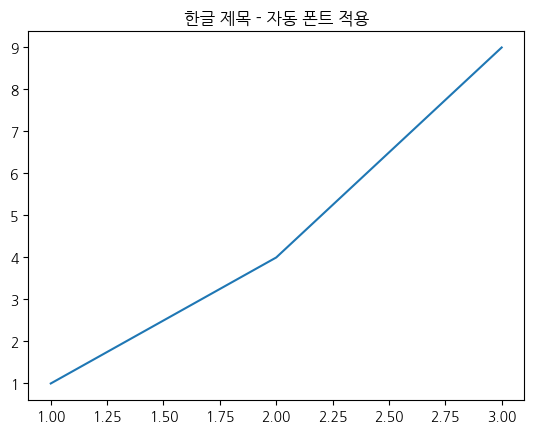

In [2]:

import matplotlib.pyplot as plt
import koreanize_matplotlib  # <-- 이 줄을 plt 사용 전에 넣어주세요

plt.plot([1, 2, 3], [1, 4, 9])
plt.title("한글 제목 - 자동 폰트 적용")
plt.show()


사용자성향 분석 

>>> [시스템] 표정 분석 엔진 구동 시작...

>>> [분석] 감지된 사용자 반응 로그 (일부):
  timestamp content_tag  emotion  happiness_score
0     00:10        슬랩스틱  average         0.466206
1     00:45       감동/눈물  average         0.211325
2     01:20        사실정보  average         0.050000
3     02:15        사회풍자    other         0.074984
4     03:00         귀여움    happy         0.850000

>>> [결과] 사용자 성향 도출: ENFP
>>> [시스템] 시각화 보고서를 생성합니다...


/tmp/ipykernel_569142/3544825502.py:185: UserWarning: Glyph 128522 (\N{SMILING FACE WITH SMILING EYES}) missing from font(s) NanumGothic.
  plt.tight_layout()
/home/user5/miniconda3/envs/tomas/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128522 (\N{SMILING FACE WITH SMILING EYES}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


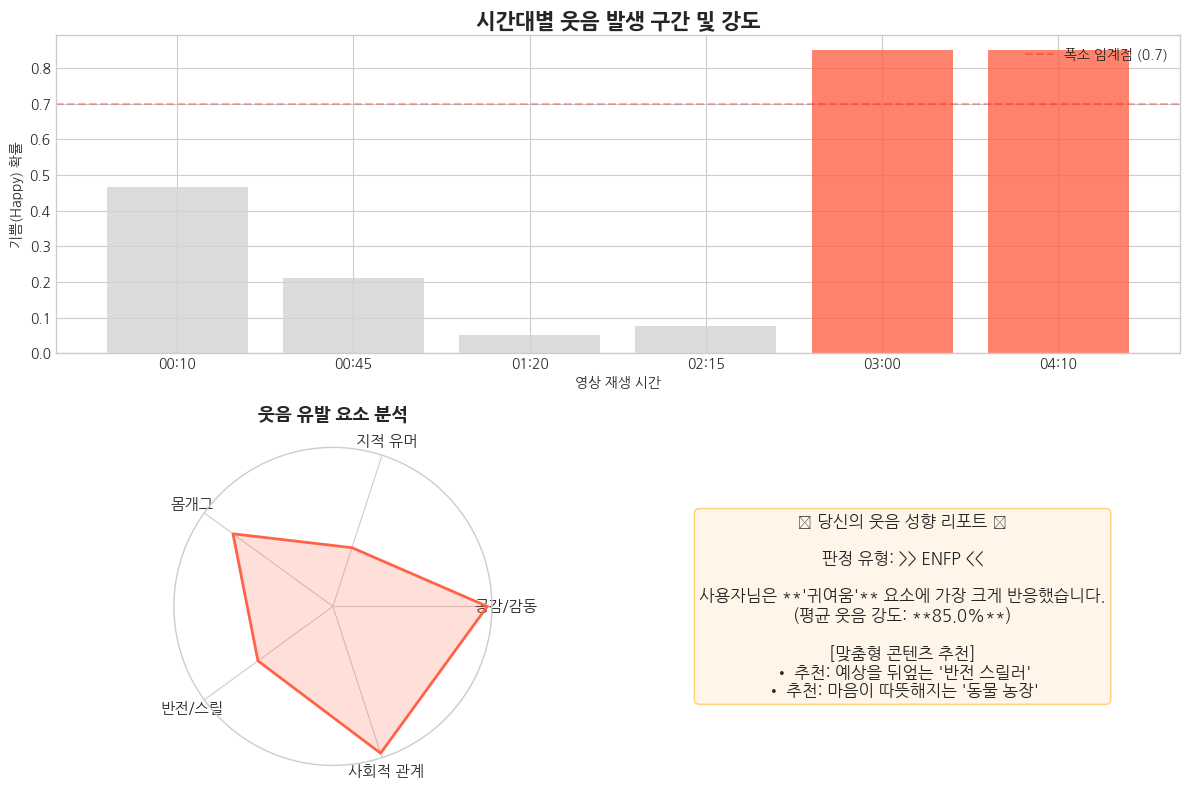

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import pi
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import random
import os

# ==========================================
# [중요] 스타일 설정을 import보다 먼저 하거나, 폰트 설정을 나중에 해야 합니다.
# 1. 먼저 스타일을 지정해버립니다. (함수 안에서 뺌)
# ==========================================
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except:
    plt.style.use('ggplot')

# ==========================================
# 2. 그 다음 한글 폰트 라이브러리를 불러옵니다.
# ==========================================
import koreanize_matplotlib 

# [리눅스 안전장치] 만약 라이브러리가 있어도 안 될 경우를 대비해 나눔고딕 강제 지정
# 리눅스에는 보통 'NanumGothic'이 설치되어 있습니다.
plt.rcParams['font.family'] = 'NanumGothic' 
plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐 방지


# ==========================================
# 3. 이하 로직 동일
# ==========================================
USE_MOCK_DATA = True

CLASS_MAP = {"happy": 0, "average": 1, "other": 2}
idx_to_class = {v: k for k, v in CLASS_MAP.items()}

# ... (Dataset, Model, Profiler 클래스는 기존과 동일하므로 생략하지 않고 그대로 둡니다) ...

class FacialExpressionDataset(Dataset):
    def __init__(self, sources, transform=None, is_mock=False):
        self.sources = sources
        self.transform = transform
        self.is_mock = is_mock
        self.data = []
        if self.is_mock:
            for _ in range(100):
                label_str = random.choice(list(CLASS_MAP.keys()))
                self.data.append(("/mock/path/img.jpg", CLASS_MAP[label_str]))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        if self.is_mock:
            image = torch.randn(3, 224, 224)
        else:
            try:
                image = Image.open(img_path).convert('RGB')
                if self.transform:
                    image = self.transform(image)
            except:
                image = torch.zeros(3, 224, 224)
        return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class LaughterProfiler:
    def simulate_user_session(self):
        # 데이터 생성 로직
        content_log = [
            {"time": "00:10", "genre": "코미디", "tag": "슬랩스틱", "desc": "넘어지는 장면"},
            {"time": "00:45", "genre": "드라마", "tag": "감동/눈물", "desc": "주인공의 재회"},
            {"time": "01:20", "genre": "정보", "tag": "사실정보", "desc": "뉴스 속보"},
            {"time": "02:15", "genre": "코미디", "tag": "사회풍자", "desc": "정치 풍자 농담"},
            {"time": "03:00", "genre": "동물", "tag": "귀여움", "desc": "강아지 영상"},
            {"time": "04:10", "genre": "공포", "tag": "반전개그", "desc": "귀신 등장 후 반전"}
        ]
        session_data = []
        for content in content_log:
            if content['tag'] in ['귀여움', '반전개그']:
                pred_probs = [0.85, 0.1, 0.05]
            elif content['tag'] == '사실정보':
                pred_probs = [0.05, 0.9, 0.05]
            else:
                pred_probs = np.random.dirichlet(alpha=[1, 1, 1]).tolist()
            
            predicted_class = np.argmax(pred_probs)
            session_data.append({
                "timestamp": content["time"],
                "content_tag": content["tag"],
                "content_desc": content["desc"],
                "emotion": idx_to_class[predicted_class],
                "happiness_score": float(pred_probs[0])
            })
        return pd.DataFrame(session_data)

    def analyze_mbti(self, df):
        happy_moments = df[df['emotion'] == 'happy']
        if happy_moments.empty:
            return "ISTJ또는 INTJ", "웃음 장벽이 에베레스트급! 냉철한 분석가 스타일입니다."
        
        avg_intensity = happy_moments['happiness_score'].mean()
        tag_counts = happy_moments['content_tag'].value_counts()
        top_tag = tag_counts.idxmax() if not tag_counts.empty else "없음"
        
        if "반전" in top_tag or "풍자" in top_tag: mbti_result = "E-N성향"
        elif "귀여움" in top_tag or "감동" in top_tag: mbti_result = "E-S성향"
        elif "슬랩스틱" in top_tag or "예측불가능" in top_tag: mbti_result = "E-F성향"
        elif "팩트폭격"in top_tag or "반전" in top_tag: mbti_result = "E-J성향"
        elif "즉흥" in top_tag or "전염성" in top_tag: mbti_result = "E-P성향"
        else: mbti_result = "극 대문자 I와 T성향이 강합니다."
            
        desc = f"사용자님은 **'{top_tag}'** 요소에 가장 크게 반응했습니다.\n(평균 웃음 강도: **{avg_intensity*100:.1f}%**)"
        return mbti_result, desc

# ==========================================
# 4. 시각화 함수 (여기가 핵심 수정됨)
# ==========================================

def generate_report_card(user_df, mbti_type, description):
    # [수정] 함수 안에서 plt.style.use()를 호출하지 않습니다!
    # 이미 맨 위에서 설정했거나, 여기서 호출하면 폰트가 초기화되기 때문입니다.
    
    # 혹시라도 폰트가 풀렸을까봐 한 번 더 강제 지정 (리눅스용)
    plt.rcParams['font.family'] = 'NanumGothic'
    
    fig = plt.figure(figsize=(12, 8))
    gs = fig.add_gridspec(2, 2)
    
    # 1. 타임라인 차트
    ax1 = fig.add_subplot(gs[0, :])
    colors = ['tomato' if x > 0.9 else 'lightgray' for x in user_df['happiness_score']]
    ax1.bar(user_df['timestamp'], user_df['happiness_score'], color=colors, alpha=0.8)
    
    ax1.set_title("시간대별 웃음 발생 구간 및 강도", fontsize=15, fontweight='bold')
    ax1.set_ylabel("기쁨(Happy) 확률")
    ax1.set_xlabel("영상 재생 시간")
    ax1.axhline(y=0.7, color='red', linestyle='--', alpha=0.3, label='폭소 임계점 (0.7)')
    ax1.legend(loc='upper right')

    # 2. 성향 레이더 차트
    categories = ['공감/감동', '지적 유머', '몸개그', '반전/스릴', '사회적 관계']
    if "F" in mbti_type: values = [5, 2, 4, 3, 5]
    elif "T" in mbti_type: values = [1, 5, 2, 4, 2]
    else: values = [3, 3, 3, 3, 3]
    
    values += values[:1]
    angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
    angles += angles[:1]
    
    ax2 = fig.add_subplot(gs[1, 0], polar=True)
    ax2.plot(angles, values, linewidth=2, linestyle='solid', color='tomato')
    ax2.fill(angles, values, 'tomato', alpha=0.2)
    ax2.set_xticks(angles[:-1])
    ax2.set_xticklabels(categories, fontsize=11)
    ax2.set_title("웃음 유발 요소 분석", pad=20, fontweight='bold', fontsize=13)
    ax2.set_yticks([]) 
    
    # 3. 최종 결과 텍스트
    ax3 = fig.add_subplot(gs[1, 1])
    ax3.axis('off')
    
    recommends = "• 추천: 예상을 뒤엎는 '반전 스릴러'\n• 추천: 마음이 따뜻해지는 '동물 농장'"
    if "T" in mbti_type:
        recommends = "• 추천: 지적 호기심을 채우는 '과학 예능'\n• 추천: 블랙코미디 시트콤"

    text_str = (
        f"😊 당신의 웃음 성향 리포트 😊\n\n"
        f"판정 유형: >> {mbti_type} <<\n\n"
        f"{description}\n\n"
        f"[맞춤형 콘텐츠 추천]\n{recommends}"
    )
    
    props = dict(boxstyle='round', facecolor='#FFEFD5', alpha=0.5, edgecolor='orange')
    ax3.text(0.5, 0.5, text_str, transform=ax3.transAxes, fontsize=12,
            verticalalignment='center', horizontalalignment='center', bbox=props)

    plt.tight_layout()
    plt.show()

# ==========================================
# [MAIN] 실행부
# ==========================================
if __name__ == "__main__":
    print(">>> [시스템] 표정 분석 엔진 구동 시작...")
    
    profiler = LaughterProfiler()
    user_session_df = profiler.simulate_user_session()
    
    print("\n>>> [분석] 감지된 사용자 반응 로그 (일부):")
    print(user_session_df[['timestamp', 'content_tag', 'emotion', 'happiness_score']].head())
    
    mbti_type, description = profiler.analyze_mbti(user_session_df)
    
    print(f"\n>>> [결과] 사용자 성향 도출: {mbti_type}")
    
    print(">>> [시스템] 시각화 보고서를 생성합니다...")
    generate_report_card(user_session_df, mbti_type, description)